# 🐌 Prepare data

## 🦛 Install need packages¶

In [1]:
! pip install gdown

In [2]:
import gdown

url = "https://drive.google.com/uc?id=15uPcQurzdz2aO2Bgf3WLEsQ3nAaMaM8T"
output = 'requirements.txt'
gdown.download(url, output, quiet=False);

Downloading...
From: https://drive.google.com/uc?id=15uPcQurzdz2aO2Bgf3WLEsQ3nAaMaM8T
To: /kaggle/working/requirements.txt
100%|██████████| 2.36k/2.36k [00:00<00:00, 2.68MB/s]


In [3]:
! pip install -r requirements.txt
! pip install tianshou coloredlogs

  Cloning https://github.com/thu-ml/tianshou.git (to revision ade85ab32baab721605508dfd9d460015a1832e5) to /tmp/pip-install-7mko5npd/tianshou_23275655ff0441e7ac41cf687a3bee84
  Running command git clone --filter=blob:none --quiet https://github.com/thu-ml/tianshou.git /tmp/pip-install-7mko5npd/tianshou_23275655ff0441e7ac41cf687a3bee84
  Running command git rev-parse -q --verify 'sha^ade85ab32baab721605508dfd9d460015a1832e5'
  Running command git fetch -q https://github.com/thu-ml/tianshou.git ade85ab32baab721605508dfd9d460015a1832e5
  Running command git checkout -q ade85ab32baab721605508dfd9d460015a1832e5
  Resolved https://github.com/thu-ml/tianshou.git to commit ade85ab32baab721605508dfd9d460015a1832e5
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.5/159.5 kB 4.0 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 

## 🐦 Imports

In [4]:
import gymnasium
import numpy as np
from gymnasium.spaces import Discrete, MultiDiscrete
from gymnasium import spaces
import random

from IPython.display import clear_output
import time
from pettingzoo import AECEnv
from pettingzoo.utils import agent_selector, wrappers
import matplotlib.pyplot as plt
from tianshou.env.pettingzoo_env import PettingZooEnv

from typing import Optional, Tuple
from tianshou.policy import BasePolicy, DQNPolicy, RainbowPolicy, MultiAgentPolicyManager, RandomPolicy
from tianshou.trainer import OffpolicyTrainer
from tianshou.utils.net.common import Net
from tianshou.env import DummyVectorEnv
from copy import deepcopy
from tianshou.data import Collector, VectorReplayBuffer

from torch.utils.tensorboard import SummaryWriter
from tianshou.utils import TensorboardLogger
from tianshou.data import Batch
import torch

import random
import os

NUM_ITERS = 400
PLAYS = {"bastaushy": 0, "qostaushy": 0}

# 🐘 AEC environment https://pettingzoo.farama.org/api/aec/#about-aec

## 🦉 Create environment

In [5]:
class TogyzQumalaqEnv(AECEnv):
    """
    The "name" metadata allows the environment to be pretty printed.
    """

    metadata = {
        "render_modes": ["ansi", "human"],
        "name": "togyzqumalaq_v0"
        }

    def __init__(self, render_mode=None):
        """
        The init method takes in environment arguments and
         should define the following attributes:
        - otaular
        - tuzdyq
        - qazandar
        - possible_agents
        - render_mode
        """
        self.otaular = []
        self.tuzdyq = []
        self.qazandar = []
        self.direction = []
        self.agents = ["bastaushy", "qostaushy"]
        self.possible_agents = self.agents[:]
        self.action_spaces = {i: spaces.Discrete(9) for i in self.agents}
        self.observation_spaces = {
            i: spaces.Dict(
                {
                    "observation":
                        MultiDiscrete([100] * 18 + [10] * 2 + [162] * 2 + [2]),
                    "action_mask":
                        Discrete(9),
                }
            )
            for i in self.agents
        }
        self.render_mode = render_mode

    # Action space should be defined here.
    def action_space(self, agent):
        return self.action_spaces[agent]

    # Observation space should be defined here.
    def observation_space(self, agent):
        return self.observation_spaces[agent]

    def render(self):
        """
        Renders the environment. In human mode,
        it can print to terminal, open
        up a graphical window, or open up some
        other display that
        a human can see and understand.
        """
        """Renders the environment."""
        if self.render_mode is None:
            gymnasium.logger.warn(
                "You are calling render method without "
                "specifying any render mode."
            )
            return

        if len(self.agents) == 2:
            points_bastaushy_x = np.array([i * 2 for i in range(10)])
            points_bastaushy_y = np.array([i % 5 for i in range(50)])

            qazandar = self.qazandar
            otaular = self.otaular
            tuzdyq = self.tuzdyq
            x = np.arange(-3, 225, 1)
            y = -1

            text_kwargs = dict(ha='center', va='center', fontsize=12)
            plt.figure(figsize=(15, 4))

            for i in range(9):
                # qostaushy's part
                plt.scatter(np.repeat(
                    points_bastaushy_x + 25 * i, 5)[:otaular[17 - i]],
                            points_bastaushy_y[:otaular[17 - i]], marker='o')
                # vertical lines
                plt.plot(np.repeat(25 * i - 2, len(x)),
                         np.arange(-7, 5, 12 / len(x)))
                # bastaushy's part
                plt.scatter(np.repeat(points_bastaushy_x + 25 * i, 5)[:otaular[i]],
                                points_bastaushy_y[:otaular[i]] - 6, marker='o')
            
            # horizontal line
            x_lims = np.arange(-3, 245, 1)
            plt.plot(x_lims, np.repeat(y, len(x_lims)))
            # last vertical line
            plt.plot(np.repeat(25 * 9 - 2, 13),
                     np.arange(-7, 6, 1))
        
            for i in range(9):
                # bastaushy's qumalaqtar
                plt.text(25 * i + 10, -7,
                         f'{i} ({otaular[i]})', **text_kwargs)
                # qostaushy's qumalaqtar
                plt.text(25 * i + 10, 5,
                         f'{17 - i} ({otaular[17 - i]})', **text_kwargs)
            # bastaushy qazan's qumalaqtar
            plt.text(235, -4,
                     f'qazan: {qazandar[0]}', **text_kwargs)
            # qostaushy qazan's qumalaqtar
            plt.text(235, 2,
                     f'qazan: {qazandar[1]}', **text_kwargs)
            # bastaushy tuzdyq's qumalaqtar
            plt.text(235, -6,
                     f'tuzdyq: {tuzdyq[0]}', **text_kwargs)
            # qostaushy tuzdyq's qumalaqtar
            plt.text(235, 0,
                     f'tuzdyq: {tuzdyq[1]}', **text_kwargs)
            plt.xticks([])
            plt.yticks([])
            plt.show()
        else:
            if self.render_mode == "human":
                print("Game over")
        time.sleep(1)
        #clear_output()

    def _legal_moves(self, agent):
        cur_player = self.possible_agents.index(agent)
        opp_player = (cur_player + 1) % 2
        return [item for item in range(9) if self.tuzdyq[opp_player] != item  + cur_player * 9 and self.otaular[item + cur_player * 9] > 0]

    def observe(self, agent):
        """
        Observe should return the observation of the specified agent. This function
        should return a sane observation (though not necessarily the most up to date possible)
        at any time after reset() is called.
        """
        # observation of one agent is the previous state of the other
        legal_moves = self._legal_moves(agent) if agent == self.agent_selection else []
        action_mask = np.zeros(9, "int8")
        
        for i in legal_moves:
            action_mask[i] = 1
        observation = tuple(
            self.otaular + self.tuzdyq + self.qazandar + [self.possible_agents.index(self.agent_selection)]
        )
        return {"observation": observation, "action_mask": action_mask}

    def close(self):
        """
        Close should release any graphical displays, subprocesses, network connections
        or any other environment data which should not be kept around after the
        user is no longer using the environment.
        """
        pass

    def reset(self, seed=None, options=None):
        """
        Reset needs to initialize the following attributes
        - agents
        - rewards
        - _cumulative_rewards
        - terminations
        - truncations
        - infos
        - agent_selection
        """
        self.agents = self.possible_agents[:]
        self.rewards = {agent: 0 for agent in self.agents}
        self._cumulative_rewards = {agent: 0 for agent in self.agents}
        self.otaular = [9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9]
        self.direction = [list(range(18)), [9, 10, 11, 12, 13, 14, 15, 16, 17, 0, 1, 2, 3, 4, 5, 6, 7, 8]]
        self.tuzdyq = [-1, -1]
        self.qazandar = [0, 0]
        self.terminations = {agent: False for agent in self.agents}
        self.truncations = {agent: False for agent in self.agents}
        self.infos = {agent: {} for agent in self.agents}
        self.num_moves = 0
        observation = tuple(
            self.otaular + self.tuzdyq + self.qazandar + [0]
        )
        self.observations = {agent: observation for agent in self.agents}
        """
        Our agent_selector utility allows easy cyclic stepping through the agents list.
        """
        self._agent_selector = agent_selector(self.agents)
        self.agent_selection = self._agent_selector.next()

    def step(self, action):
        """
        step(action) takes in an action for the current agent (specified by
        agent_selection) and needs to update
        - rewards
        - _cumulative_rewards (accumulating the rewards)
        - terminations
        - truncations
        - infos
        - agent_selection (to the next agent)
        And any internal state used by observe() or render()
        """
        if (
            self.terminations[self.agent_selection]
            or self.truncations[self.agent_selection]
        ):
            # handles stepping an agent which is already dead
            # accepts a None action for the one agent, and moves the agent_selection to
            # the next dead agent,  or if there are no more dead agents, to the next live agent
            self._was_dead_step(action)
            return
        self.rewards = {agent: 0 for agent in self.agents}
        cur_player = self.possible_agents.index(self.agent_selection)
        opp_player = (cur_player + 1) % 2
        self.num_moves += 1
        if self.render_mode == "human":
            print(f'MOVE #{self.num_moves}')
        # The truncations dictionary must be updated for all players.
        self.truncations = {
            agent: self.num_moves >= NUM_ITERS for agent in self.agents
        }
        # distribute qumalaqs
        if cur_player == 1:
            action += 9
        if self.render_mode == "human":
            print(f'{self.agent_selection} made action {action}')
        num_qumalaq = self.otaular[action]
        idx_action = self.direction[cur_player].index(action)
        if self.otaular[action] == 1:
            self.otaular[self.direction[cur_player][idx_action + 1]] += 1
            self.otaular[action] -= 1
        else:
            i = 1
            coef = 1
            if self.otaular[action] / 18 > 1:
                coef = int(self.otaular[action] / 18) + 1
            while self.otaular[action] > coef:
                self.otaular[self.direction[cur_player][(idx_action + i) % 18]] += 1
                self.otaular[action] -= 1
                i += 1
        # check tuzdyq & add rewards to qazandar
        reward = 0
        if self.tuzdyq[cur_player] < 0 and self.check_tuzdyq(self.agent_selection, action, num_qumalaq):
            reward += 3
            if self.render_mode == "human":
                print(f'{self.agent_selection} won tuzdyq {reward}')
                
            #******* awarding a rewards for receiving tuzdyq **********
            # self.rewards[self.agent_selection] += 50
            # self.rewards[self.possible_agents[opp_player]] -= 50
        else:

            if num_qumalaq > 1:
                last_otau = self.direction[cur_player][(idx_action + num_qumalaq - 1) % 18]
            else:
                last_otau = self.direction[cur_player][(idx_action + num_qumalaq) % 18]

            if (last_otau in range(opp_player * 9, (opp_player + 1) * 9) and
                    self.otaular[last_otau] % 2 == 0):
                reward += self.otaular[last_otau]
                if self.render_mode == "human":
                    print(f'{self.agent_selection} won {reward}')
                self.otaular[last_otau] = 0
            if (self.tuzdyq[cur_player] >= 0 and
                    self.otaular[self.tuzdyq[cur_player]] > 0):
                reward += self.otaular[self.tuzdyq[cur_player]]
                if self.render_mode == "human":
                    print(f'{self.agent_selection} won tuzdyq {self.otaular[self.tuzdyq[cur_player]]}')
                self.otaular[self.tuzdyq[cur_player]] = 0
        if self.render_mode == "human":
            print(f'{self.agent_selection} won total {reward}')
        self.qazandar[cur_player] += reward

        #******* awarding a rewards from otaular **********
        self.rewards[self.agent_selection] += reward
        self.rewards[self.possible_agents[opp_player]] -= reward
        
        # check if there is a winner
        winner = self.check_for_winner()
        if winner:
            self.terminations = {i: True for i in self.agents}
            if self.render_mode == "human":
                print(f'{self.agent_selection} won the game!!!')
                
            #******* awarding a reward for winning a game **********
            self.rewards[self.agent_selection] += self.qazandar[opp_player]
            self.rewards[self.possible_agents[opp_player]] -= self.qazandar[opp_player]
            for i in range(9):
                self.rewards[self.agent_selection] += self.otaular[i + 9 * opp_player]
                self.rewards[self.possible_agents[opp_player]] -= self.otaular[i + 9 * opp_player]
            
        # selects the next agent.
        self.agent_selection = self._agent_selector.next()
        # Adds .rewards to ._cumulative_rewards
        self._accumulate_rewards()

        total_rewards = sum(self.rewards.values())
        assert total_rewards == 0, f"Error: Total reward is not zero: {total_rewards}"
        total_qumalaqs = 0
        for i in self.otaular:
            total_qumalaqs += i
        for i in self.qazandar:
            total_qumalaqs += i
        assert total_qumalaqs == 162, f"Error: Total qumalaqs is not equal to 162: {total_qumalaqs}"
        if self.render_mode == "human":
            self.render()

    def check_tuzdyq(self, agent, action, num_qumalaq):
        cur_player = self.possible_agents.index(agent)
        opp_player = (cur_player + 1) % 2
        idx = self.direction[cur_player].index(action)

        if num_qumalaq > 1:
            last_otau = self.direction[cur_player][(idx + num_qumalaq - 1) % 18]
        else:
            last_otau = self.direction[cur_player][(idx + num_qumalaq) % 18]

        if (last_otau in range(opp_player * 9, (opp_player + 1) * 9) and
                self.otaular[last_otau] == 3 and last_otau != 17 - cur_player * 9 and
                abs(last_otau - self.tuzdyq[opp_player]) != 9):
            self.tuzdyq[cur_player] = last_otau
            self.otaular[last_otau] = 0
            if self.render_mode == "human":
                print(f'{agent} got tuzdyq {last_otau}!')
            return True

        return False

    def check_atsyrau(self, agent):
        cur_player = self.possible_agents.index(agent)
        opp_player = (cur_player + 1) % 2

        for idx, i in enumerate(
                self.otaular[cur_player * 9: (cur_player + 1) * 9]):
            if i > 0 and idx + cur_player * 9 != self.tuzdyq[opp_player]:
                return False
        if self.render_mode == "human":
            print(f'{agent} reached atsyrau')
        return True

    def check_for_winner(self):
        cur_player = self.possible_agents.index(self.agent_selection)
        opp_player = (cur_player + 1) % 2
        if self.qazandar[cur_player] > 81:
            PLAYS[self.agent_selection] += 1
            return True
        if (self.check_atsyrau(self.possible_agents[opp_player])
                and self.qazandar[opp_player] <= 81):
            PLAYS[self.agent_selection] += 1
            return True
        return False


def _get_env(render_mode=None):
    """This function is needed to provide callables for DummyVectorEnv."""
    def env(render_mode=None):
        """
        The env function often wraps the environment in wrappers by default.
        You can find full documentation for these methods
        elsewhere in the developer documentation.
        """
        internal_render_mode = render_mode \
            if render_mode != "ansi" else "human"
        env = TogyzQumalaqEnv(render_mode=internal_render_mode)
        # This wrapper is only for environments
        # which print results to the terminal
        if render_mode == "ansi":
            env = wrappers.CaptureStdoutWrapper(env)
        # this wrapper helps error handling for discrete action spaces
        env = wrappers.AssertOutOfBoundsWrapper(env)
        # Provides a wide vareity of helpful user errors
        # Strongly recommended
        env = wrappers.OrderEnforcingWrapper(env)
        return env
    return PettingZooEnv(env(render_mode=render_mode))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# 🐓 Play game

## 🐆 Play to test

In [6]:
# env = _get_env(render_mode='human')


# acts = [3,0,8,1,4,0,5,0,5,6,
#             	3,3,4,7,3,0,7,4,8,7,
#             	1,1,4,2,6,1,2,1,1,6,
#             	8,7,5,8,1,3,4,6,5,7,
#             	7,8,6,4,5,6,1,1,1,5,
#             	8,1,1,3,5,1,4,4,6,5,
#             	7,0,0,0,4,1,8,8,0,8,
#             	4,5,5,3,7,4,1,4,5,6,
#             	7,5,6,0,0,7,7,7,4,6,
#             	2,8,6,2,0,0,6,4,4,1,
#             	7,1,0,7,1,2,5,4,7,5,
#             	6,8,5,7,6,2,6,0,0,8,
#             	8,2,0,0,7,7,2,7,7,5,
#             	2,8,1,0,8,4,2,6,4,6,
#             	0,8,5,8,6,3,8,7,0,7,
#             	7,6,8,8,1,8,1,5,2,5,
#             	2,4]
# for act in acts:
            
#     obs, rew, _, _, _ = env.env.last()
    
#     observation = list(obs['observation'])

#     env.step(act)

### 🦂 Random test

In [7]:
# env = _get_env(render_mode='human')

# for _ in range(200):
    
#     #player = agent2index[env.env.agent_selection]

#     obs, rew, _, _, _ = env.env.last()
    
#     observation = list(obs['observation'])

#     potential_moves = [idx for idx,item in enumerate(obs['action_mask']) if item > 0]

#     # print('agent', env.env.agent_selection)

#     # print('potential_moves', potential_moves)

#     act = random.choice(potential_moves)

#     env.step(act)

### 🦆 Tests

In [8]:
import unittest

class TestTogyzQumalaqMethods(unittest.TestCase):

    def test_states(self):

        env = _get_env()

        ### Test #1
        
        acts = [4,5,8,0,5,7,5,3,7,5,2,7,5,8,6,4,8,4,3,5]
        
        for act in acts:
                    
            obs, rew, _, _, _ = env.env.last()
            
            observation = list(obs['observation'])
        
            env.step(act)
            
        obs, rew, _, _, _ = env.env.last()
        observation = list(obs['observation'])
        tuzdyq = observation[18:20]
        otaular = observation[:18]
        qazandar = observation[20:22]
        
        tuzdyq_test = [12, -1]
        otaular_test = [17,0,4,1,5,4,3,6,2,10,20,19,0,2,1,19,5,1]
        qazandar_test = [25, 18]
        
        self.assertEqual(otaular, otaular_test)
        self.assertEqual(tuzdyq, tuzdyq_test)
        self.assertEqual(qazandar, qazandar_test)

        env.reset()
        
        ### Test #2
        acts = [4, 7, 0, 6, 3, 3, 1, 0, 6, 3]

        for act in acts:
                    
            obs, rew, _, _, _ = env.env.last()
            
            observation = list(obs['observation'])
        
            env.step(act)[0]
            
        obs, rew, _, _, _ = env.env.last()
        observation = list(obs['observation'])
        tuzdyq = observation[18:20]
        otaular = observation[:18]
        qazandar = observation[20:22]
        
        tuzdyq_test = [-1, 3]
        otaular_test = [4, 3, 14, 0, 6, 15, 1, 14, 14, 2, 14, 14, 1, 14, 3, 3, 4, 13]
        qazandar_test = [20, 3]

        self.assertEqual(otaular, otaular_test)
        self.assertEqual(tuzdyq, tuzdyq_test)
        self.assertEqual(qazandar, qazandar_test)
        env.reset()

        ### Test #3
        acts = [2,3,8,6,4,7,0,4,3,0,1,3,8,3,7,2,2,0,6,5,7,8]

        for act in acts:
                    
            obs, rew, _, _, _ = env.env.last()
            
            observation = list(obs['observation'])
        
            env.step(act)[0]
            
        obs, rew, _, _, _ = env.env.last()
        observation = list(obs['observation'])
        tuzdyq = observation[18:20]
        otaular = observation[:18]
        qazandar = observation[20:22]
        
        tuzdyq_test = [16, -1]
        otaular_test = [7,5,4,8,11,21,2,2,6,4,11,4,6,5,2,11,1,2]
        qazandar_test = [48, 2]

        self.assertEqual(otaular, otaular_test)
        self.assertEqual(tuzdyq, tuzdyq_test)
        self.assertEqual(qazandar, qazandar_test)

    def test__legal_moves(self):
        env = _get_env()

        ### Test #1
        acts = [5,1,5,2,4,2,5,3,0,3]

        for act in acts:
            
            obs, rew, _, _, _ = env.env.last()
                    
            env.step(act)

        obs, rew, _, _, _ = env.env.last()
        potential_moves = [idx for idx,item in enumerate(obs['action_mask']) if item > 0]
        potential_moves_test = [0, 1, 2, 3, 4, 5, 6, 7, 8]
        self.assertEqual(potential_moves, potential_moves_test)

        ### Test #2
        
        env.reset()
        
        acts = [5,3,5,1,0,6,4,2,1,1,3,2,5,8,4,7,7,1,1,1]

        for act in acts:
            
            obs, rew, _, _, _ = env.env.last()
                        
            potential_moves = [idx for idx,item in enumerate(obs['action_mask']) if item > 0]
        
            env.step(act)
        potential_moves_test = [0, 1, 3, 4, 6, 7, 8]
        self.assertEqual(potential_moves, potential_moves_test)


    def test_check_tuzdyq(self):
        
        env = _get_env()
        
        ### Test #1

        acts = [3,8,0,8,5,6,1,1,8,5,1,7,5,0,6,1,2,5,1,8]
        
        for act in acts:
            
            obs, rew, _, _, _ = env.env.last()
                        
            potential_moves = [idx for idx,item in enumerate(obs['action_mask']) if item > 0]
        
            env.step(act)
            
        obs, rew, _, _, _ = env.env.last()
            
        observation = list(obs['observation'])
        
        tuzdyq = observation[18:20]
        tuzdyq_test = [-1, 5]
        self.assertEqual(tuzdyq, tuzdyq_test)

        env.reset()
        ## Test #2

        acts = [7,7,1,0,4,4,3,7,1,8,0]
        
        for act in acts:
            
            obs, rew, _, _, _ = env.env.last()
                        
            potential_moves = [idx for idx,item in enumerate(obs['action_mask']) if item > 0]
        
            env.step(act)
            
        obs, rew, _, _, _ = env.env.last()
            
        observation = list(obs['observation'])
        
        tuzdyq = observation[18:20]
        tuzdyq_test = [13, 6]
        self.assertEqual(tuzdyq, tuzdyq_test)
        
    def test_check_atsyrau(self):
        env = _get_env()
        ### Test #1
        acts = [6,2,5,8,3,0,8,4,1,5,
        	3,2,3,0,7,1,4,7,1,0,
        	0,5,6,3,0,3,3,1,7,4,
        	8,0,4,1,6,2,4,1,2,8,
        	6,8,6,7,2,4,4,1,6,7,
        	8,6,4,1,8,8,8,5,7,2,
        	3,2,2,4,0,1,6,0,8,1,
        	0,4,4,8,8,1,2,8,7,2,
        	8,2,5,4,4,8,6,4,2,1,
        	7,0,5,5,6,8,2,2,2,1,
        	8,6,8,8,4,0,7,2,5,2,
        	2,1,8,7,0,0,6,6,8,0,
        	6,7,5,2,3,0,2,2,7,2,
        	6,5,8,6,6,1,8,0,4,5,
        	4,5,5,6,6,2,5,4,6,5,
        	3,1,4,1,5,2,7,6,8,0,
        	7,0,3,4,4,6,6,5,5,1,
        	6,1,7,6,7,2,8,5,8,8,
        	0,8,0,2]
        for act in acts:
            
            obs, rew, _, _, _ = env.env.last()
                        
            potential_moves = [idx for idx,item in enumerate(obs['action_mask']) if item > 0]
        
            env.step(act)
            
        obs, rew, term, _, _ = env.env.last()
        
        self.assertTrue(term) 
        
        
    def test_check_for_winner(self):
        env = _get_env()
        ### Test #1
        acts = [4,8,7,4,8,2,5,7,7,0,
            	7,1,2,5,6,7,0,8,1,8,
            	5,0,1,1,8,0,6,0,3,3,
            	3,0,6,6,7,4,8,2,2,3,
            	1,8,6,8,6,1,0,3,1,1,
            	5,2,7,6,1,1,7,8,0,2,
            	6,7,5,7,2,8,1,3,2,3,
            	7,6,5,4,7,5,6,8,0,7,
            	5,8,7,4,2,5,7,1,6,2,
            	6,1,8,6,8,8,7,2,8,7,
            	3,2,5,3,3,4,6,4,0,5,
            	7,3,2,5,3,1,2,6,8,6,
            	7,4,0,2,3,3,8,7,0,8,
            	6,4,1,5,0,6,7,5,8,8,
            	0,6,2,7,2,7,0,8,1,8]
        for act in acts:
            
            obs, rew, _, _, _ = env.env.last()
                        
            potential_moves = [idx for idx,item in enumerate(obs['action_mask']) if item > 0]
        
            env.step(act)
            
        obs, rew, term, _, _ = env.env.last()
        
        self.assertTrue(term)

In [9]:
unittest.main(argv=[''], verbosity=2, exit=False)

test__legal_moves (__main__.TestTogyzQumalaqMethods) ... ok
test_check_atsyrau (__main__.TestTogyzQumalaqMethods) ... ok
test_check_for_winner (__main__.TestTogyzQumalaqMethods) ... ok
test_check_tuzdyq (__main__.TestTogyzQumalaqMethods) ... ok
test_states (__main__.TestTogyzQumalaqMethods) ... ok

----------------------------------------------------------------------
Ran 5 tests in 0.050s

OK


## 🦜 Play with agent 🐨

### 🦒 Load trained agent

In [10]:
def arch2str(net_arch):
    out = str(net_arch[0])
    for i in net_arch[1:]:
        out += 'x' + str(i)
    return out

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [11]:
!mkdir models
MODELS_PATH = os.path.join('/', 'kaggle', 'working', 'models')

/usr/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [12]:
urls = [
        "https://drive.google.com/uc?id=1uuRxMeltLJxkw4YcsmXG2uO4eNIP_HIa", #(4) Bastaushy
        #"https://drive.google.com/uc?id=1UmaeIgQ1dr3rxa6h6NgvDDM2ZV2_pPww", #(3) Qostaushy
       ]
for idx, url in enumerate(urls):
    output = f'models/policy_dqn_2048x4096x4096x2048_{idx}.pth'
    gdown.download(url, output, quiet=False);

Downloading...
From (original): https://drive.google.com/uc?id=1uuRxMeltLJxkw4YcsmXG2uO4eNIP_HIa
From (redirected): https://drive.google.com/uc?id=1uuRxMeltLJxkw4YcsmXG2uO4eNIP_HIa&confirm=t&uuid=3865f548-4942-40a2-b54f-c6cf4388a9ad
To: /kaggle/working/models/policy_dqn_2048x4096x4096x2048_0.pth
100%|██████████| 269M/269M [00:02<00:00, 98.5MB/s] 


In [13]:
NET_ARCHS = [[64,128,128,64], [1024, 2048, 2048, 1024], [2048, 4096, 4096, 2048], [2048, 4096, 8192, 4096, 2048]]

MAX_EPOCHS = 1000

STEP_PER_EPOCH = 10000

STEP_PER_COLLECT = 1000

EPISODE_PER_TEST = 200

UPDATE_PER_STEP = 1 / STEP_PER_COLLECT

BATCH_SIZE = 1024

LR = 1e-04

DF = 0.99

TRAIN_EPS = 0.12

TEST_EPS = 0.05

TRAIN_NUM = 100

TEST_NUM = 10

agent_idx2name = {0: 'bastaushy', 1: 'qostaushy'}

SEED = 555

In [14]:
net_arch = [2048, 4096, 4096, 2048]

env = _get_env()
for idx in range(len(urls)):

    agent_idx = idx % 2
    net = Net(
            state_shape=(23,),
            action_shape=env.action_space.shape or env.action_space.n,
            hidden_sizes=net_arch,
            device="cuda" if torch.cuda.is_available() else "cpu"
            )
            
    agent_trained = DQNPolicy(
            model=net,
            optim = torch.optim.Adam(net.parameters(), lr=LR),
            discount_factor=DF,
            estimation_step=3,
            target_update_freq=320,
            action_space=env.action_space,
            observation_space=env.observation_space
    ).to("cuda" if torch.cuda.is_available() else "cpu")
    
    arch_name = arch2str(net_arch)
    agent_trained.load_state_dict(torch.load(f"{MODELS_PATH}/policy_dqn_{arch_name}_{idx}.pth", map_location=torch.device('cpu')))

<ipython-input-14-933c6cdd910a>:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  agent_trained.load_state_dict(torch.load(f"{MODELS_PATH}/policy_dqn_{arch_name}_{idx}.pth",

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


MOVE #1
bastaushy made action 0
bastaushy won total 0


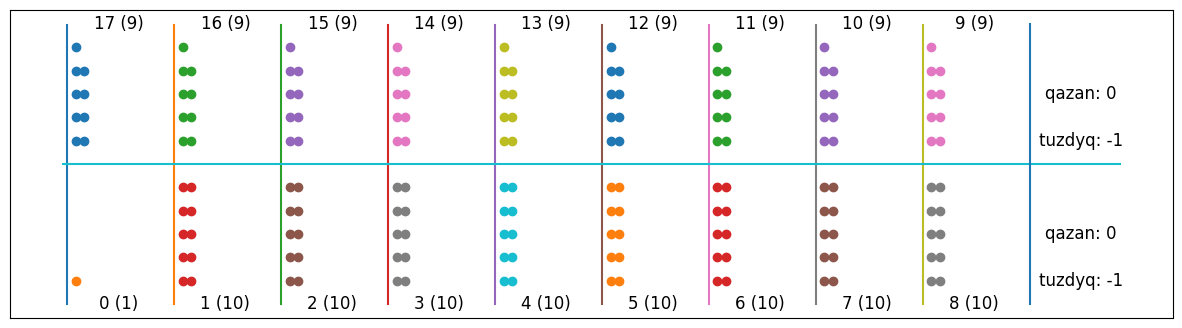

Please enter your action with mask [True, True, True, True, True, True, True, True, True] or press q for quit:


 1


MOVE #2
qostaushy made action 10
qostaushy won 2
qostaushy won total 2


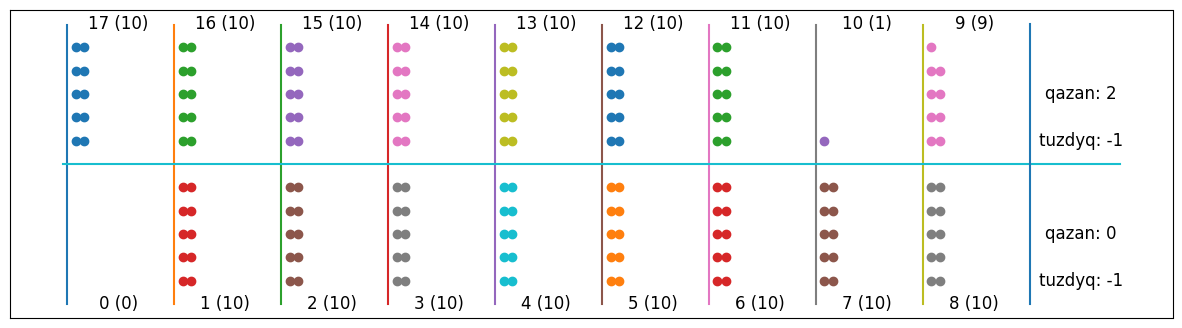

MOVE #3
bastaushy made action 8
bastaushy won total 0


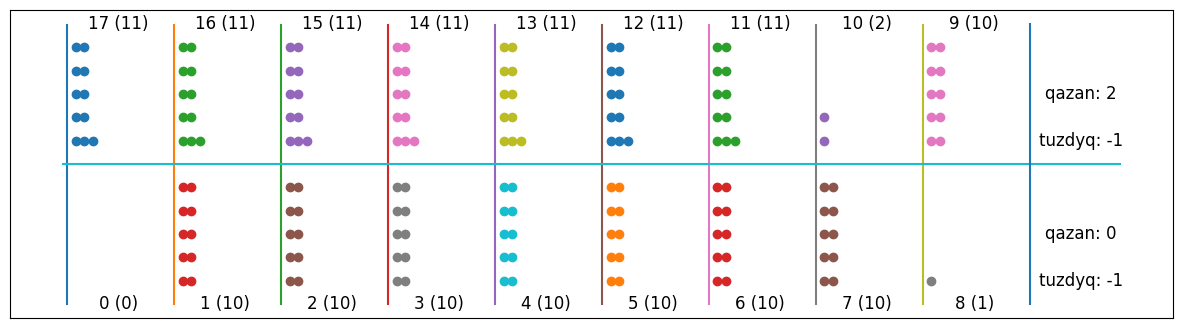

Please enter your action with mask [True, True, True, True, True, True, True, True, True] or press q for quit:


 7


MOVE #4
qostaushy made action 16
qostaushy won 2
qostaushy won total 2


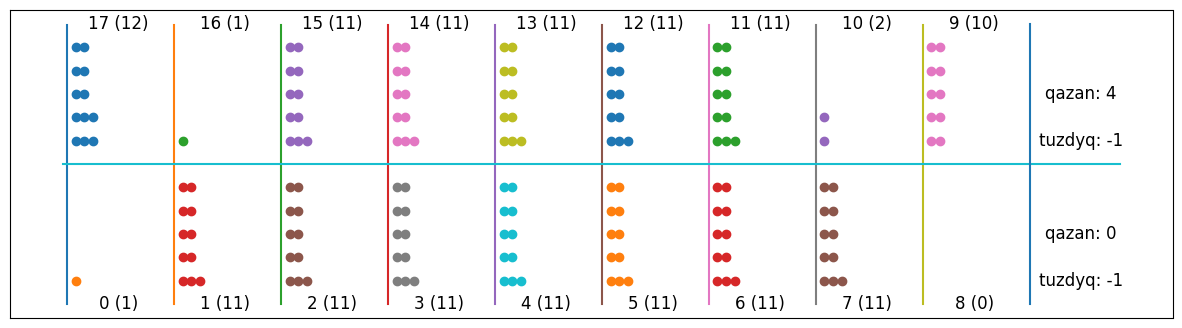

MOVE #5
bastaushy made action 7
bastaushy won total 0


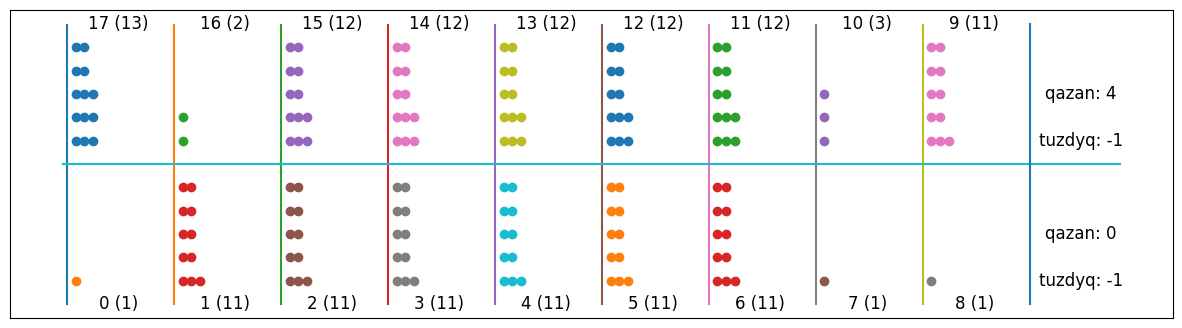

Please enter your action with mask [True, True, True, True, True, True, True, True, True] or press q for quit:


 0


MOVE #6
qostaushy made action 9
qostaushy won 12
qostaushy won total 12


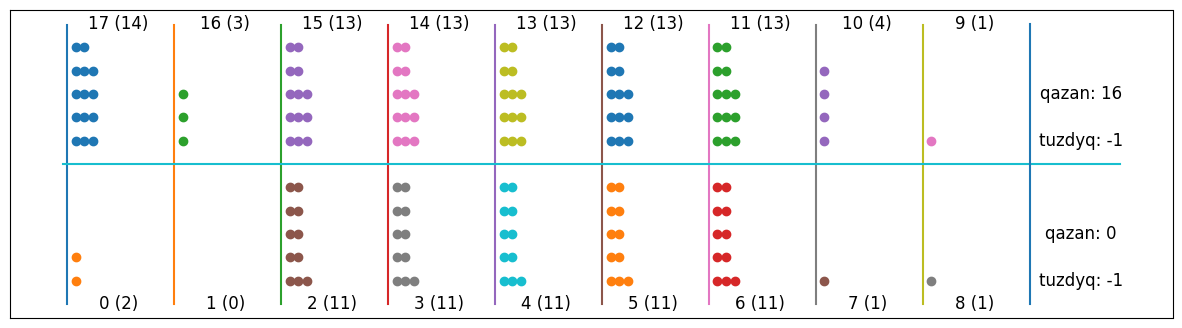

MOVE #7
bastaushy made action 5
bastaushy won 14
bastaushy won total 14


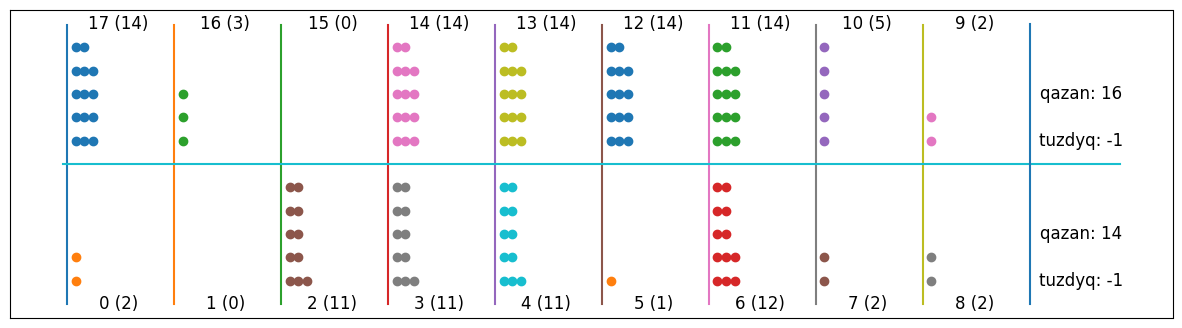

Please enter your action with mask [True, True, True, True, True, True, False, True, True] or press q for quit:


 2


MOVE #8
qostaushy made action 11
qostaushy won total 0


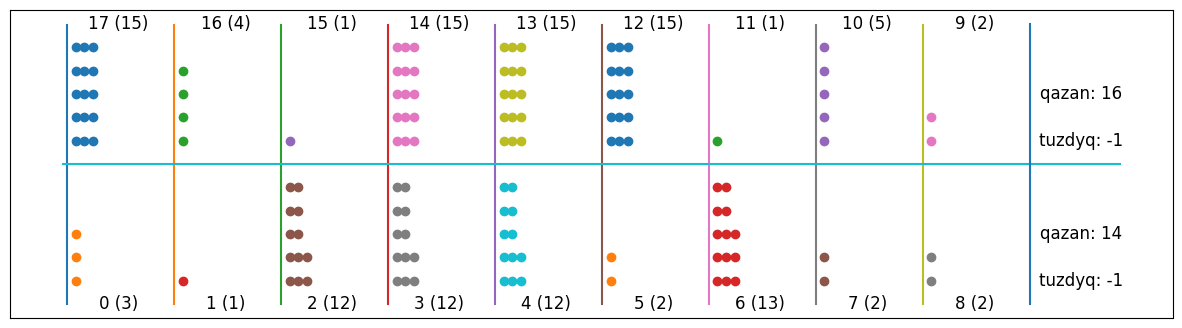

MOVE #9
bastaushy made action 3
bastaushy won 16
bastaushy won total 16


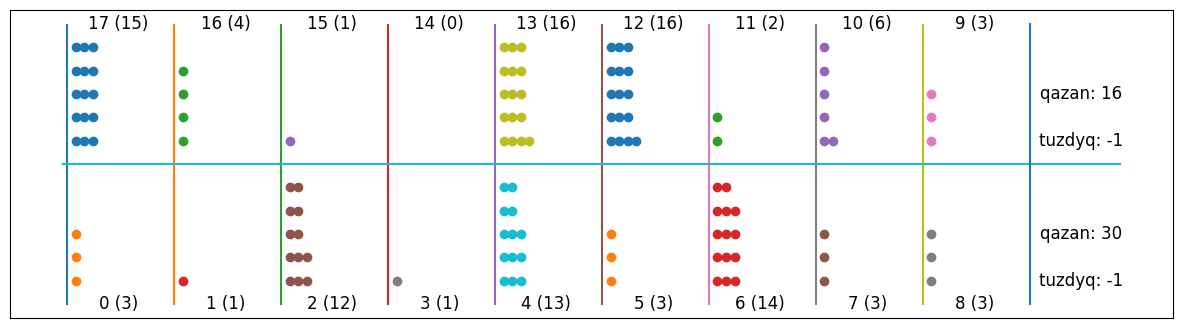

Please enter your action with mask [True, True, True, True, True, False, True, True, True] or press q for quit:


 7


MOVE #10
qostaushy made action 16
qostaushy won 2
qostaushy won total 2


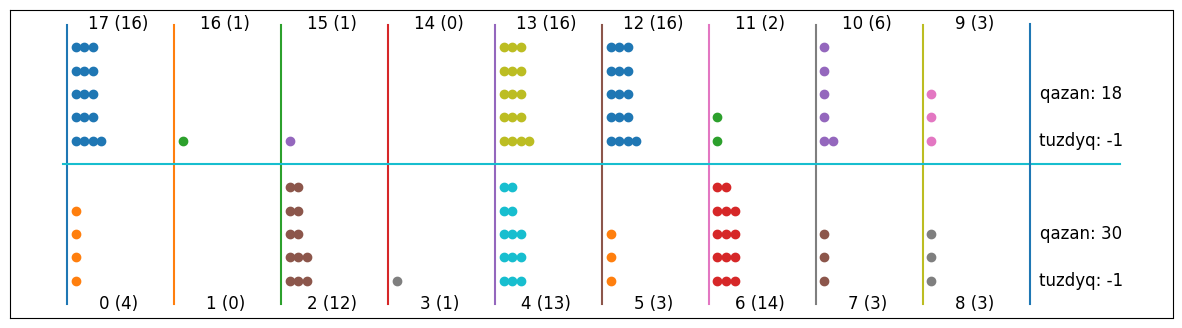

MOVE #11
bastaushy made action 4
bastaushy won 2
bastaushy won total 2


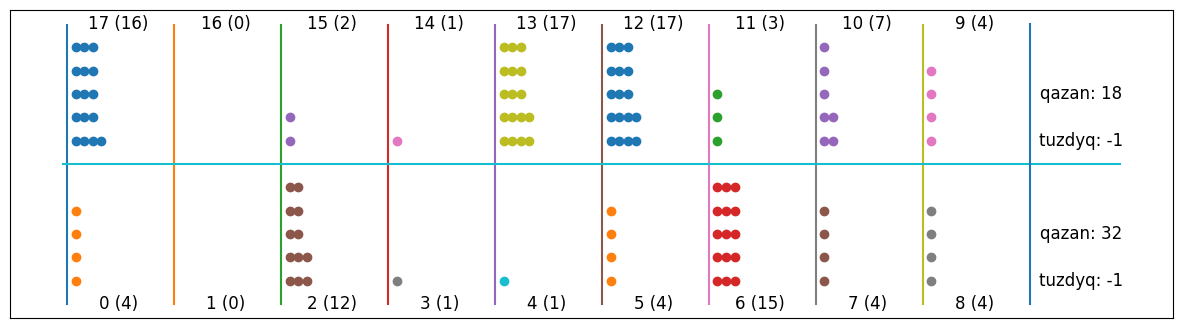

Please enter your action with mask [True, True, True, True, True, True, True, False, True] or press q for quit:


 5


MOVE #12
qostaushy made action 14
qostaushy won total 0


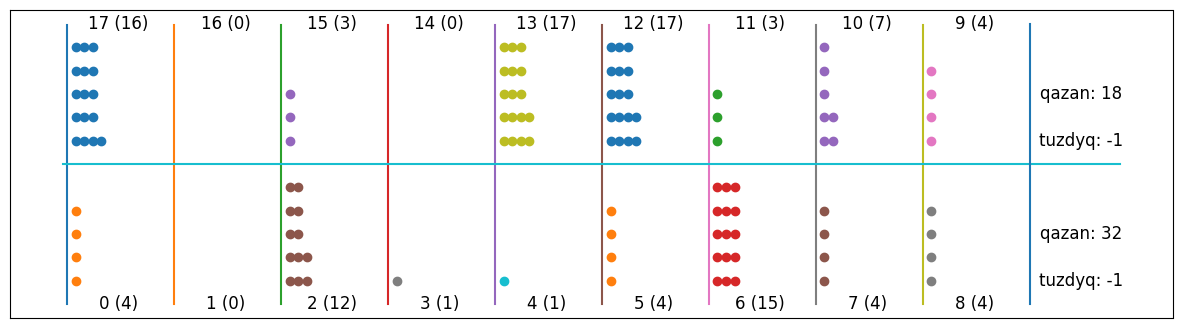

MOVE #13
bastaushy made action 7
bastaushy won 8
bastaushy won total 8


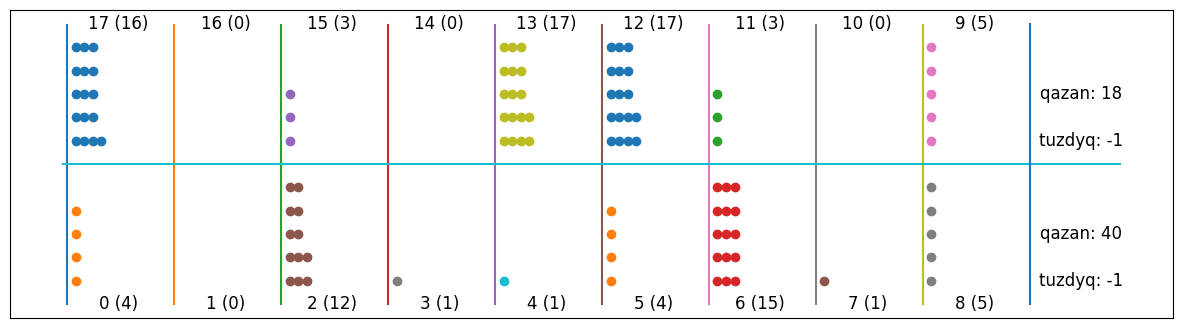

Please enter your action with mask [True, False, True, True, True, False, True, False, True] or press q for quit:


 2


MOVE #14
qostaushy made action 11
qostaushy won total 0


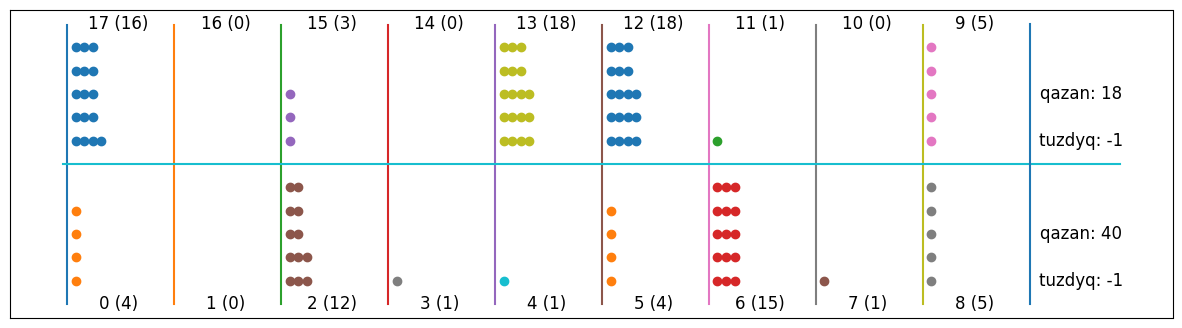

MOVE #15
bastaushy made action 7
bastaushy won total 0


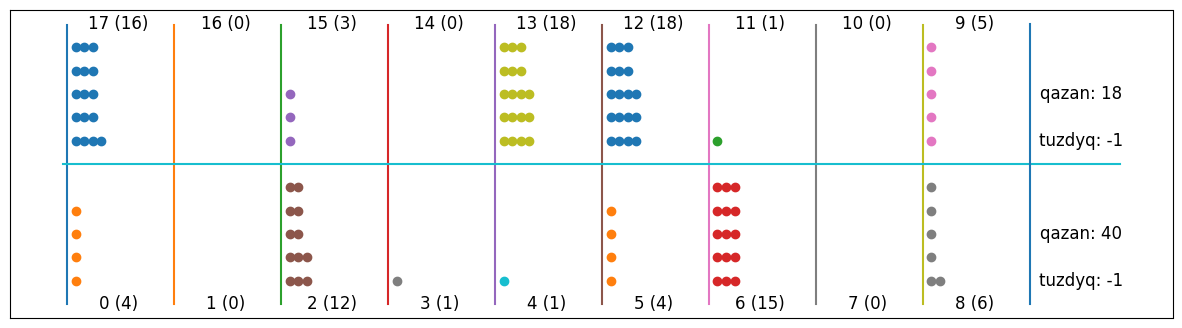

Please enter your action with mask [True, False, True, True, True, False, True, False, True] or press q for quit:


 6


MOVE #16
qostaushy made action 15
qostaushy won total 0


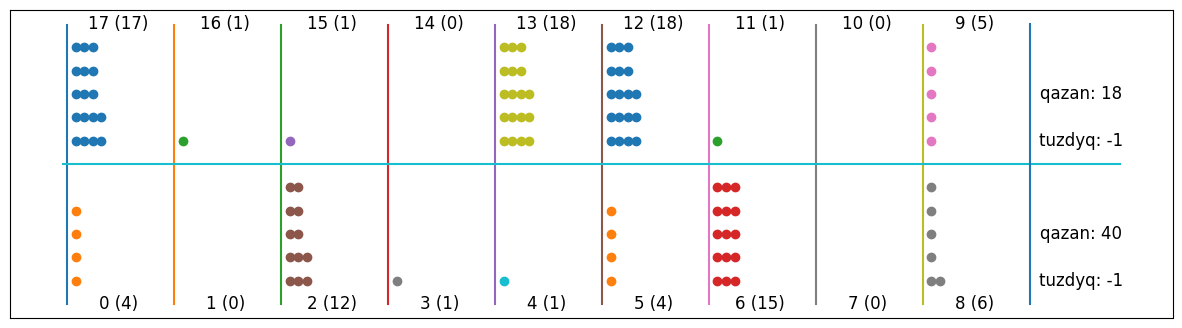

MOVE #17
bastaushy made action 8
bastaushy won total 0


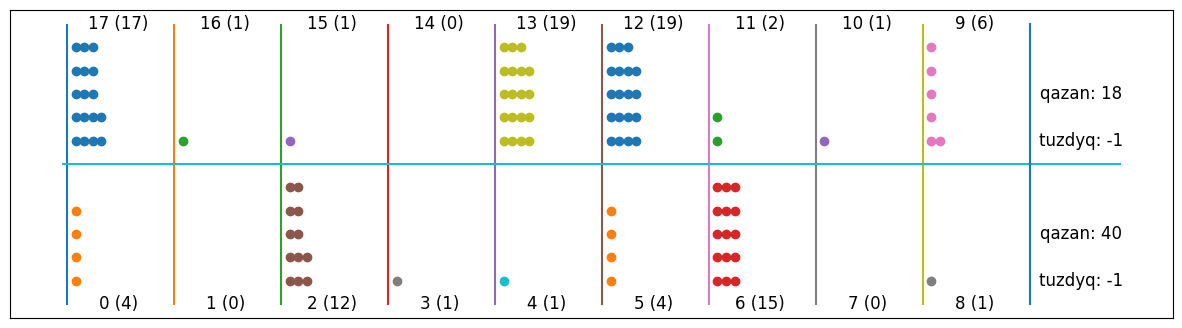

Please enter your action with mask [True, True, True, True, True, False, True, True, True] or press q for quit:


 3


MOVE #18
qostaushy made action 12
qostaushy won total 0


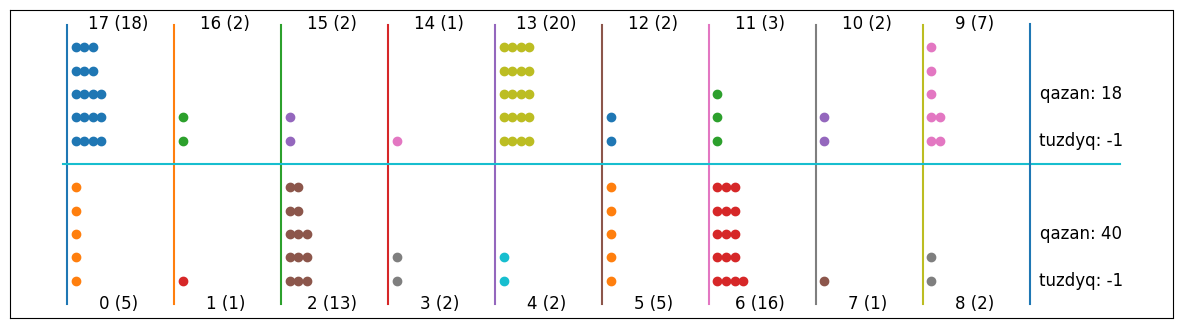

MOVE #19
bastaushy made action 3
bastaushy won total 0


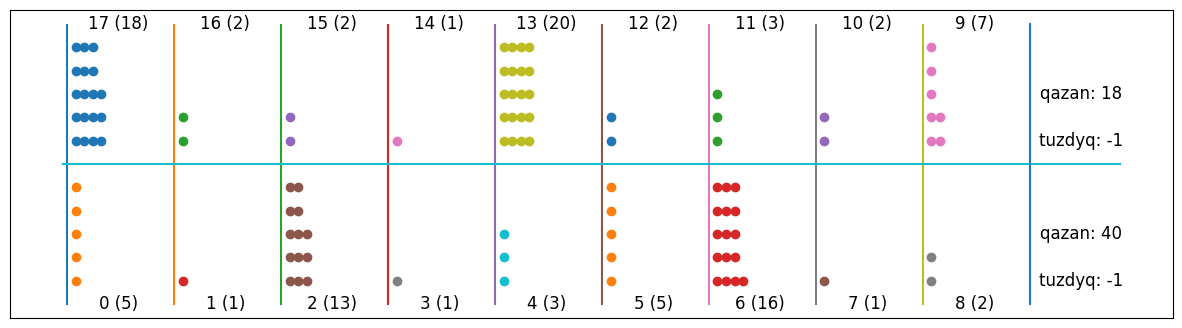

Please enter your action with mask [True, True, True, True, True, True, True, True, True] or press q for quit:


 8


MOVE #20
qostaushy made action 17
qostaushy won total 0


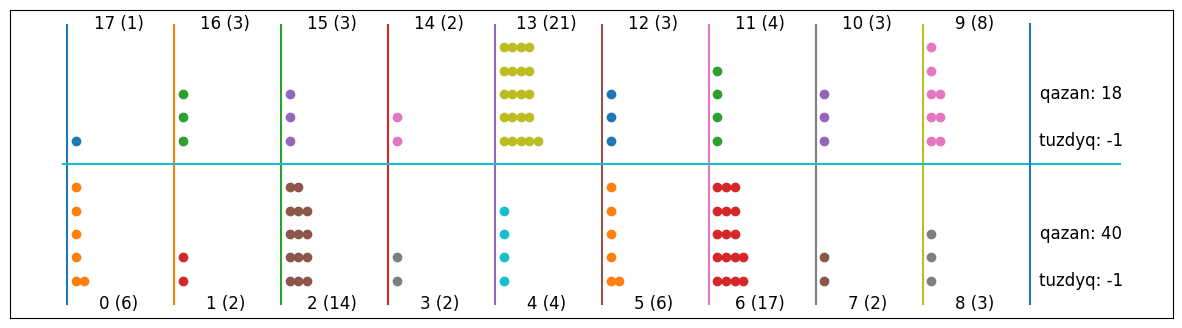

MOVE #21
bastaushy made action 2
bastaushy won 4
bastaushy won total 4


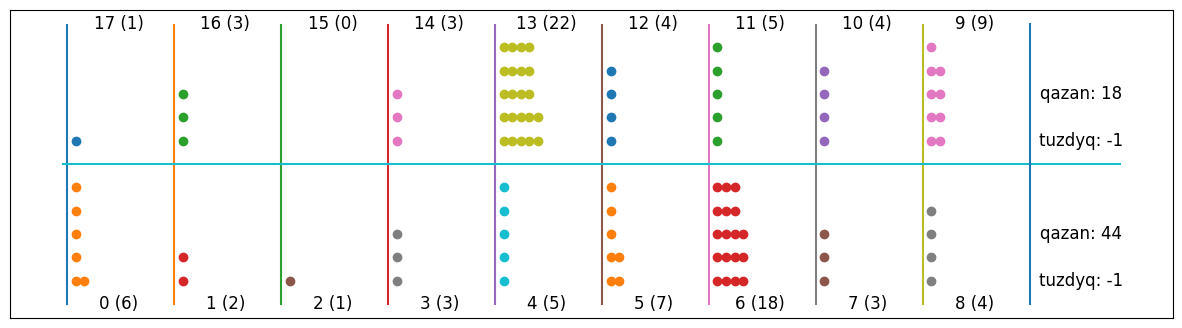

Please enter your action with mask [True, True, True, True, True, True, False, True, True] or press q for quit:


 8


MOVE #22
qostaushy made action 17
qostaushy won total 0


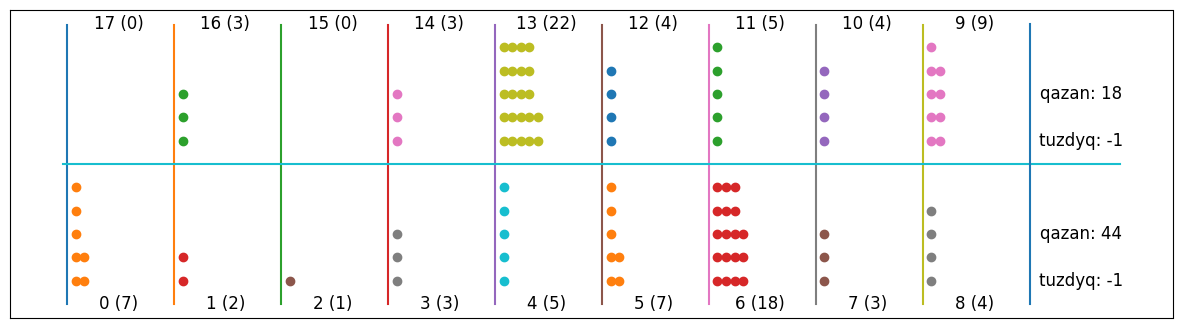

MOVE #23
bastaushy made action 4
bastaushy won total 0


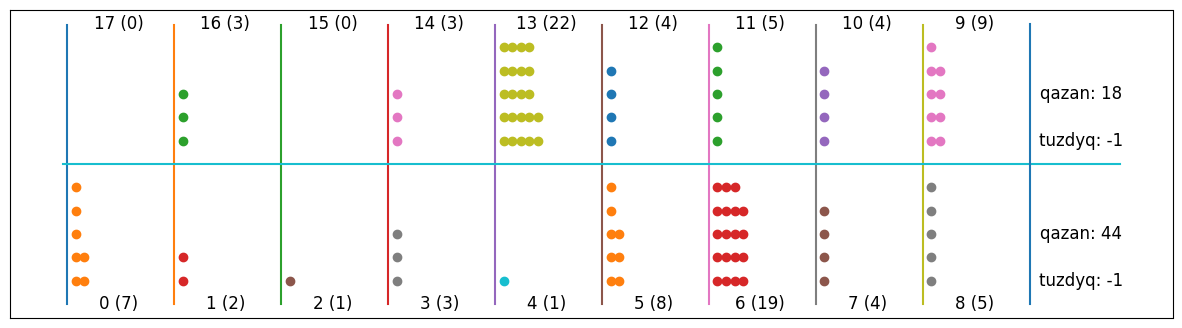

Please enter your action with mask [True, True, True, True, True, True, False, True, False] or press q for quit:


 7


MOVE #24
qostaushy made action 16
qostaushy won 8
qostaushy won total 8


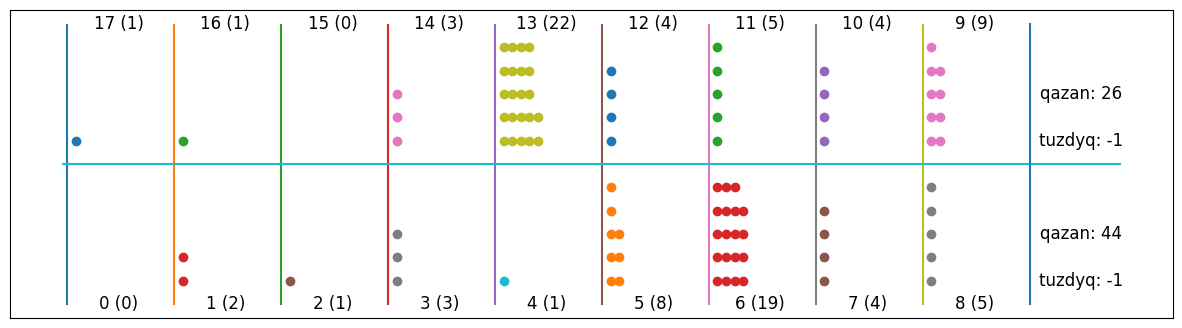

MOVE #25
bastaushy made action 8
bastaushy won total 0


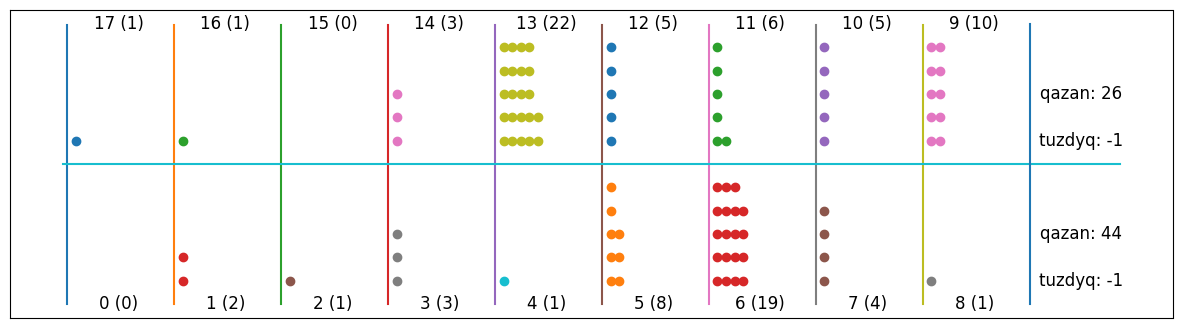

Please enter your action with mask [True, True, True, True, True, True, False, True, True] or press q for quit:


 1


MOVE #26
qostaushy made action 10
qostaushy won total 0


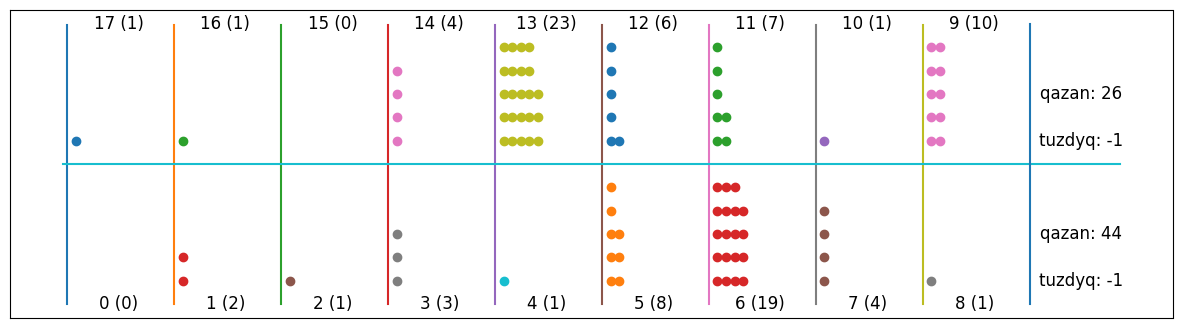

MOVE #27
bastaushy made action 5
bastaushy won total 0


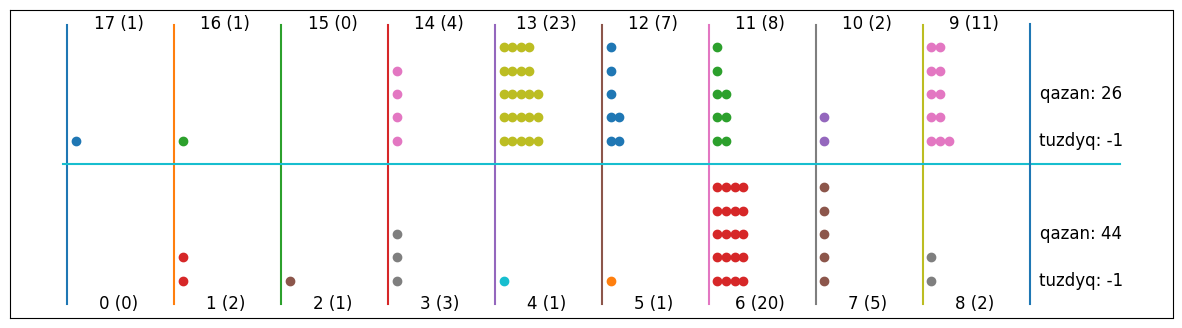

Please enter your action with mask [True, True, True, True, True, True, False, True, True] or press q for quit:


 2


MOVE #28
qostaushy made action 11
qostaushy won total 0


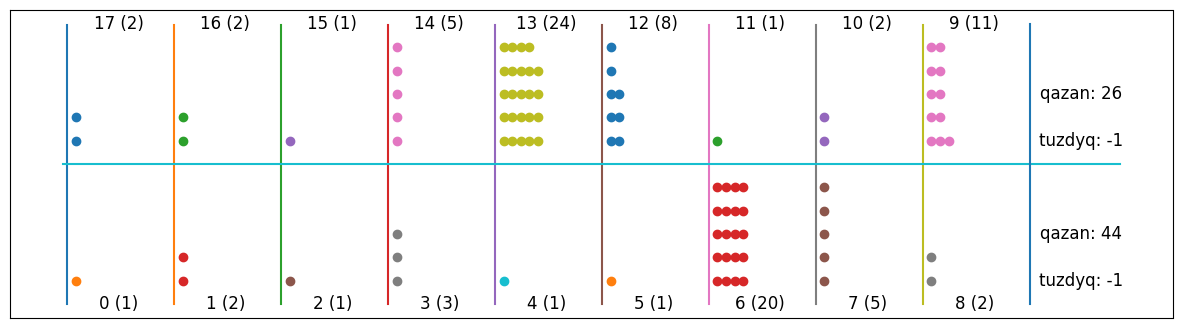

MOVE #29
bastaushy made action 8
bastaushy won 12
bastaushy won total 12


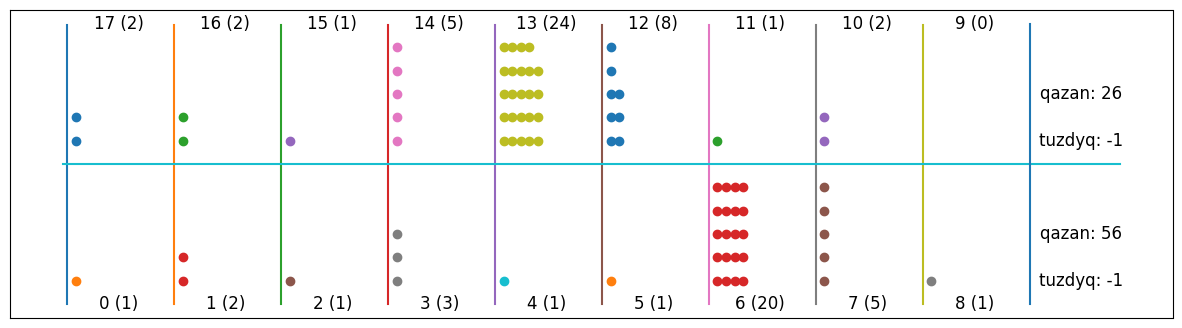

Please enter your action with mask [False, True, True, True, True, True, True, True, True] or press q for quit:


 8


MOVE #30
qostaushy made action 17
qostaushy won 2
qostaushy won total 2


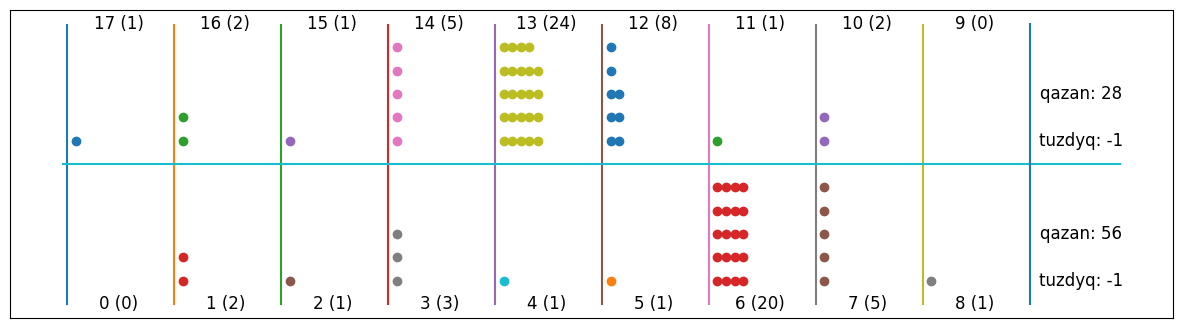

MOVE #31
bastaushy made action 7
bastaushy won 2
bastaushy won total 2


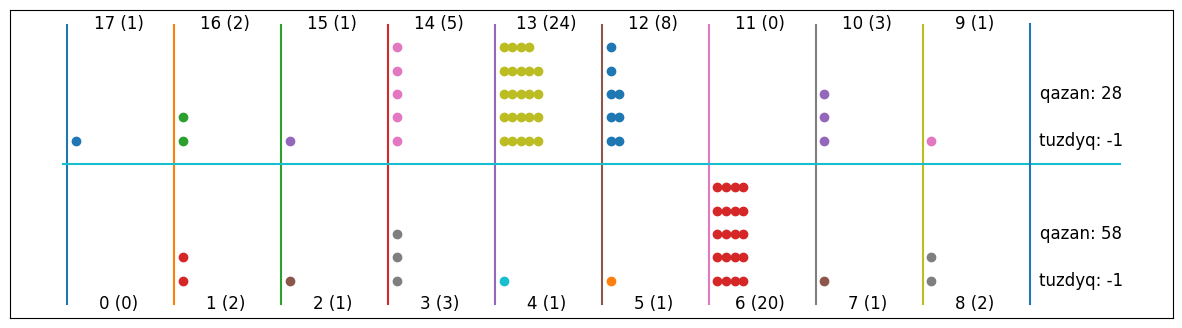

Please enter your action with mask [True, True, False, True, True, True, True, True, True] or press q for quit:


 3


MOVE #32
qostaushy made action 12
qostaushy got tuzdyq 1!
qostaushy won tuzdyq 3
qostaushy won total 3


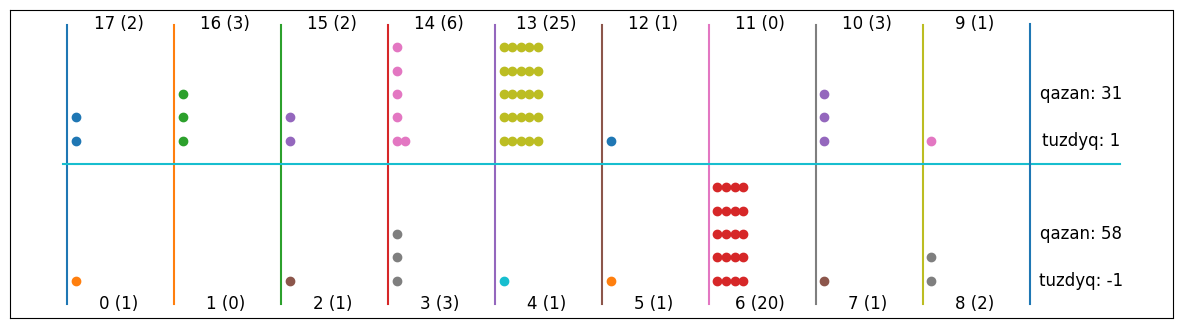

MOVE #33
bastaushy made action 8
bastaushy won 2
bastaushy won total 2


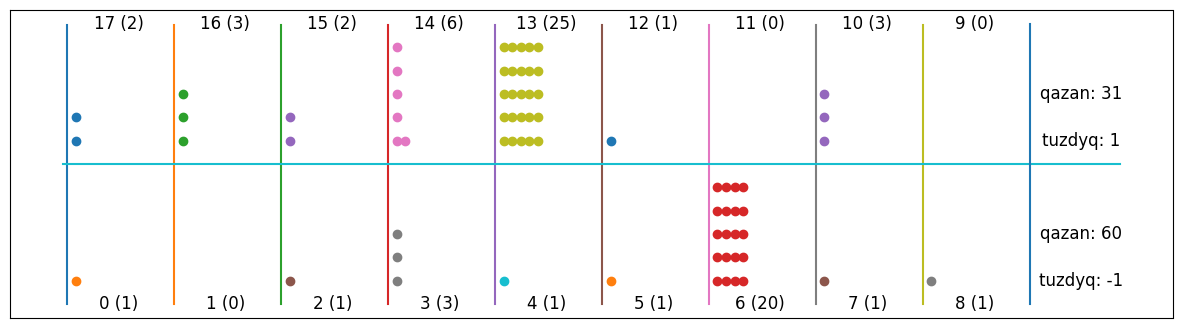

Please enter your action with mask [False, True, False, True, True, True, True, True, True] or press q for quit:


 7


MOVE #34
qostaushy made action 16
qostaushy won 2
qostaushy won total 2


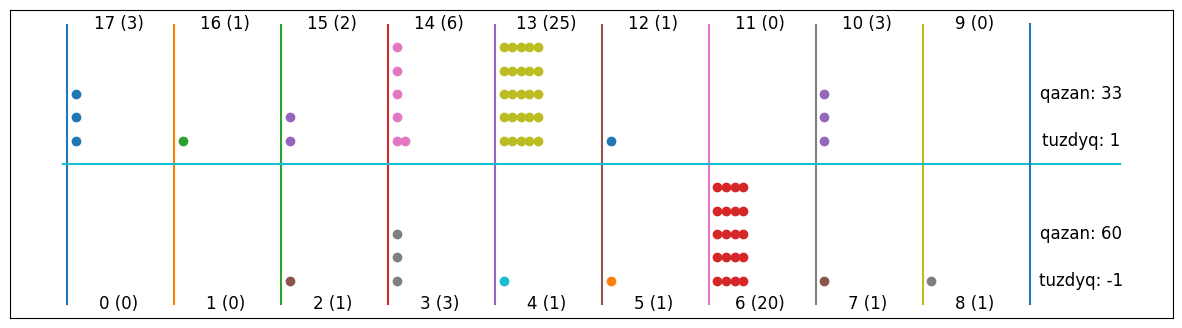

MOVE #35
bastaushy made action 3
bastaushy won total 0


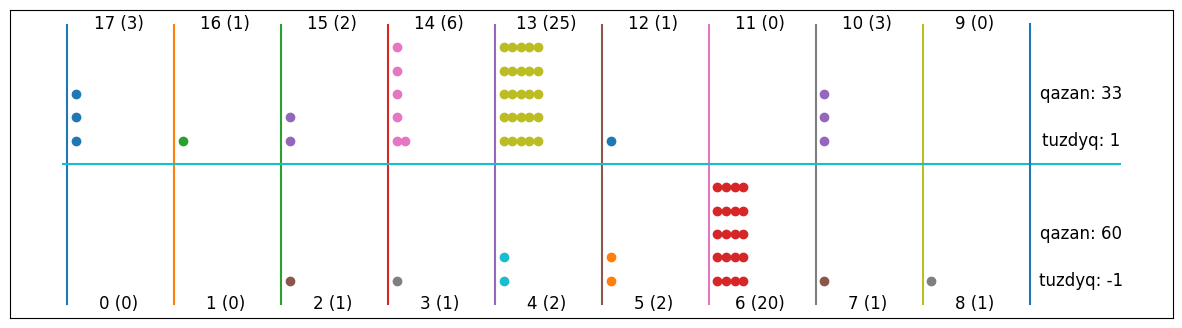

Please enter your action with mask [False, True, False, True, True, True, True, True, True] or press q for quit:


 5


MOVE #36
qostaushy made action 14
qostaushy won tuzdyq 1
qostaushy won total 1


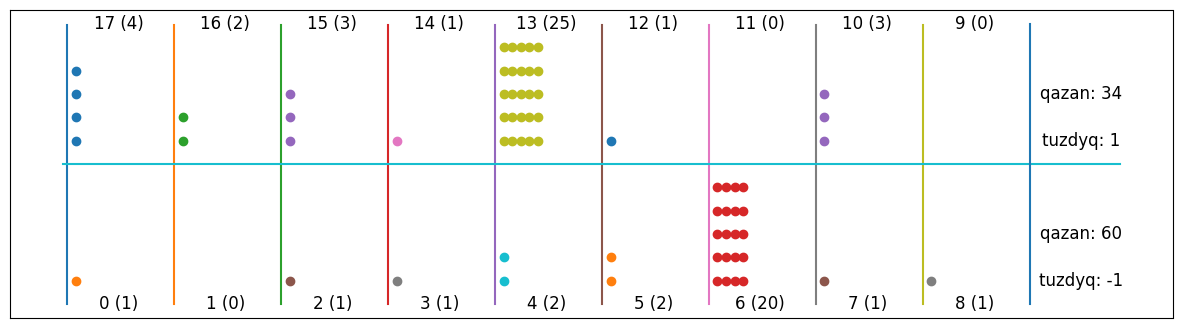

MOVE #37
bastaushy made action 7
bastaushy won total 0


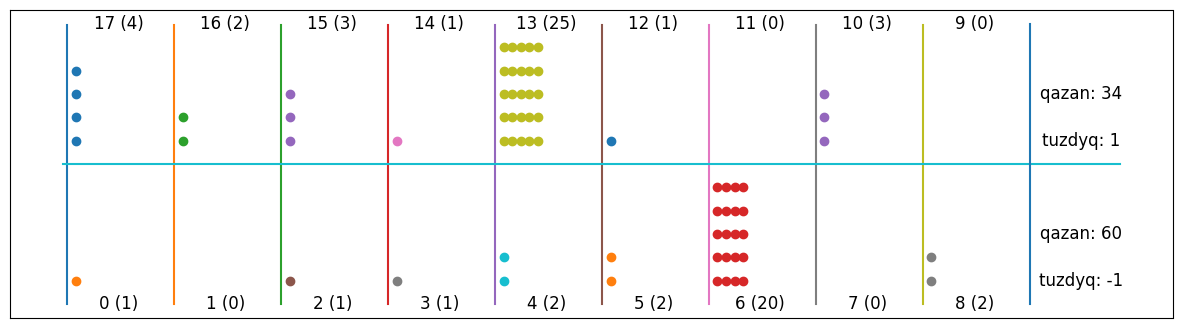

Please enter your action with mask [False, True, False, True, True, True, True, True, True] or press q for quit:


 8


MOVE #38
qostaushy made action 17
qostaushy won 2
qostaushy won tuzdyq 1
qostaushy won total 3


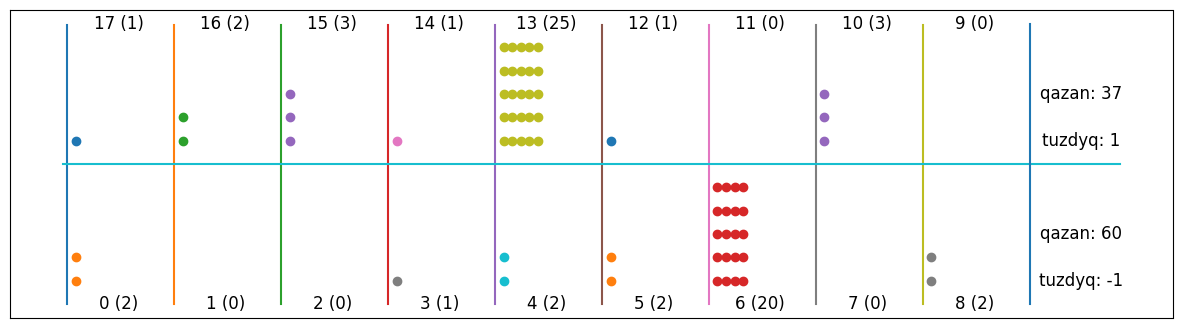

MOVE #39
bastaushy made action 8
bastaushy won total 0


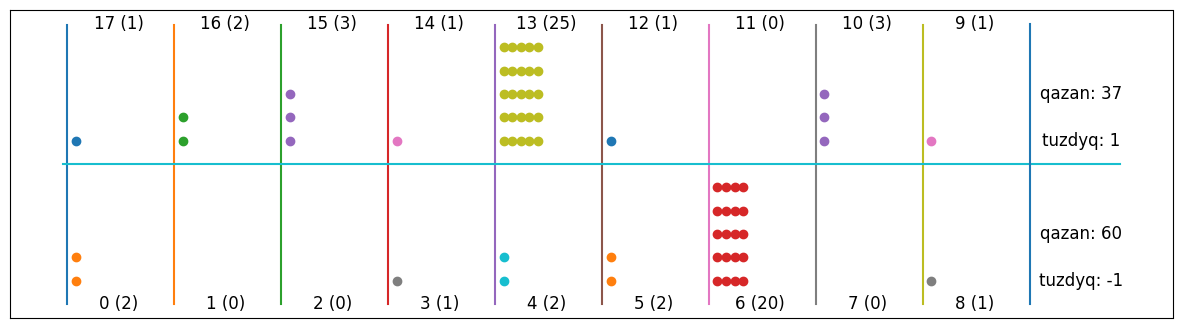

Please enter your action with mask [True, True, False, True, True, True, True, True, True] or press q for quit:


 4


MOVE #40
qostaushy made action 13
qostaushy won 2
qostaushy won total 2


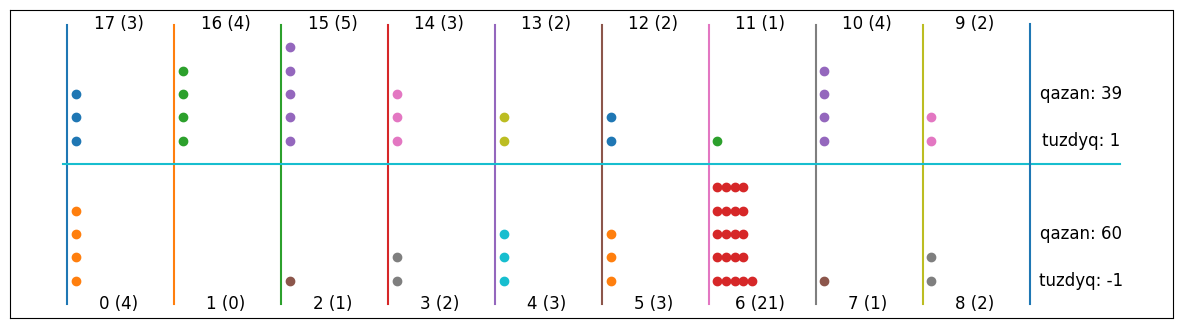

MOVE #41
bastaushy made action 6
bastaushy won total 0


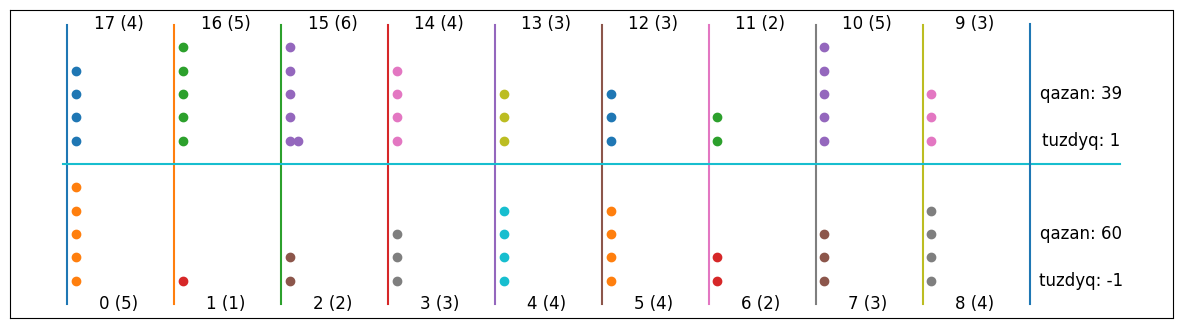

Please enter your action with mask [True, True, True, True, True, True, True, True, True] or press q for quit:


 6


MOVE #42
qostaushy made action 15
qostaushy won tuzdyq 2
qostaushy won total 2


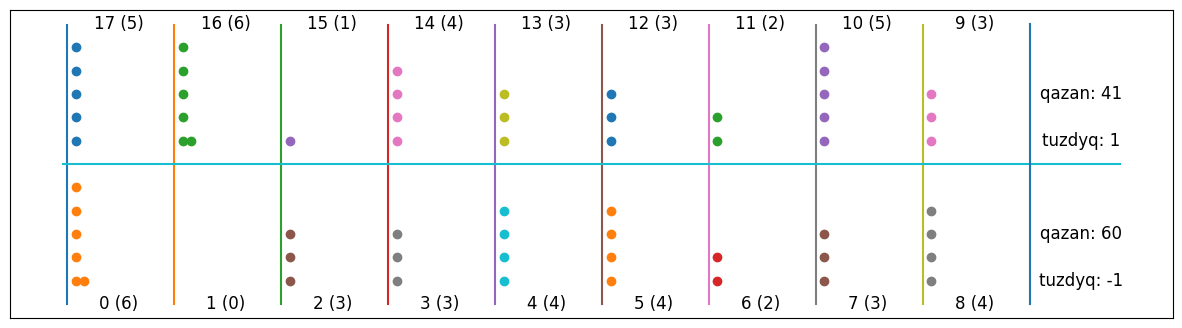

MOVE #43
bastaushy made action 8
bastaushy got tuzdyq 11!
bastaushy won tuzdyq 3
bastaushy won total 3


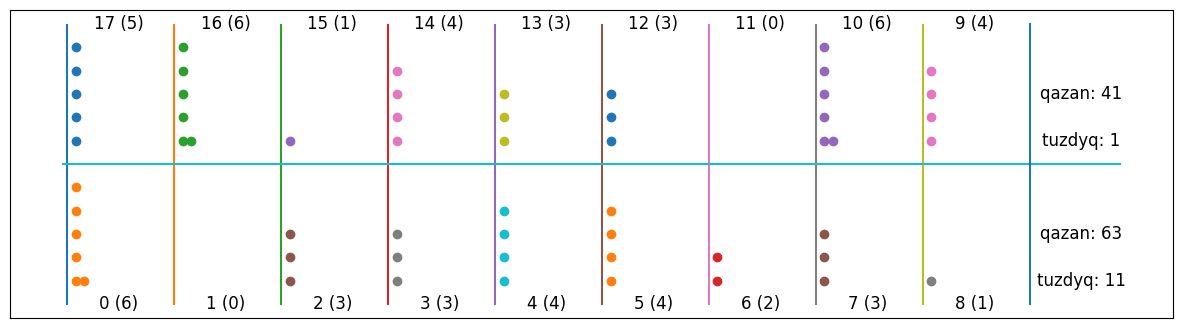

Please enter your action with mask [True, True, False, True, True, True, True, True, True] or press q for quit:


 7


MOVE #44
qostaushy made action 16
qostaushy won 4
qostaushy won tuzdyq 1
qostaushy won total 5


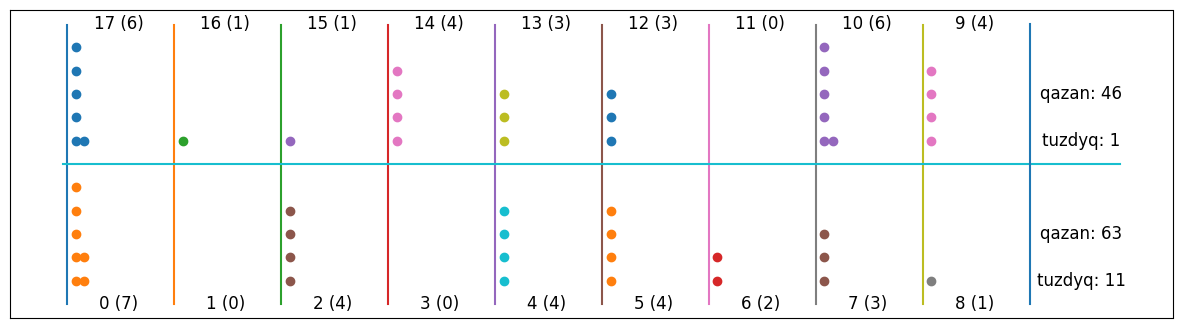

MOVE #45
bastaushy made action 0
bastaushy won total 0


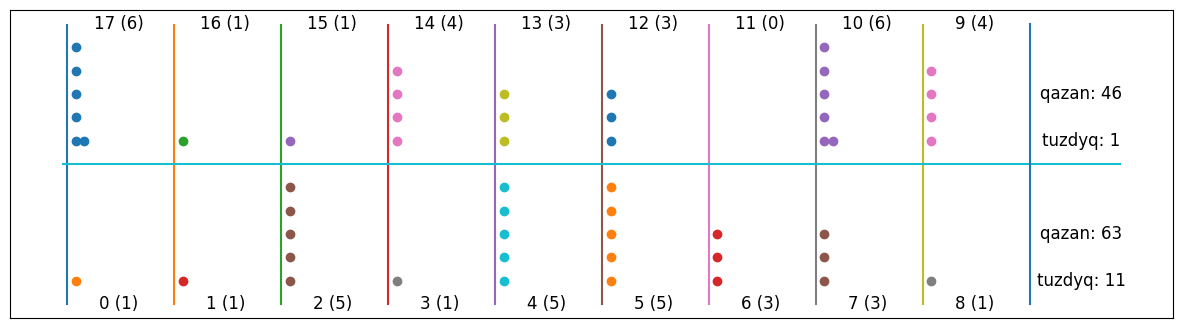

Please enter your action with mask [True, True, False, True, True, True, True, True, True] or press q for quit:


 8


MOVE #46
qostaushy made action 17
qostaushy won 6
qostaushy won tuzdyq 2
qostaushy won total 8


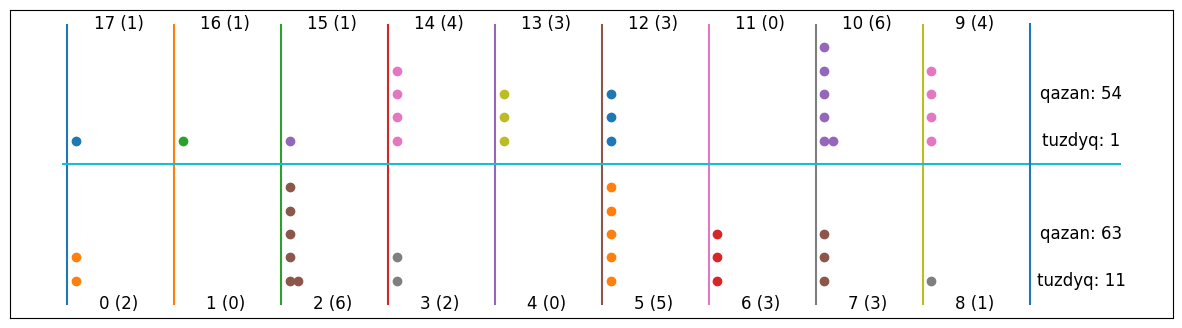

MOVE #47
bastaushy made action 2
bastaushy won total 0


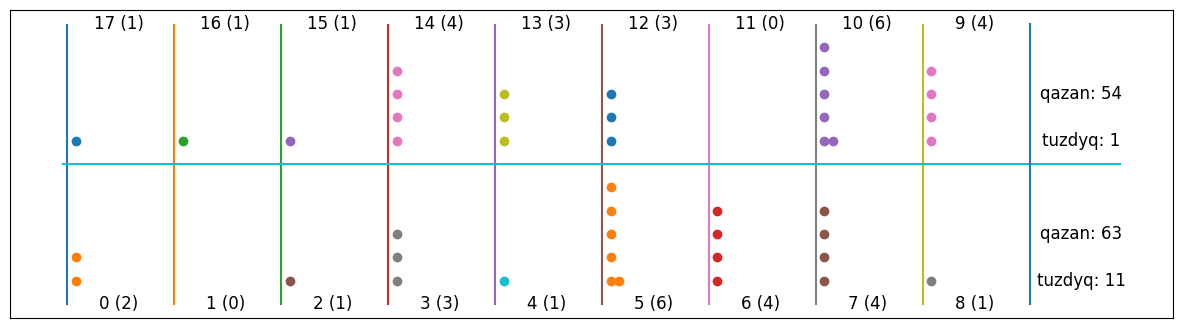

Please enter your action with mask [True, True, False, True, True, True, True, True, True] or press q for quit:


 1


MOVE #48
qostaushy made action 10
qostaushy won total 0


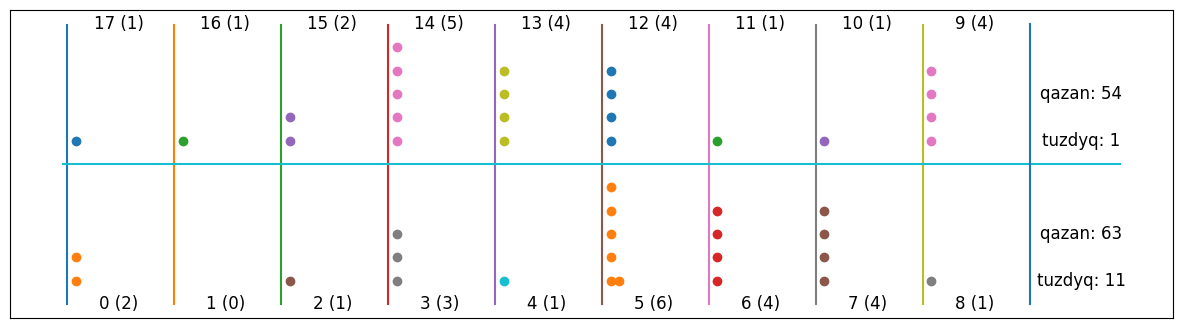

MOVE #49
bastaushy made action 5
bastaushy won 2
bastaushy won tuzdyq 1
bastaushy won total 3


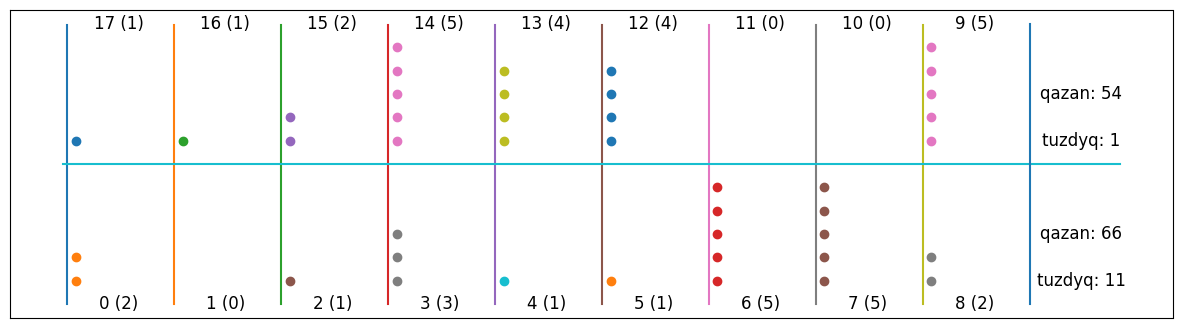

Please enter your action with mask [True, False, False, True, True, True, True, True, True] or press q for quit:


 8


MOVE #50
qostaushy made action 17
qostaushy won total 0


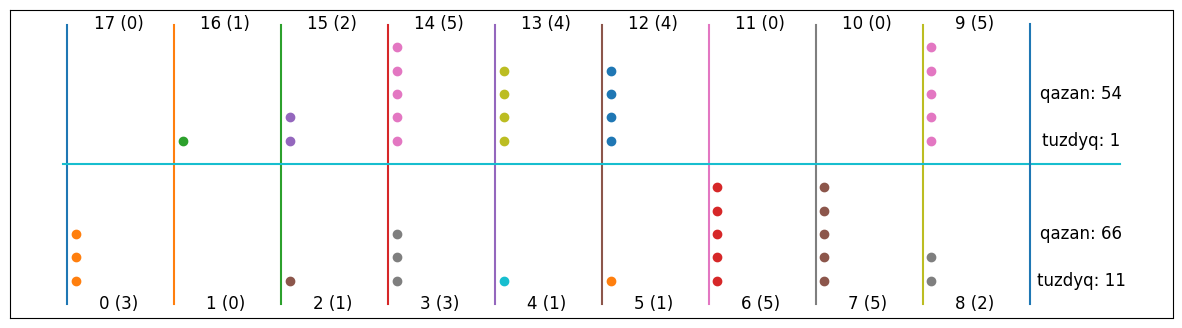

MOVE #51
bastaushy made action 8
bastaushy won 6
bastaushy won total 6


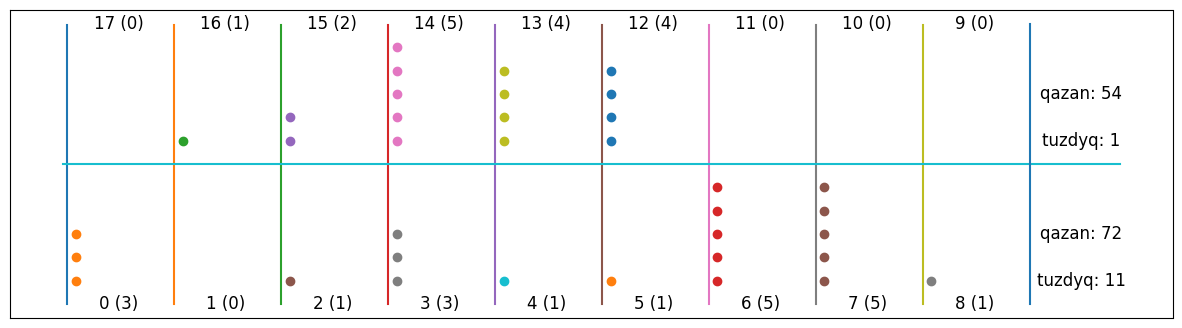

Please enter your action with mask [False, False, False, True, True, True, True, True, False] or press q for quit:


 5


MOVE #52
qostaushy made action 14
qostaushy won 4
qostaushy won total 4


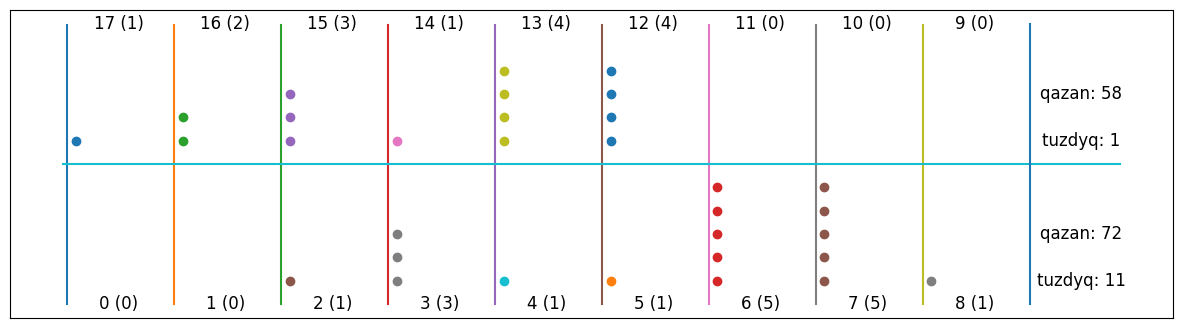

MOVE #53
bastaushy made action 7
bastaushy won tuzdyq 1
bastaushy won total 1


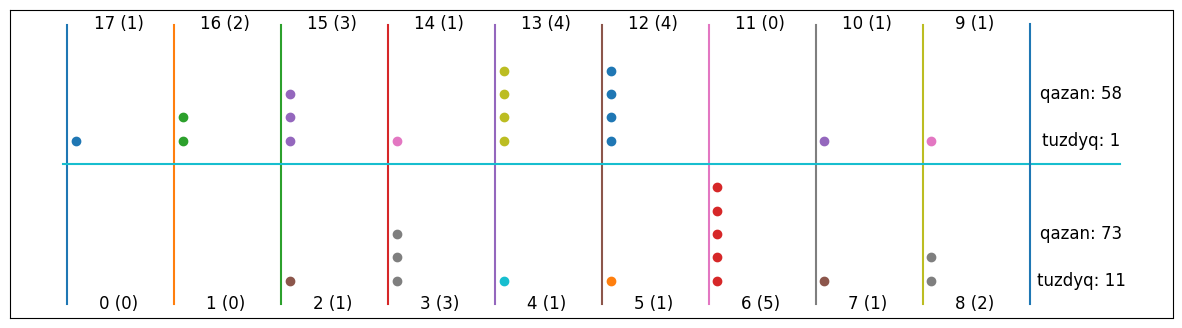

Please enter your action with mask [True, True, False, True, True, True, True, True, True] or press q for quit:


 3


MOVE #54
qostaushy made action 12
qostaushy won total 0


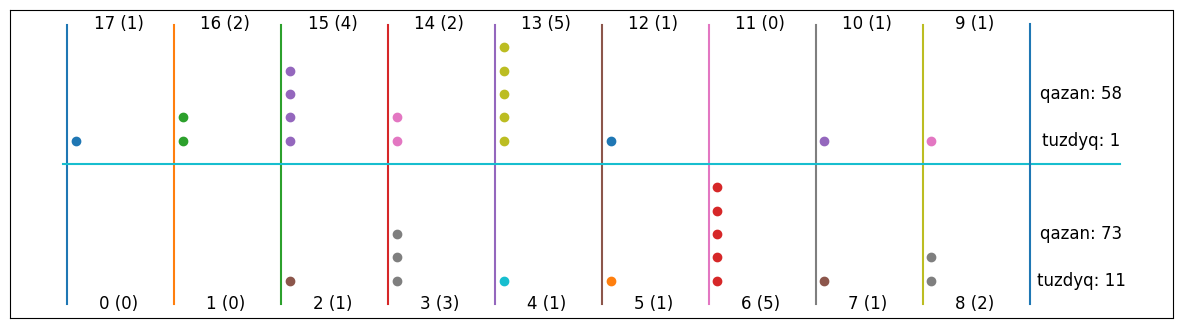

MOVE #55
bastaushy made action 3
bastaushy won total 0


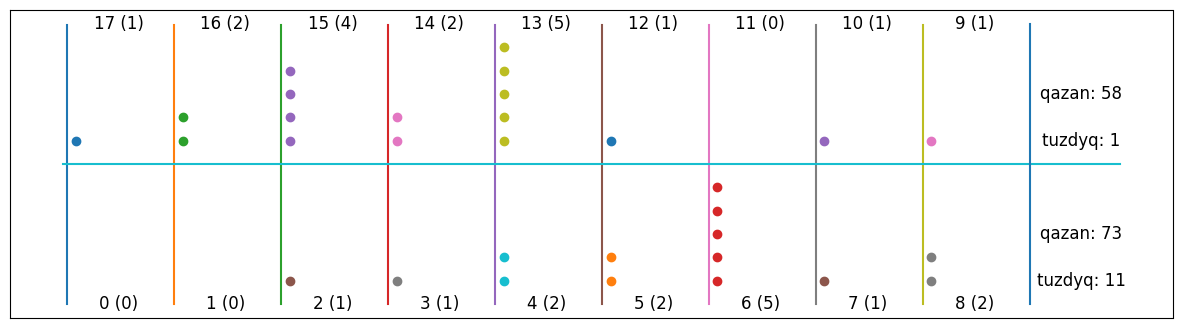

Please enter your action with mask [True, True, False, True, True, True, True, True, True] or press q for quit:


 7


MOVE #56
qostaushy made action 16
qostaushy won total 0


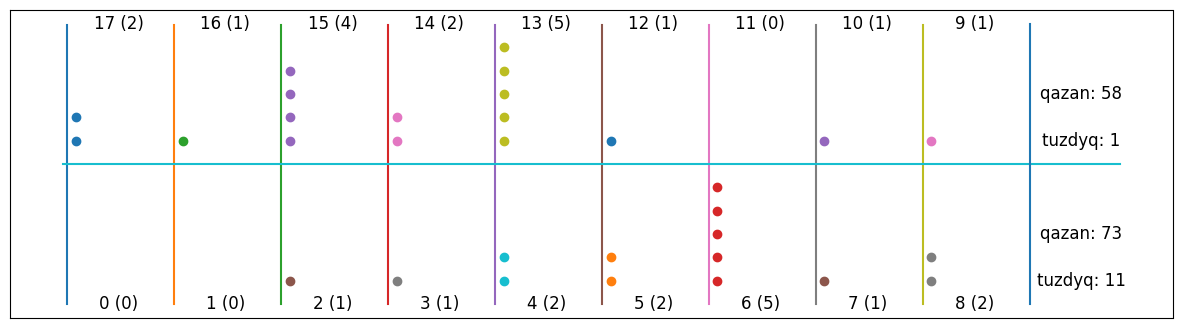

MOVE #57
bastaushy made action 6
bastaushy won 2
bastaushy won total 2


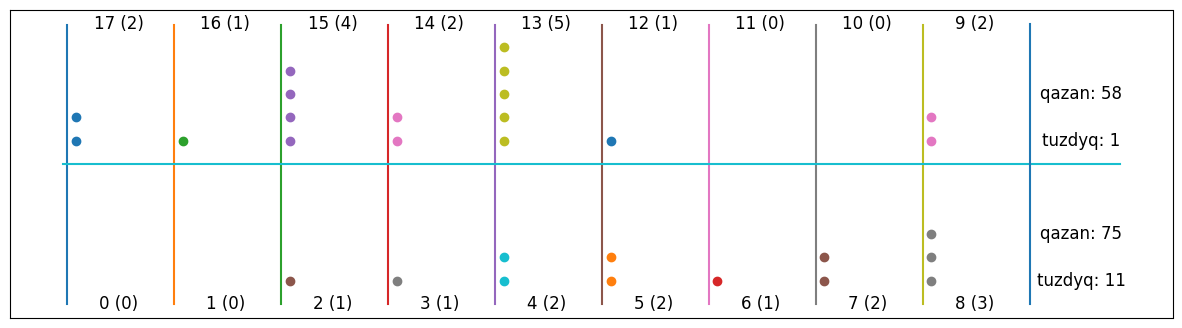

Please enter your action with mask [True, False, False, True, True, True, True, True, True] or press q for quit:


 5


MOVE #58
qostaushy made action 14
qostaushy won total 0


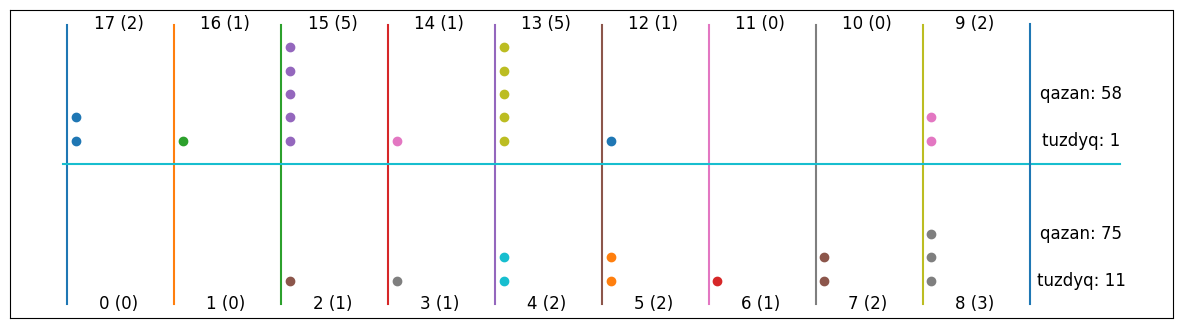

MOVE #59
bastaushy made action 8
bastaushy won total 0


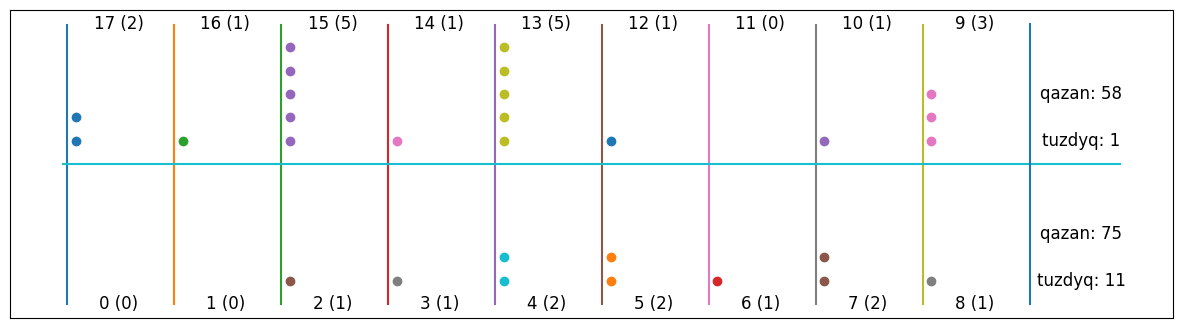

Please enter your action with mask [True, True, False, True, True, True, True, True, True] or press q for quit:


 7


MOVE #60
qostaushy made action 16
qostaushy won total 0


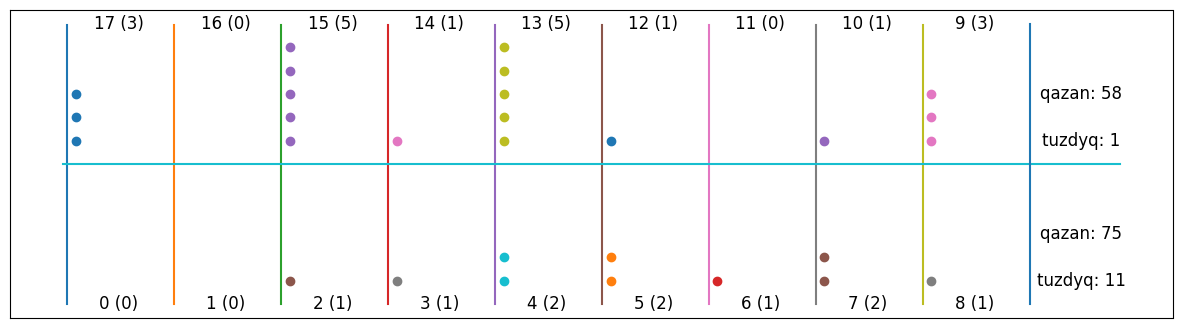

MOVE #61
bastaushy made action 7
bastaushy won total 0


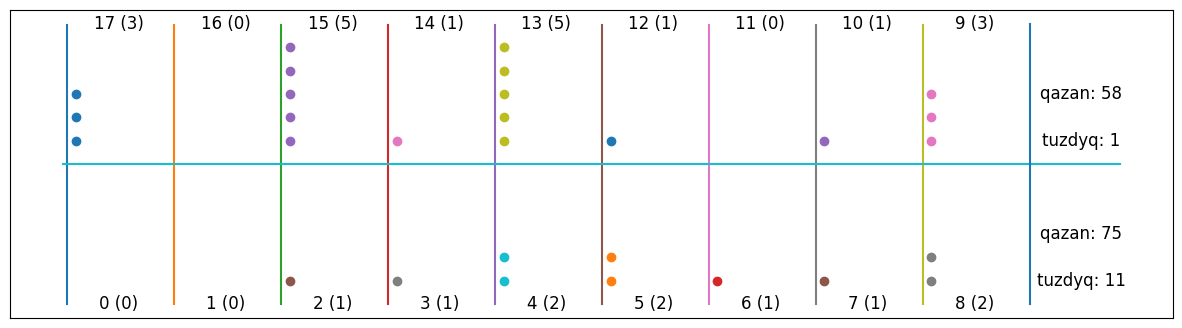

Please enter your action with mask [True, True, False, True, True, True, True, False, True] or press q for quit:


 5


MOVE #62
qostaushy made action 14
qostaushy won total 0


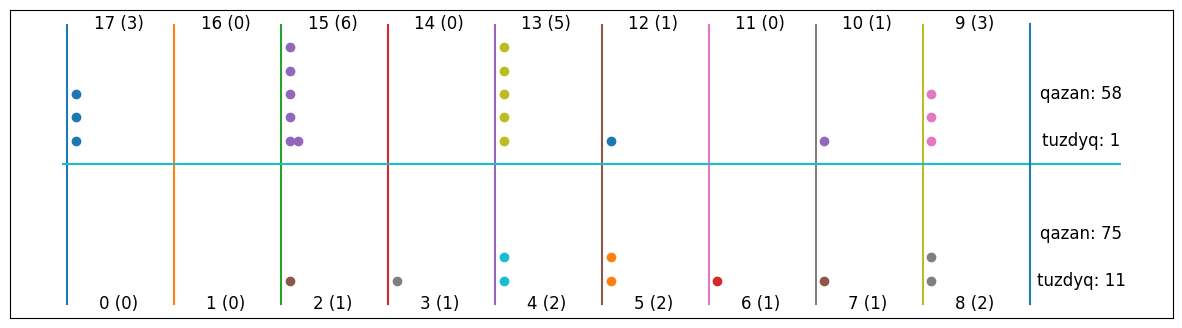

MOVE #63
bastaushy made action 7
bastaushy won total 0


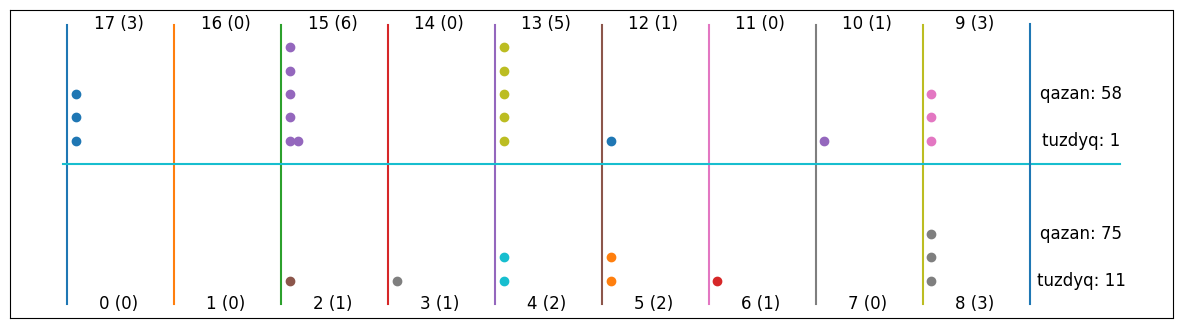

Please enter your action with mask [True, True, False, True, True, False, True, False, True] or press q for quit:


 6


MOVE #64
qostaushy made action 15
qostaushy won 2
qostaushy won tuzdyq 1
qostaushy won total 3


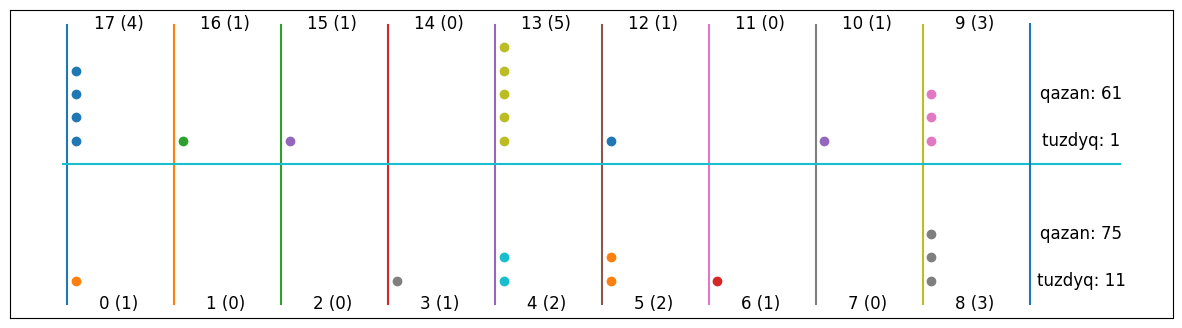

MOVE #65
bastaushy made action 8
bastaushy won 2
bastaushy won total 2


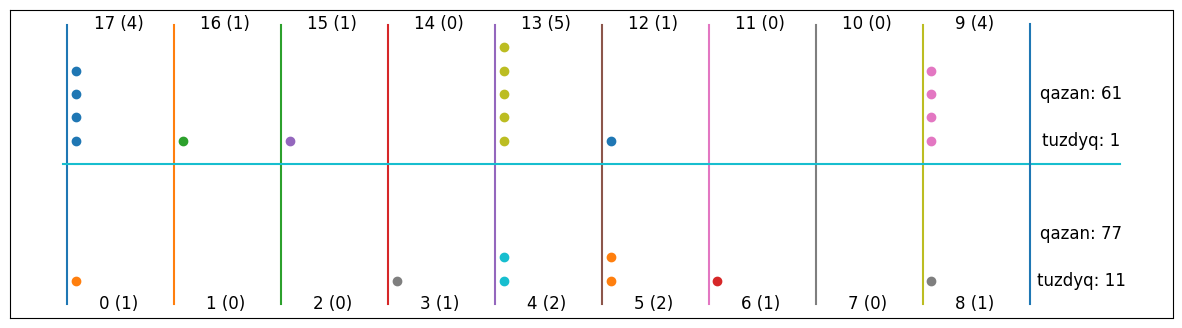

Please enter your action with mask [True, False, False, True, True, False, True, True, True] or press q for quit:


 4


MOVE #66
qostaushy made action 13
qostaushy won total 0


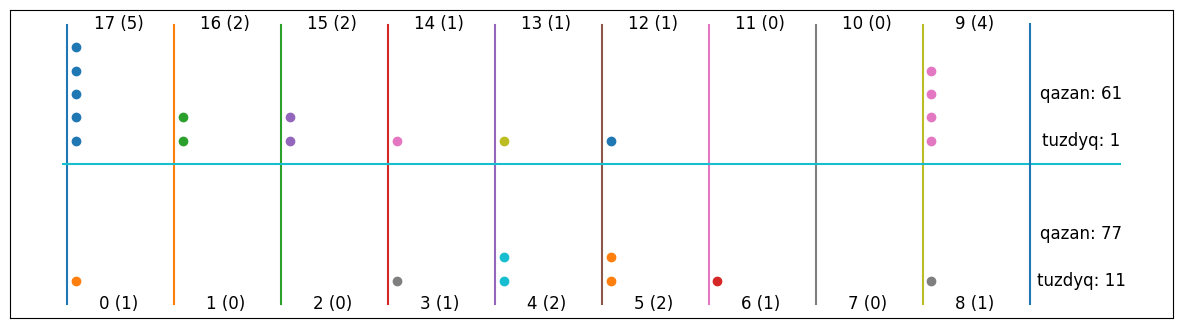

MOVE #67
bastaushy made action 5
bastaushy won total 0


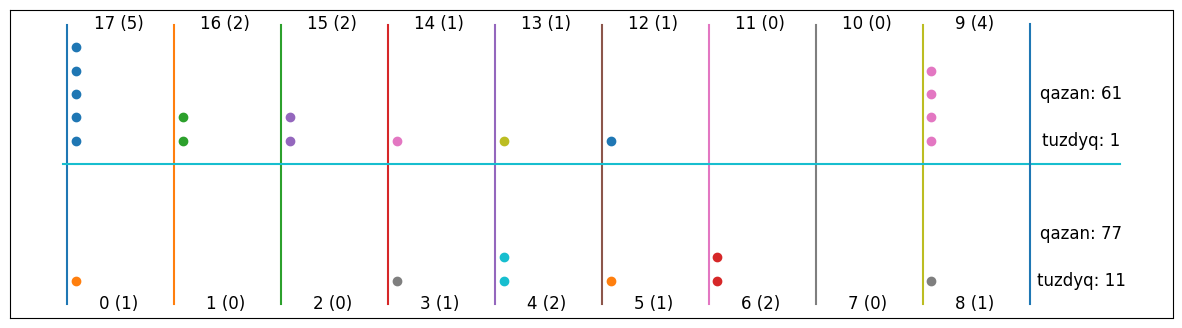

Please enter your action with mask [True, False, False, True, True, True, True, True, True] or press q for quit:


 8


MOVE #68
qostaushy made action 17
qostaushy won 2
qostaushy won tuzdyq 1
qostaushy won total 3


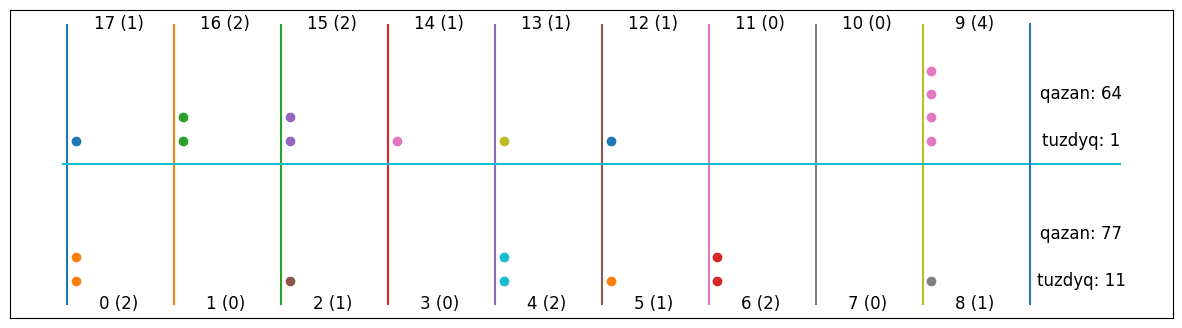

MOVE #69
bastaushy made action 5
bastaushy won total 0


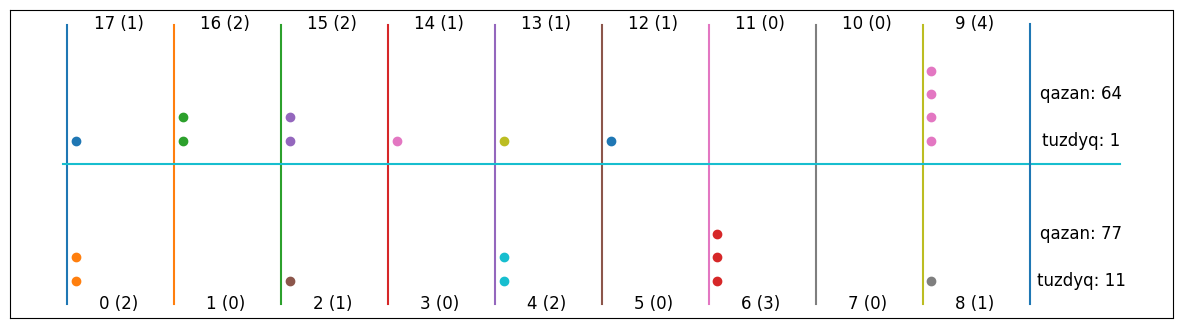

Please enter your action with mask [True, False, False, True, True, True, True, True, True] or press q for quit:


 6


MOVE #70
qostaushy made action 15
qostaushy won total 0


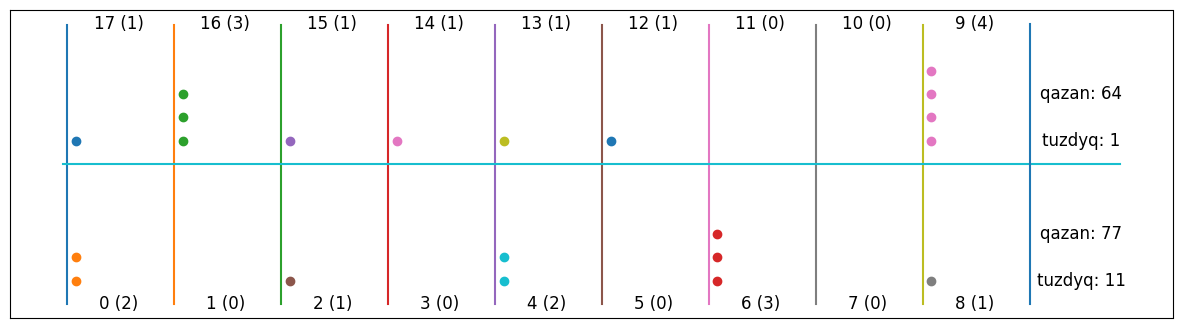

MOVE #71
bastaushy made action 8
bastaushy won total 0


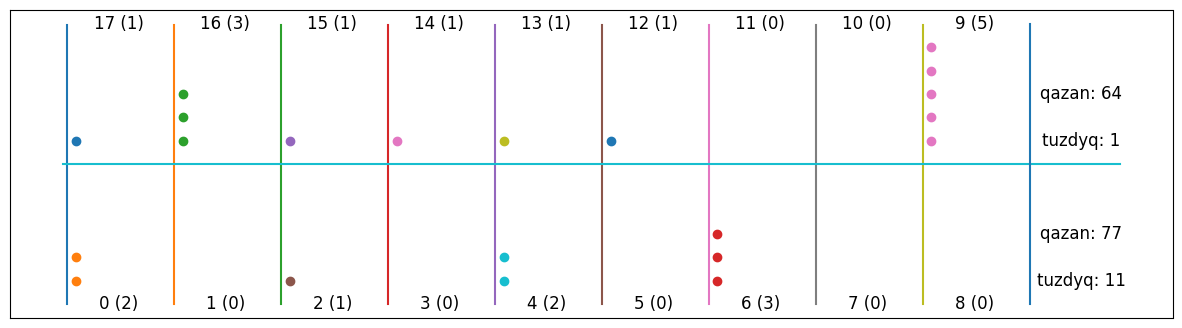

Please enter your action with mask [True, False, False, True, True, True, True, True, True] or press q for quit:


 3


MOVE #72
qostaushy made action 12
qostaushy won total 0


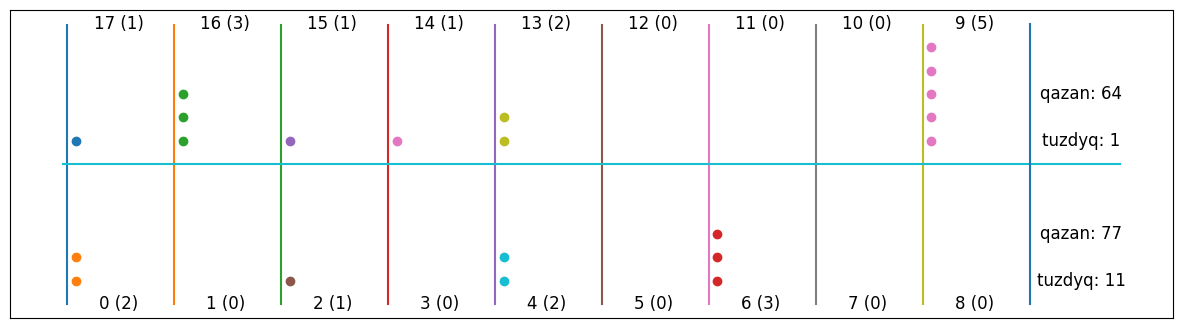

MOVE #73
bastaushy made action 4
bastaushy won total 0


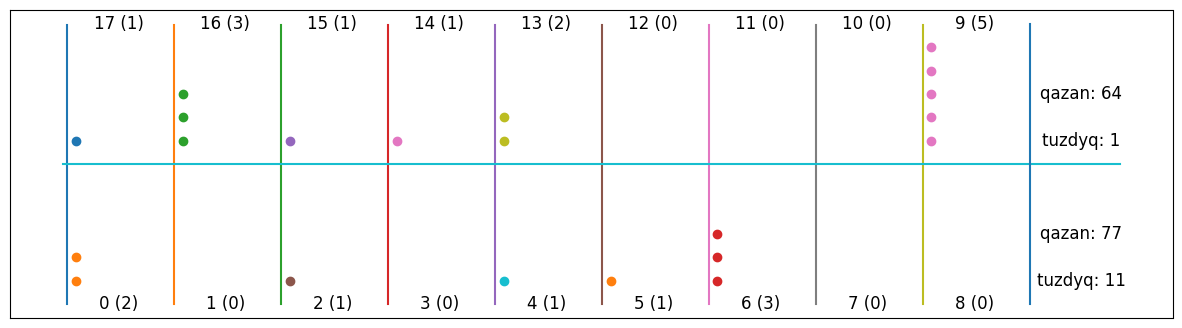

Please enter your action with mask [True, False, False, False, True, True, True, True, True] or press q for quit:


 5


MOVE #74
qostaushy made action 14
qostaushy won total 0


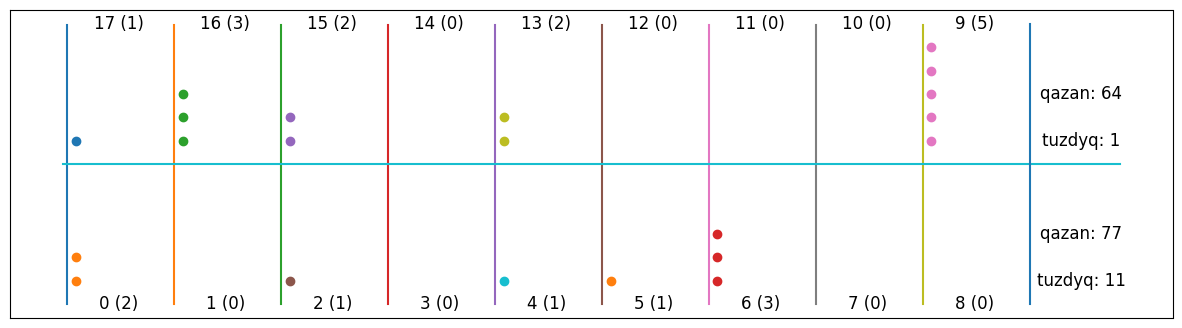

MOVE #75
bastaushy made action 5
bastaushy won total 0


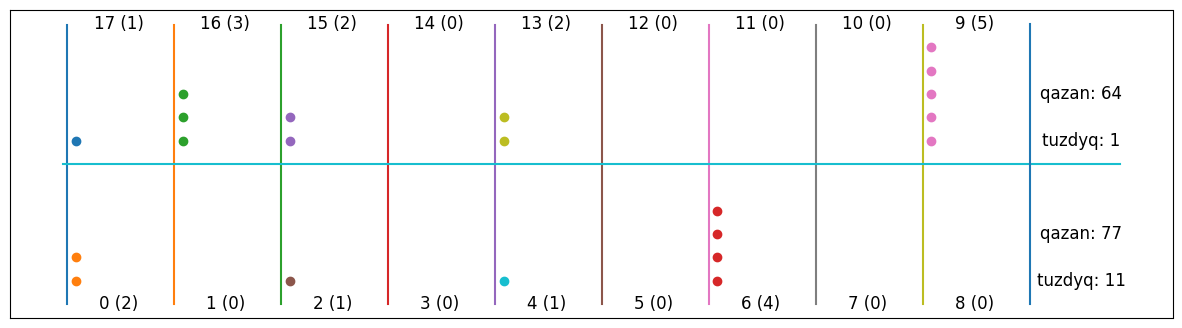

Please enter your action with mask [True, False, False, False, True, False, True, True, True] or press q for quit:


 6


MOVE #76
qostaushy made action 15
qostaushy won total 0


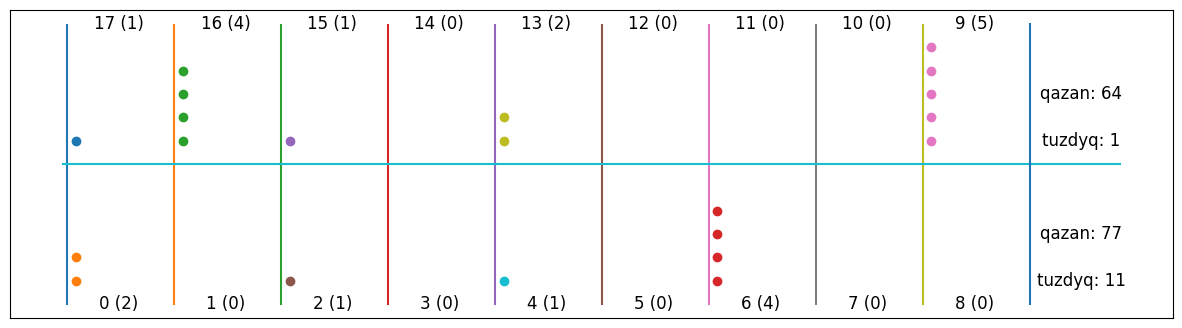

MOVE #77
bastaushy made action 6
bastaushy won 6
bastaushy won total 6
bastaushy won the game!!!


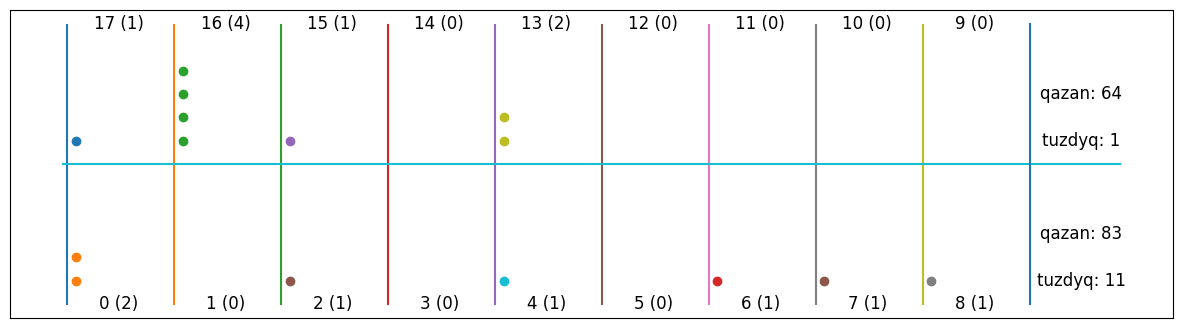

Please enter your action with mask [False, False, False, False, True, False, True, True, True] or press q for quit:


KeyboardInterrupt: Interrupted by user

In [15]:
#Play with LEVEL 2 TheNineQ mobile game
play = True 
env = _get_env(render_mode="human")
obs = env.reset()[0]
mask = obs['mask']

while play:
    flag = True
    
    batch = Batch(obs=Batch(agent_id=obs['agent_id'], obs=[obs['obs']], mask=[obs['mask']]), info='?')
    agent_trained.eval()
    
    act = agent_trained(batch=batch).act.item()
    obs, rewards, term, trunc, _ = env.step(act)
    mask = obs['mask']
    while flag:
        print(f"Please enter your action with mask {mask} or press q for quit:")
        human_act = input()
        if int(human_act) in [i for i in range(9) if mask[i]]:
            flag = False
        else:
            flag = True
    if human_act == 'q':
        play = False
        break

    obs, rewards, term, trunc, _ = env.step(int(human_act))
    
env.close()

MOVE #1
bastaushy made action 0
bastaushy won total 0


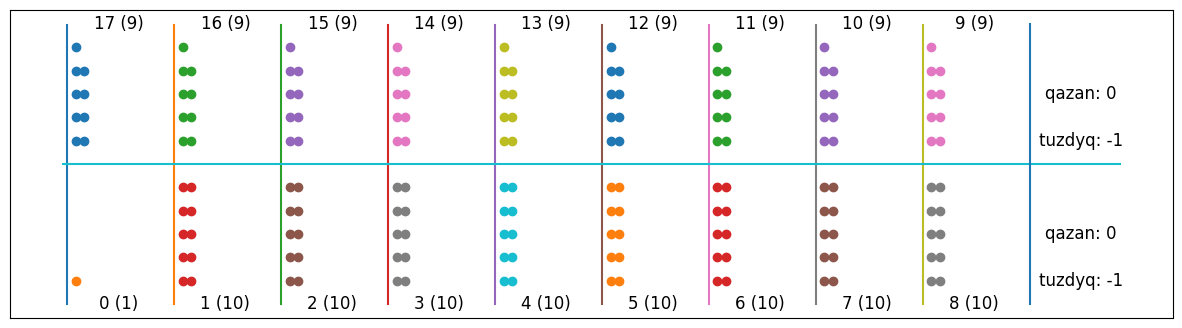

Please enter your action with mask [True, True, True, True, True, True, True, True, True] or press q for quit:


 1


MOVE #2
qostaushy made action 10
qostaushy won 2
qostaushy won total 2


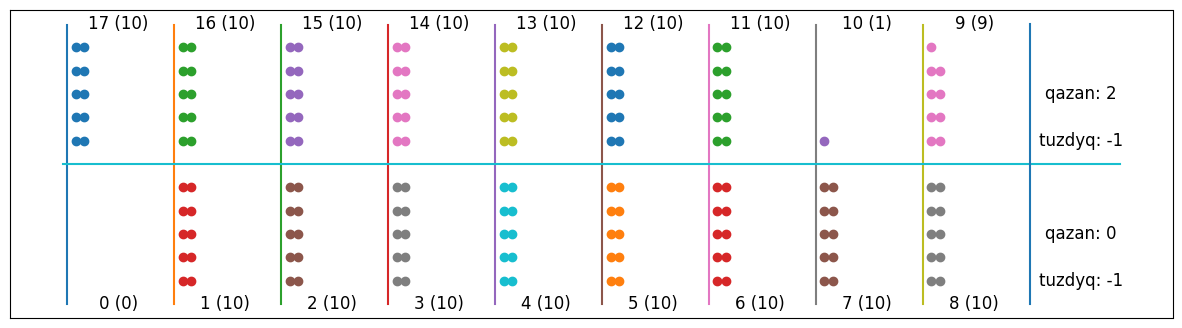

MOVE #3
bastaushy made action 8
bastaushy won total 0


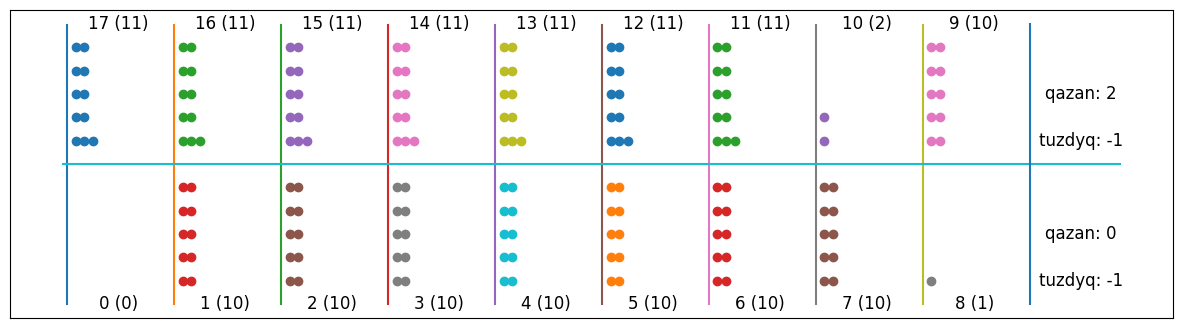

Please enter your action with mask [True, True, True, True, True, True, True, True, True] or press q for quit:


 7


MOVE #4
qostaushy made action 16
qostaushy won 2
qostaushy won total 2


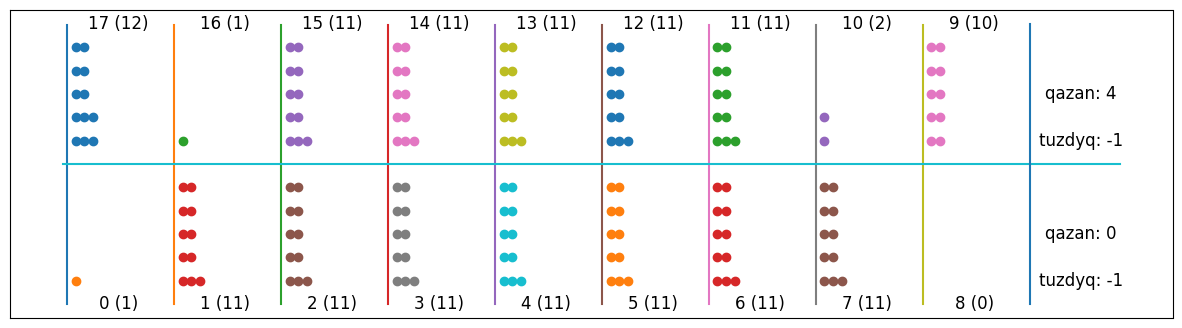

MOVE #5
bastaushy made action 7
bastaushy won total 0


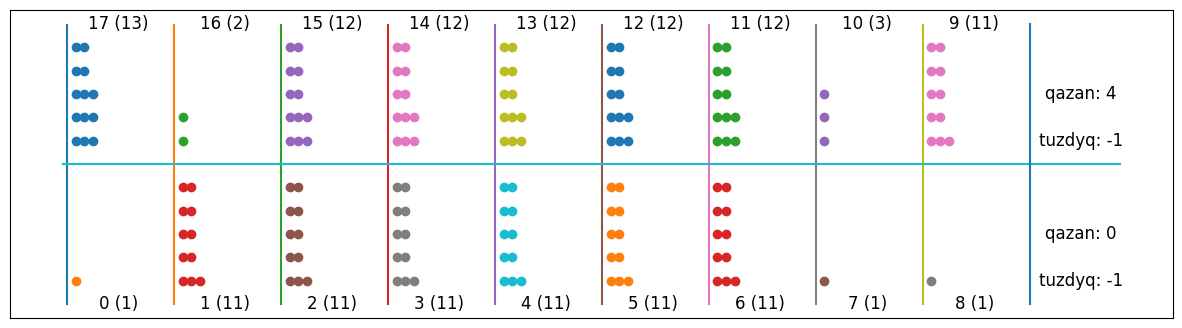

Please enter your action with mask [True, True, True, True, True, True, True, True, True] or press q for quit:


 0


MOVE #6
qostaushy made action 9
qostaushy won 12
qostaushy won total 12


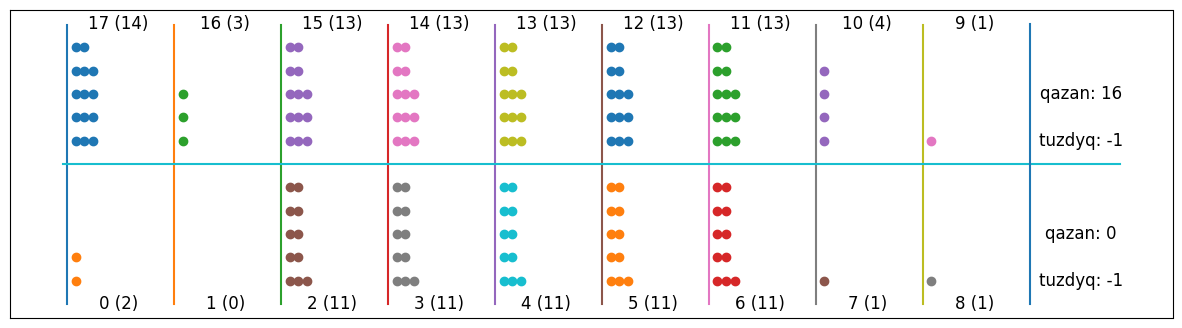

MOVE #7
bastaushy made action 5
bastaushy won 14
bastaushy won total 14


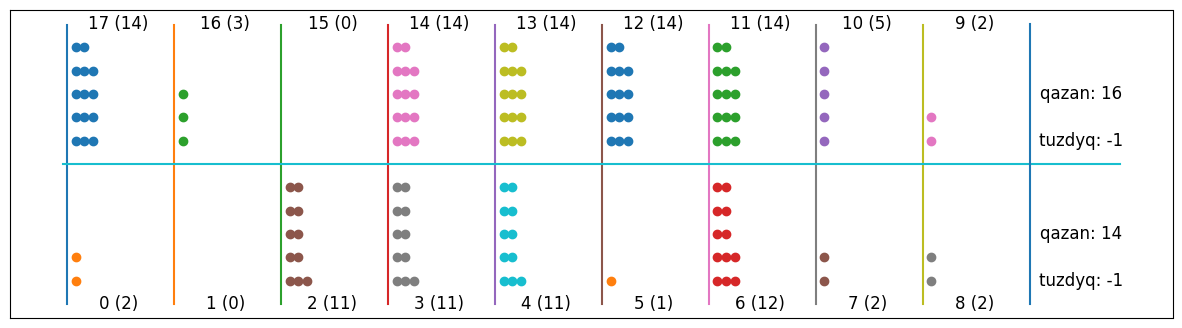

Please enter your action with mask [True, True, True, True, True, True, False, True, True] or press q for quit:


 0


MOVE #8
qostaushy made action 9
qostaushy won total 0


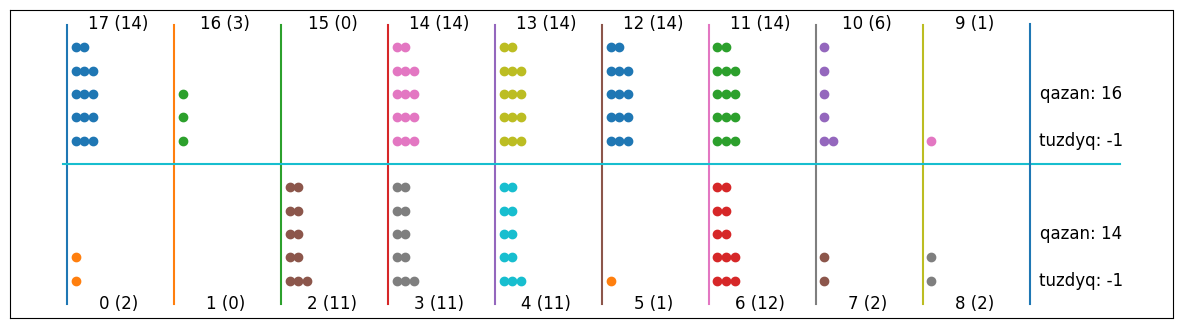

MOVE #9
bastaushy made action 2
bastaushy won total 0


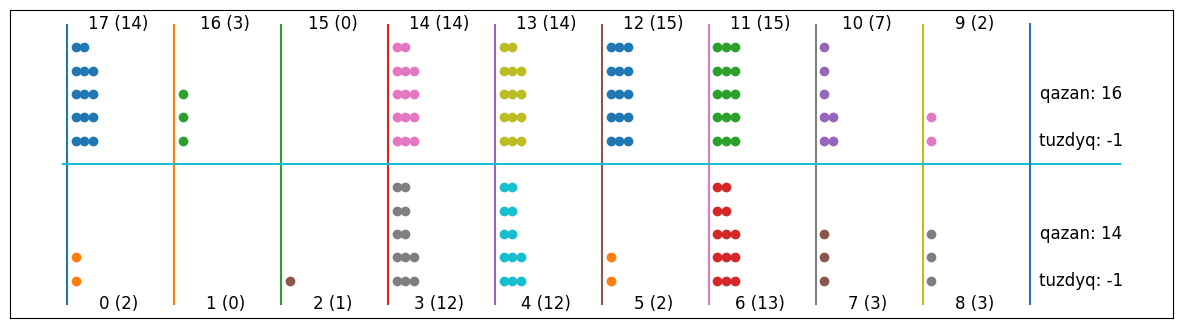

Please enter your action with mask [True, True, True, True, True, True, False, True, True] or press q for quit:


 2


MOVE #10
qostaushy made action 11
qostaushy won 4
qostaushy won total 4


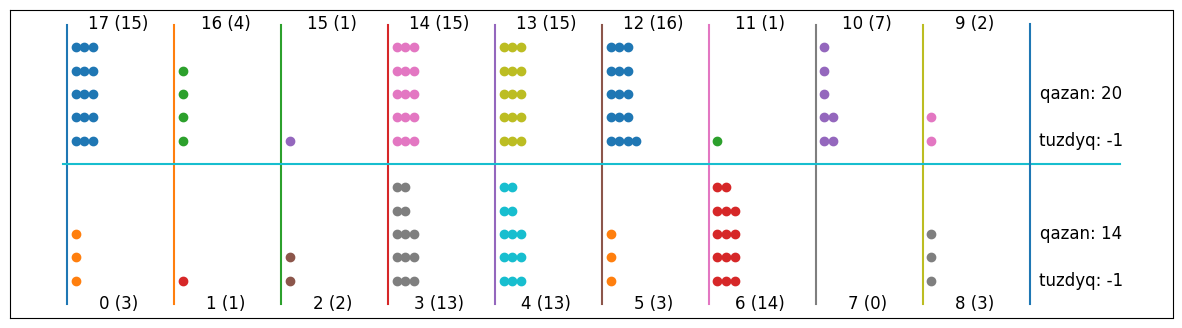

MOVE #11
bastaushy made action 4
bastaushy won total 0


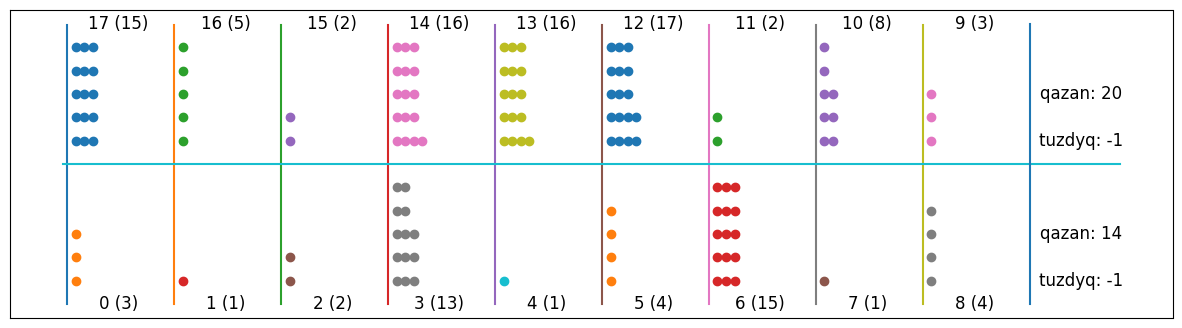

Please enter your action with mask [True, True, True, True, True, True, True, True, True] or press q for quit:


 2


MOVE #12
qostaushy made action 11
qostaushy won total 0


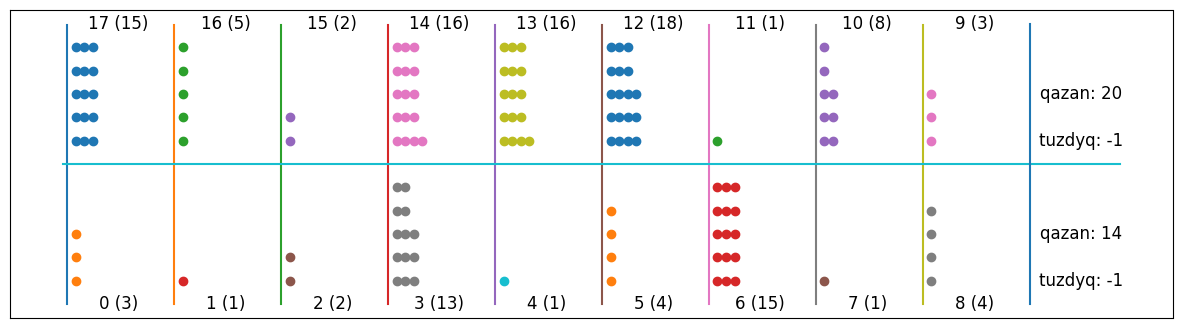

MOVE #13
bastaushy made action 3
bastaushy got tuzdyq 15!
bastaushy won tuzdyq 3
bastaushy won total 3


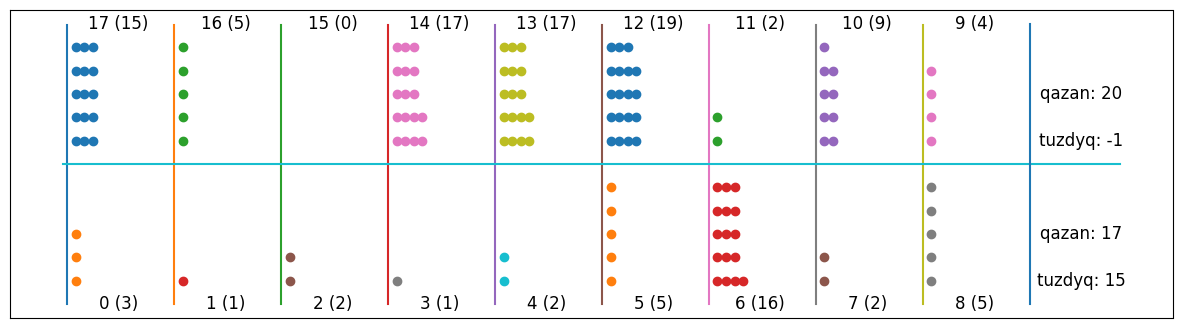

Please enter your action with mask [True, True, True, True, True, True, False, True, True] or press q for quit:


 1


MOVE #14
qostaushy made action 10
qostaushy won 4
qostaushy won total 4


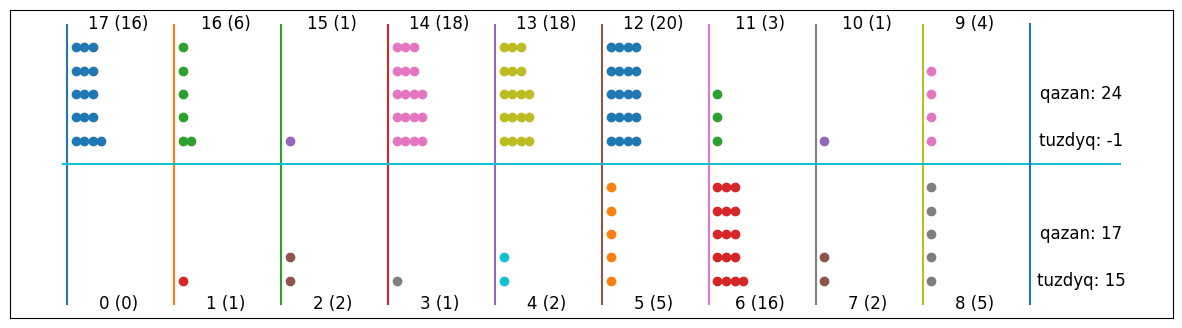

MOVE #15
bastaushy made action 8
bastaushy won tuzdyq 1
bastaushy won total 1


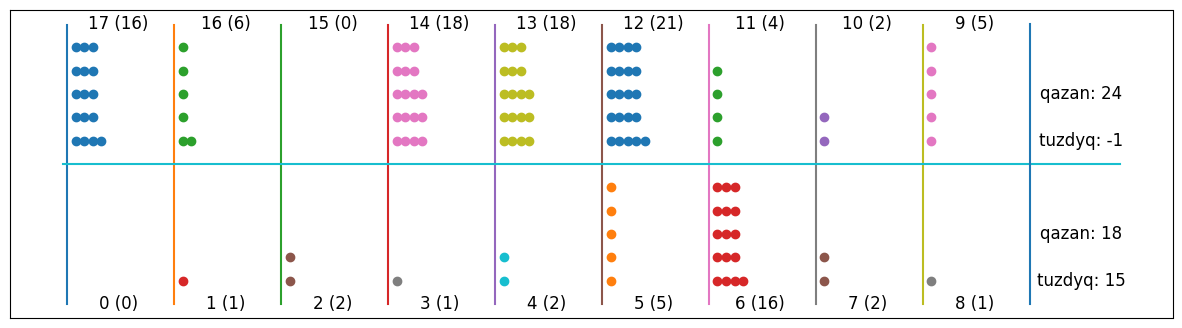

Please enter your action with mask [True, True, True, True, True, True, False, True, True] or press q for quit:


 7


MOVE #16
qostaushy made action 16
qostaushy won 2
qostaushy won total 2


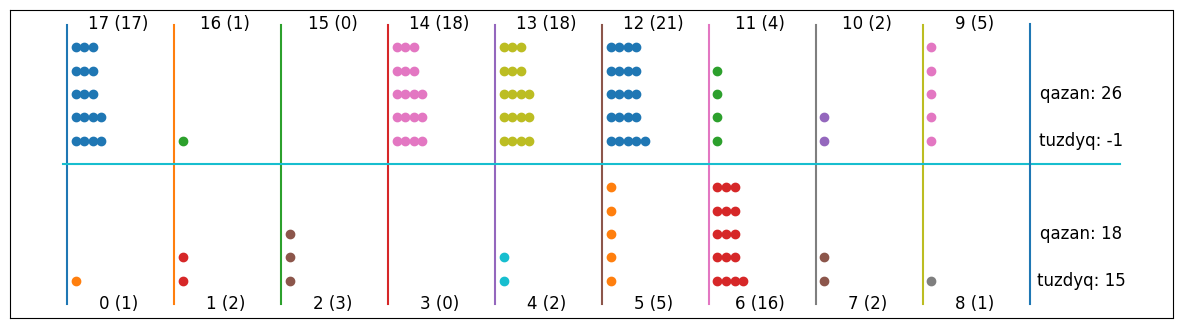

MOVE #17
bastaushy made action 4
bastaushy won total 0


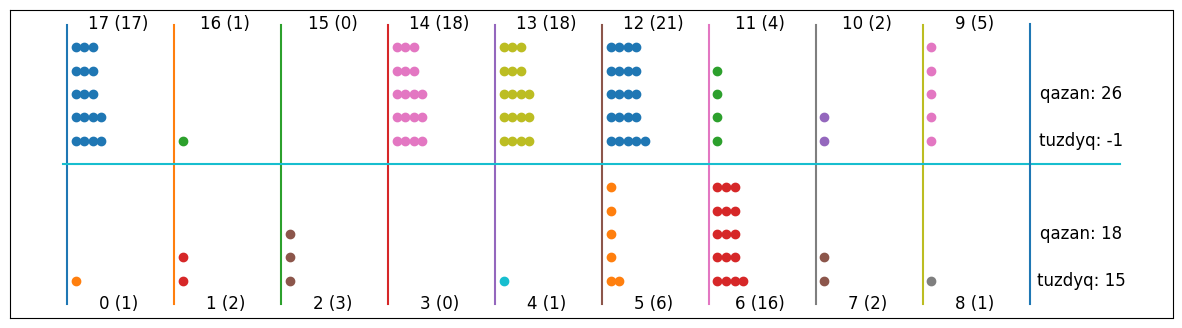

Please enter your action with mask [True, True, True, True, True, True, False, True, True] or press q for quit:


 7


MOVE #18
qostaushy made action 16
qostaushy won total 0


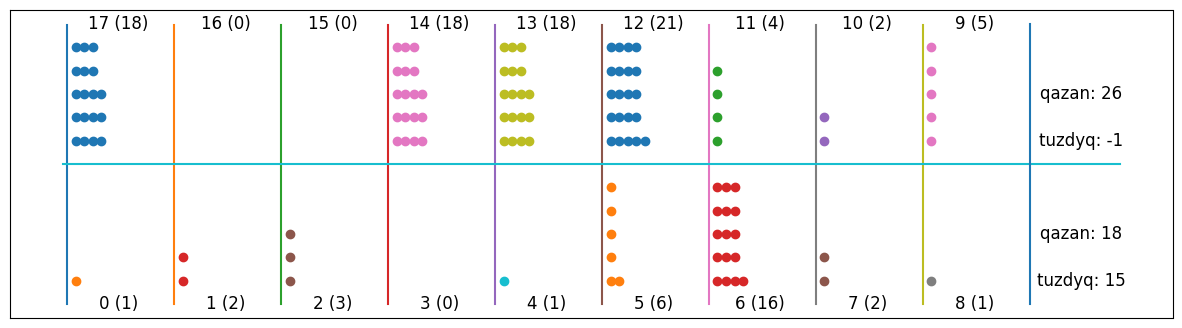

MOVE #19
bastaushy made action 4
bastaushy won total 0


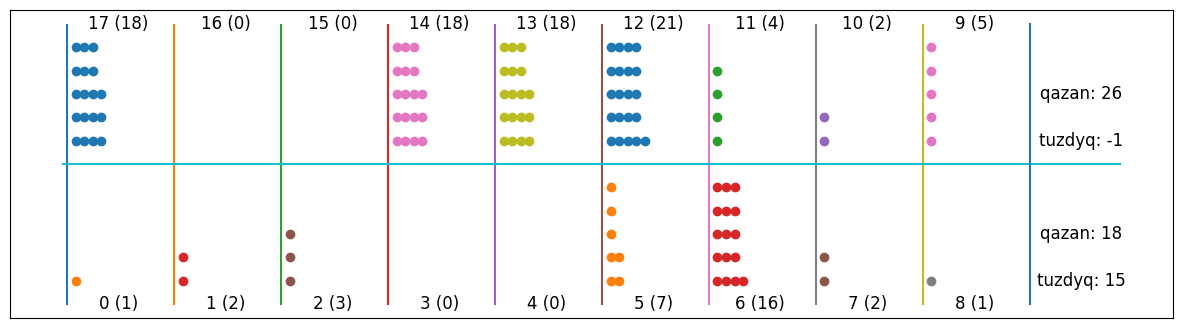

Please enter your action with mask [True, True, True, True, True, True, False, False, True] or press q for quit:


 2


MOVE #20
qostaushy made action 11
qostaushy won total 0


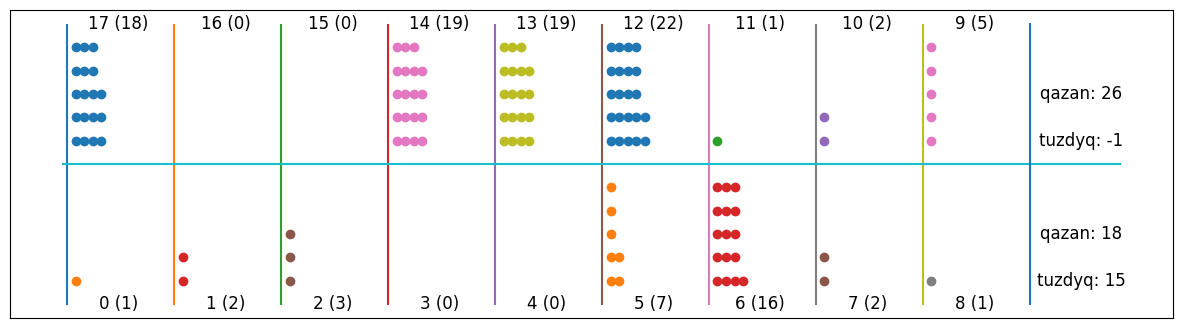

MOVE #21
bastaushy made action 8
bastaushy won 6
bastaushy won total 6


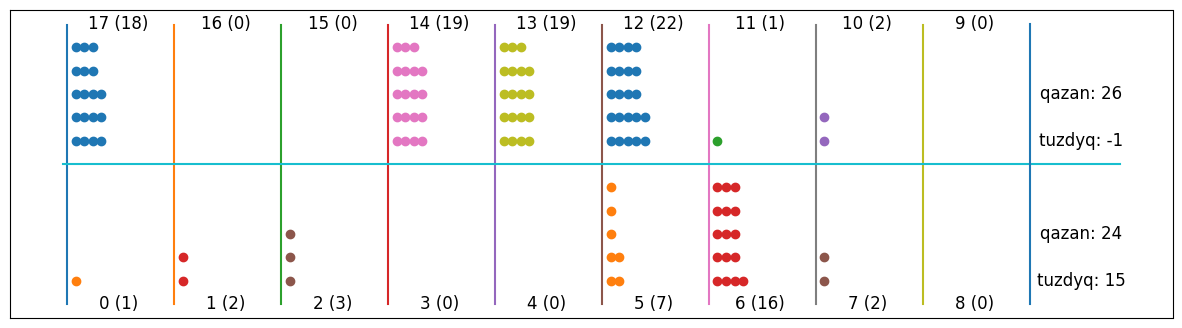

Please enter your action with mask [False, True, True, True, True, True, False, False, True] or press q for quit:


 1


MOVE #22
qostaushy made action 10
qostaushy won total 0


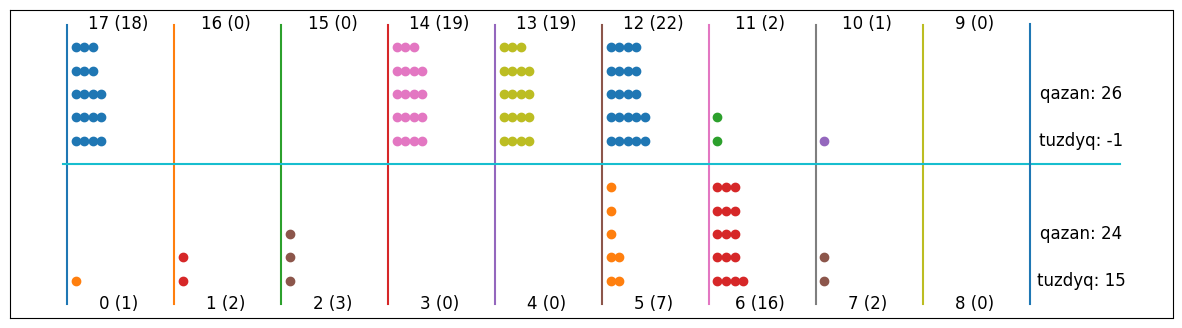

MOVE #23
bastaushy made action 5
bastaushy won total 0


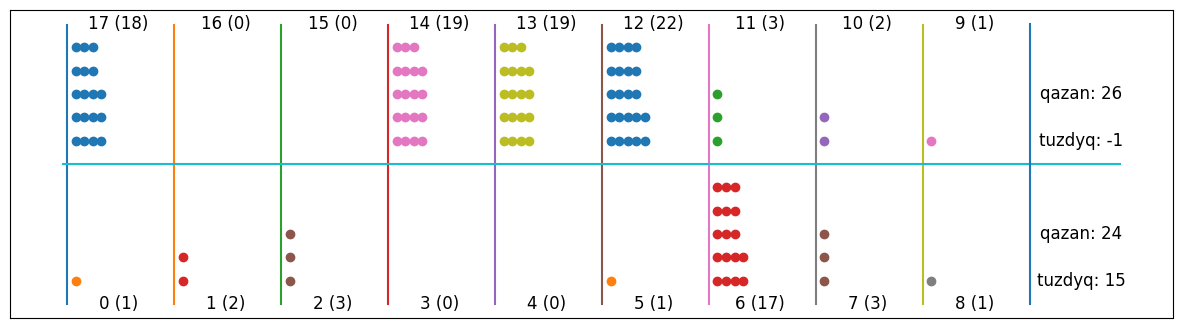

Please enter your action with mask [True, True, True, True, True, True, False, False, True] or press q for quit:


 2


MOVE #24
qostaushy made action 11
qostaushy won total 0


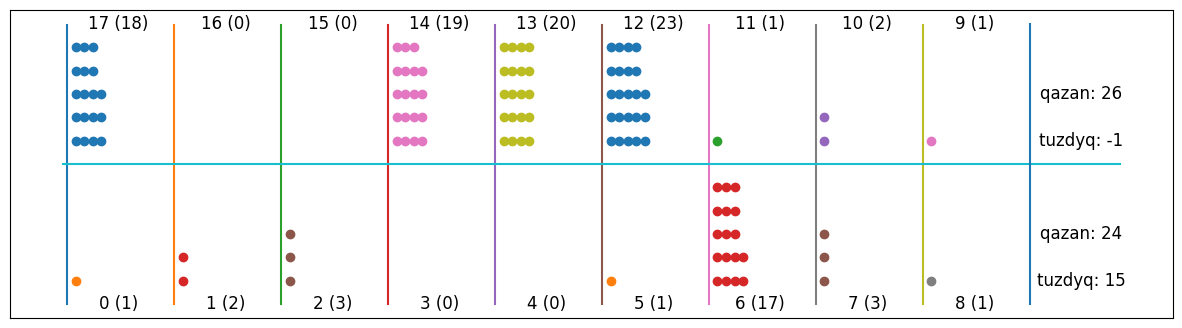

MOVE #25
bastaushy made action 8
bastaushy won 2
bastaushy won total 2


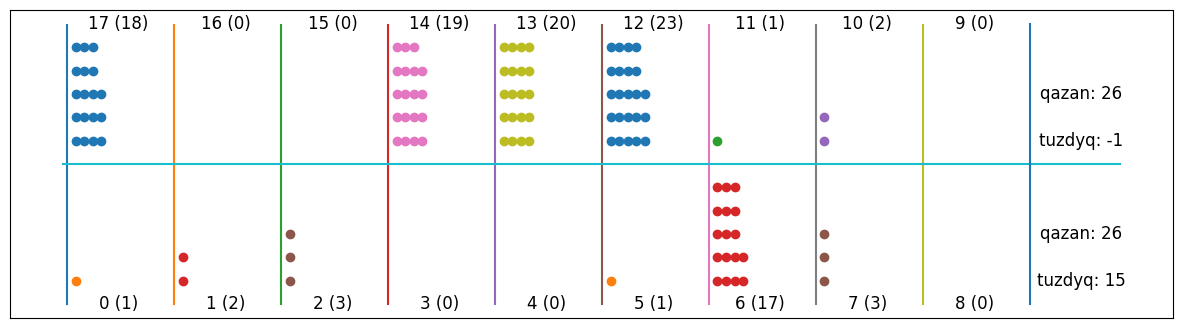

Please enter your action with mask [False, True, True, True, True, True, False, False, True] or press q for quit:


 2


MOVE #26
qostaushy made action 11
qostaushy won total 0


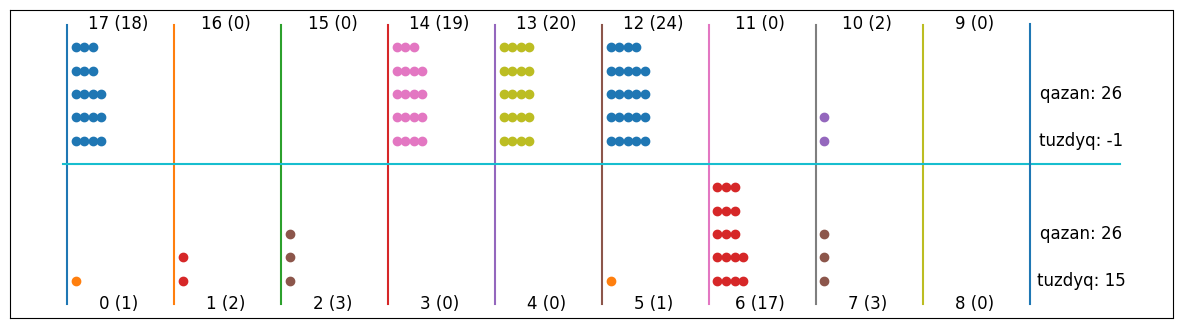

MOVE #27
bastaushy made action 1
bastaushy won total 0


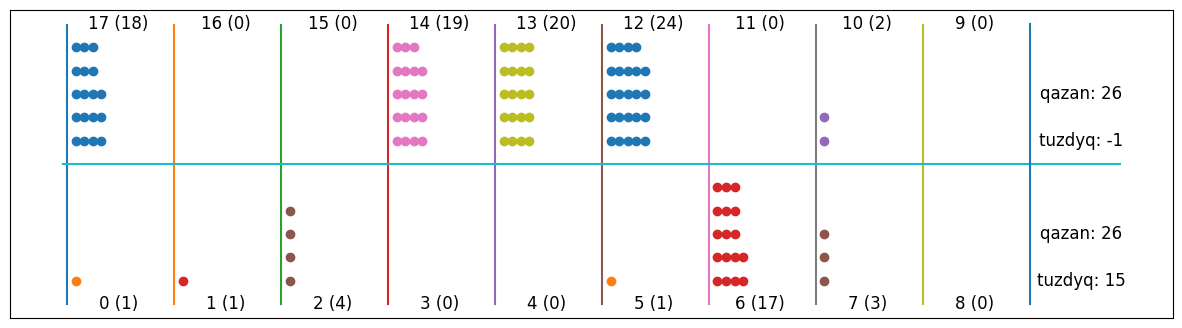

Please enter your action with mask [False, True, False, True, True, True, False, False, True] or press q for quit:


 5


MOVE #28
qostaushy made action 14
qostaushy won total 0


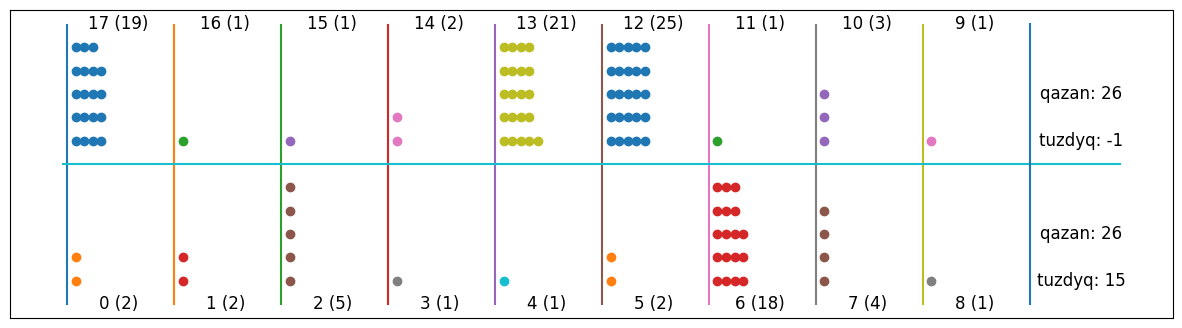

MOVE #29
bastaushy made action 8
bastaushy won 2
bastaushy won tuzdyq 1
bastaushy won total 3


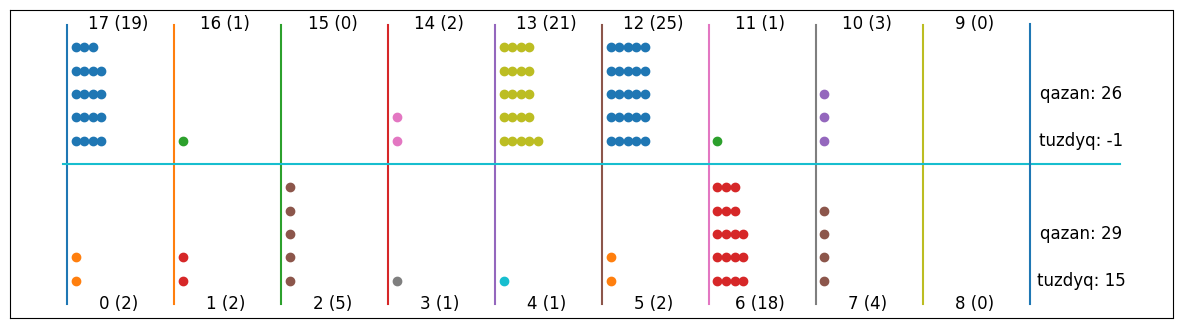

Please enter your action with mask [False, True, True, True, True, True, False, True, True] or press q for quit:


 1


MOVE #30
qostaushy made action 10
qostaushy won total 0


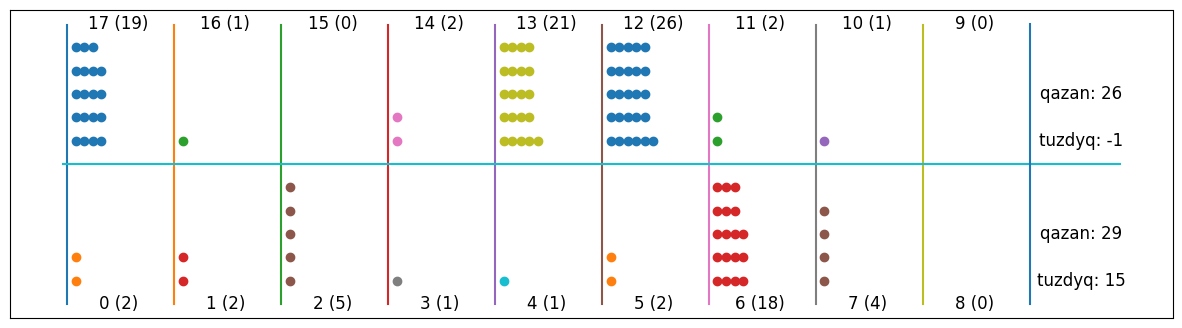

MOVE #31
bastaushy made action 4
bastaushy won total 0


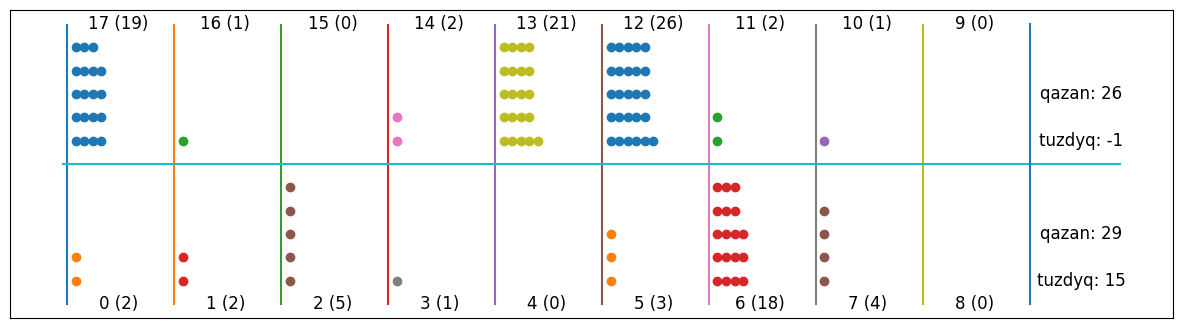

Please enter your action with mask [False, True, True, True, True, True, False, True, True] or press q for quit:


 7


MOVE #32
qostaushy made action 16
qostaushy won total 0


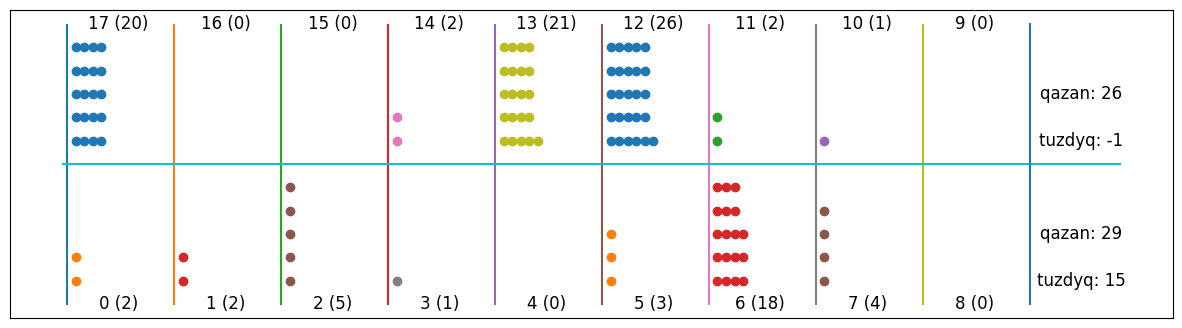

MOVE #33
bastaushy made action 5
bastaushy won total 0


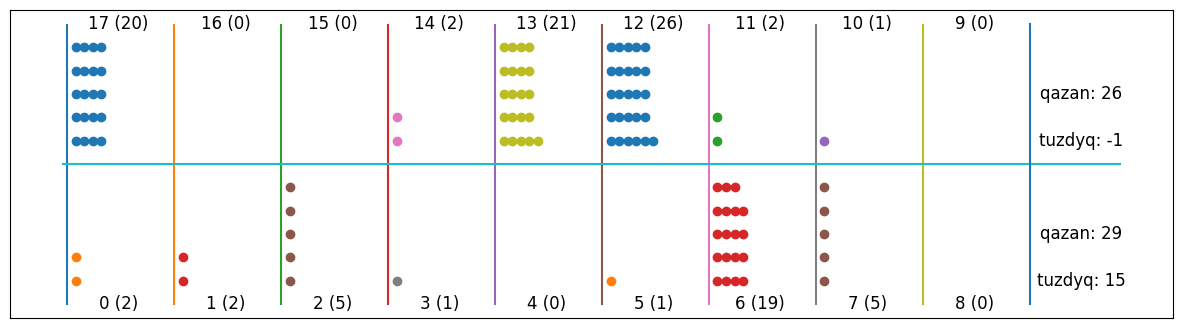

Please enter your action with mask [False, True, True, True, True, True, False, False, True] or press q for quit:


 1


MOVE #34
qostaushy made action 10
qostaushy won total 0


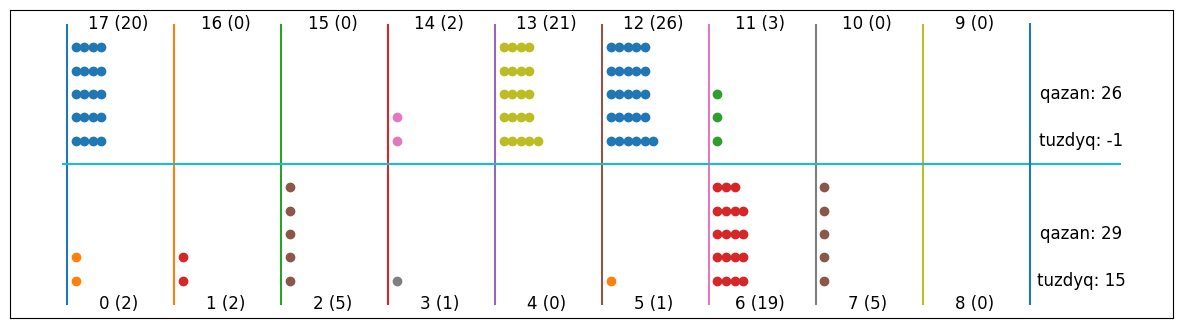

MOVE #35
bastaushy made action 2
bastaushy won total 0


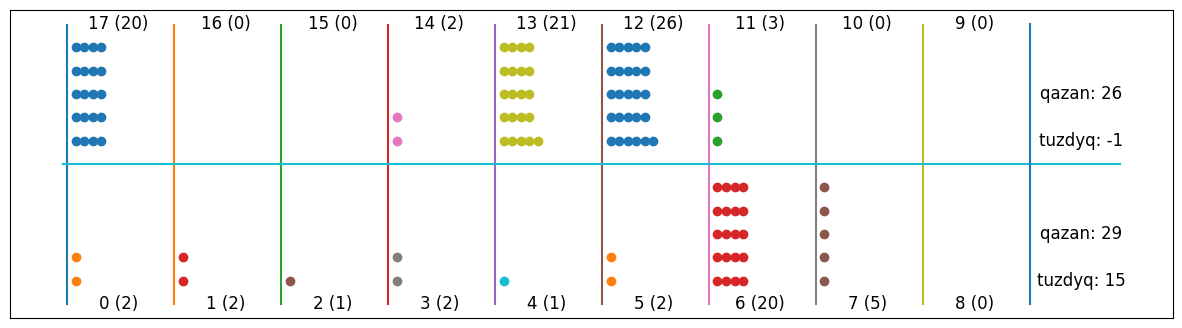

Please enter your action with mask [False, False, True, True, True, True, False, False, True] or press q for quit:


 2


MOVE #36
qostaushy made action 11
qostaushy won total 0


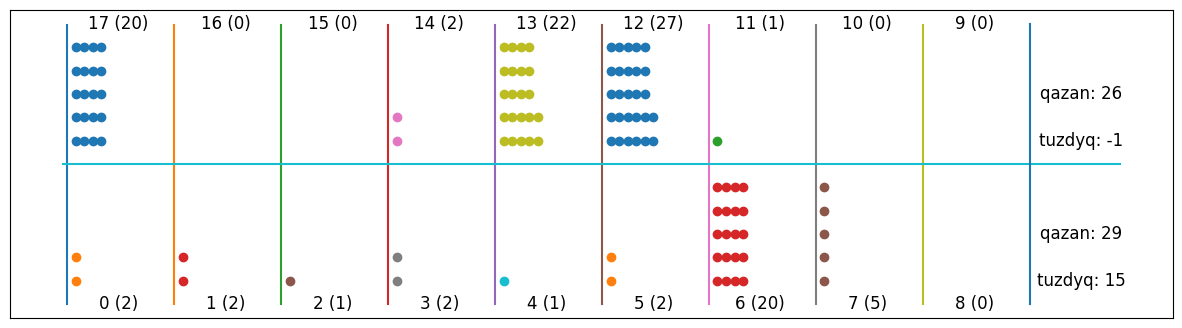

MOVE #37
bastaushy made action 4
bastaushy won total 0


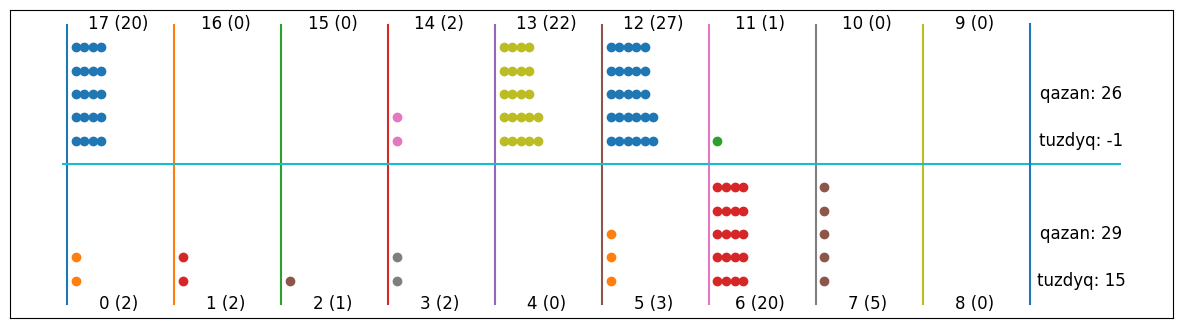

Please enter your action with mask [False, False, True, True, True, True, False, False, True] or press q for quit:


 3


MOVE #38
qostaushy made action 12
qostaushy got tuzdyq 2!
qostaushy won tuzdyq 3
qostaushy won total 3


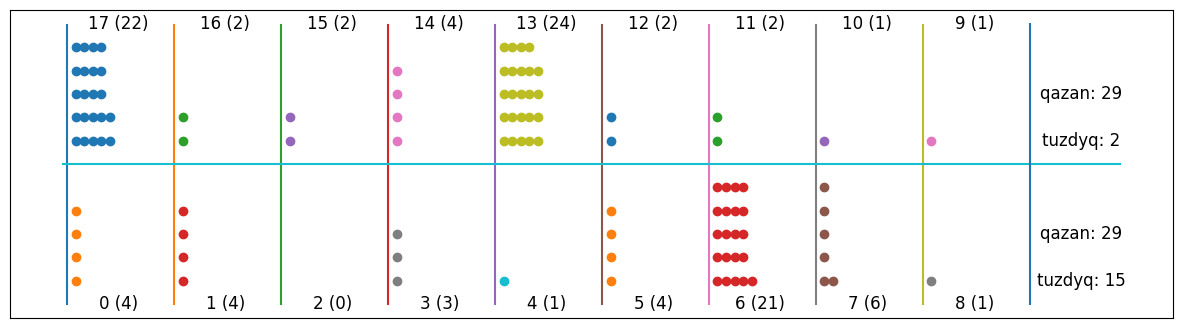

MOVE #39
bastaushy made action 8
bastaushy won 2
bastaushy won tuzdyq 2
bastaushy won total 4


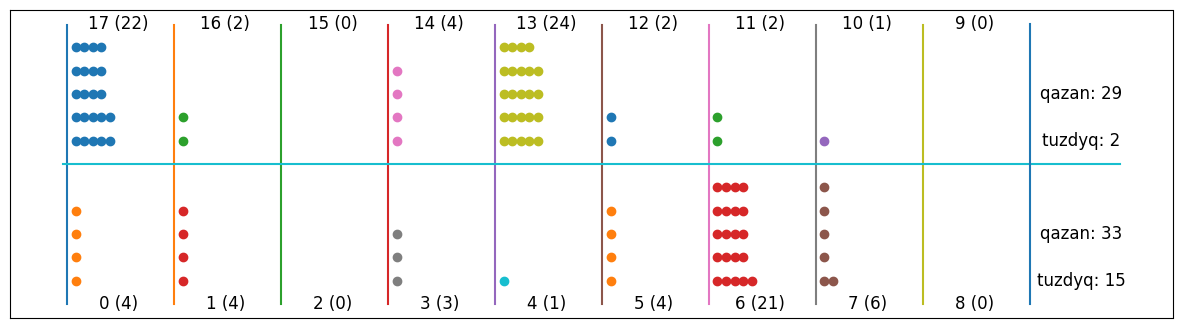

Please enter your action with mask [False, True, True, True, True, True, False, True, True] or press q for quit:


 1


MOVE #40
qostaushy made action 10
qostaushy won total 0


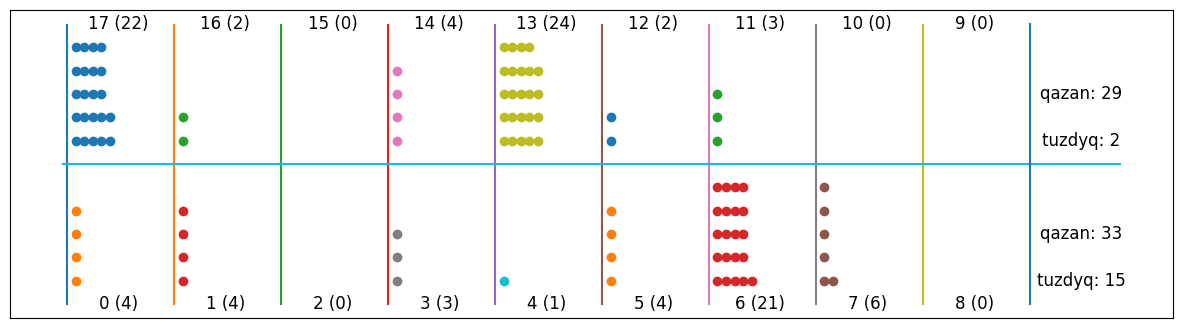

MOVE #41
bastaushy made action 4
bastaushy won total 0


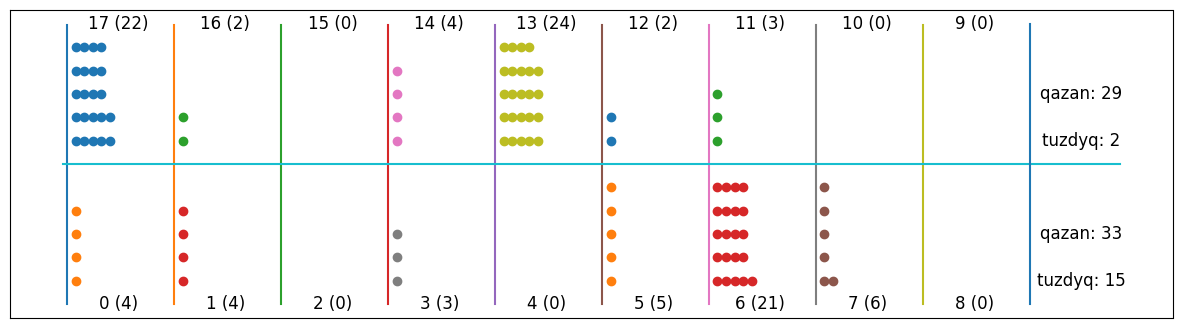

Please enter your action with mask [False, False, True, True, True, True, False, True, True] or press q for quit:


 2


MOVE #42
qostaushy made action 11
qostaushy won total 0


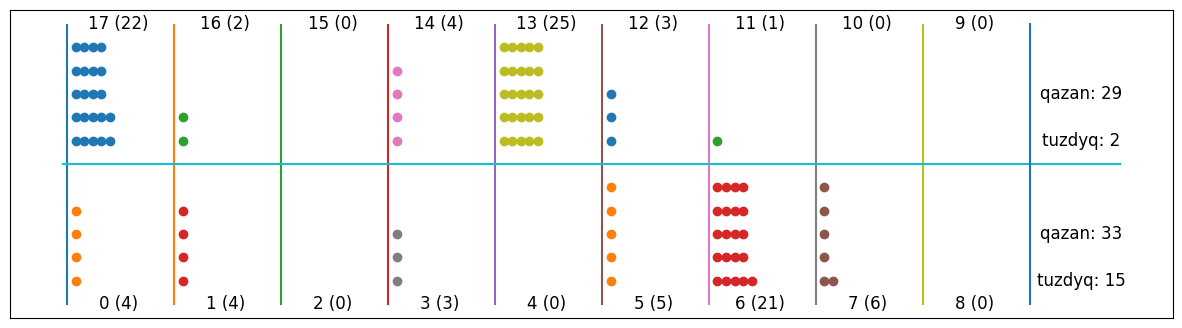

MOVE #43
bastaushy made action 5
bastaushy won total 0


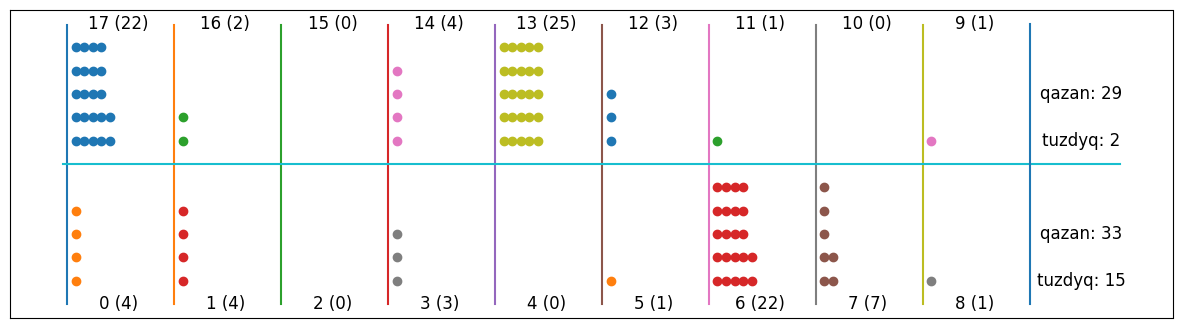

Please enter your action with mask [True, False, True, True, True, True, False, True, True] or press q for quit:


 2


MOVE #44
qostaushy made action 11
qostaushy won total 0


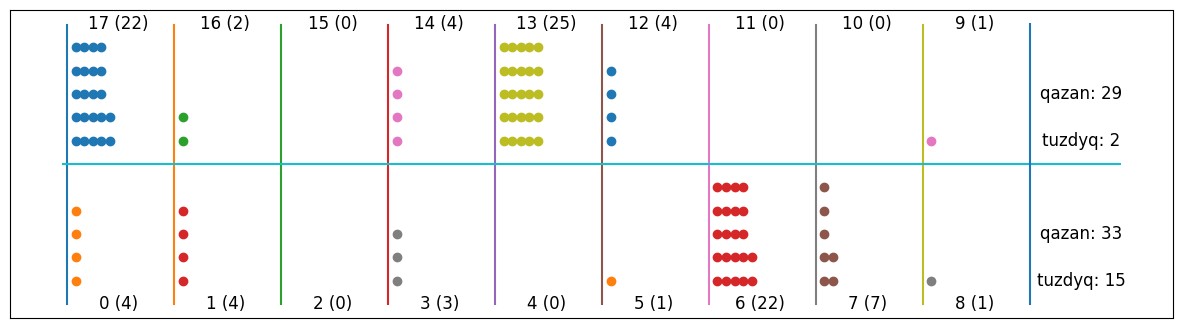

MOVE #45
bastaushy made action 8
bastaushy won 2
bastaushy won total 2


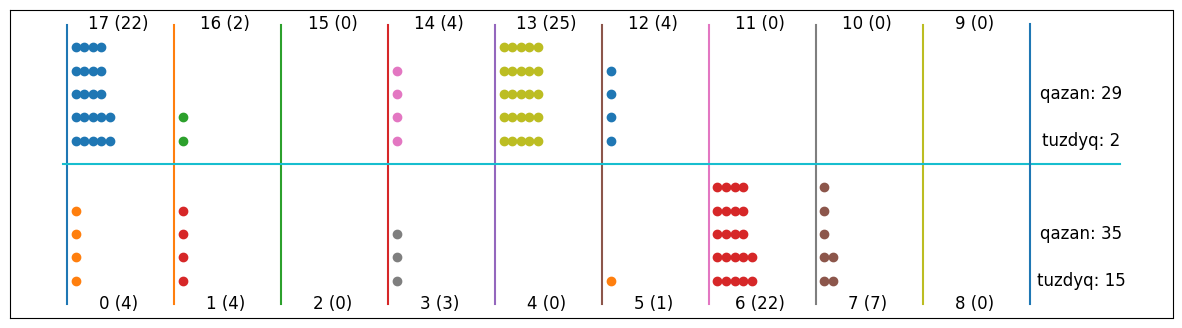

Please enter your action with mask [False, False, False, True, True, True, False, True, True] or press q for quit:


 5


MOVE #46
qostaushy made action 14
qostaushy won total 0


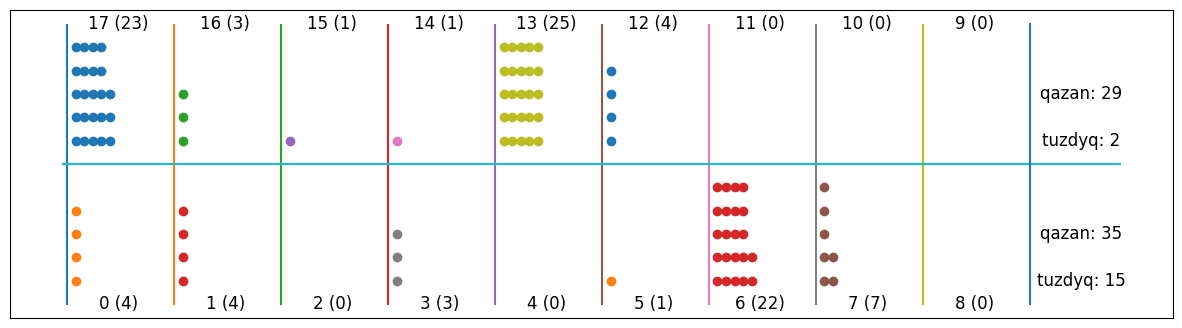

MOVE #47
bastaushy made action 5
bastaushy won tuzdyq 1
bastaushy won total 1


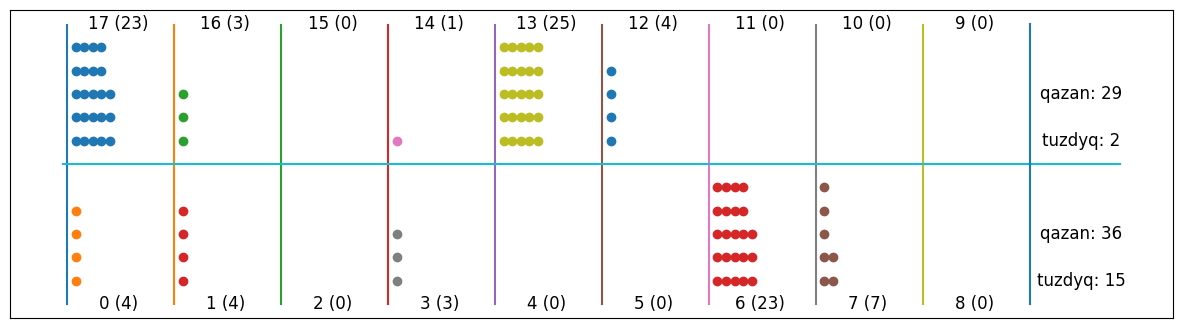

Please enter your action with mask [False, False, False, True, True, True, False, True, True] or press q for quit:


 8


MOVE #48
qostaushy made action 17
qostaushy won tuzdyq 2
qostaushy won total 2


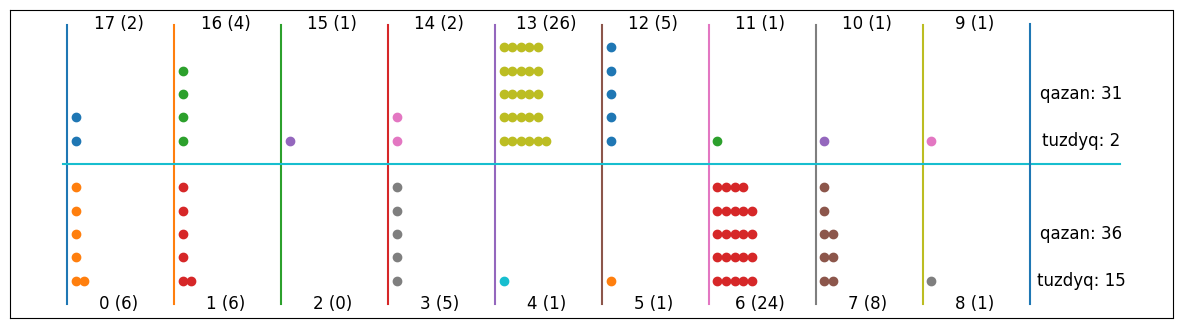

MOVE #49
bastaushy made action 6
bastaushy won tuzdyq 2
bastaushy won total 2


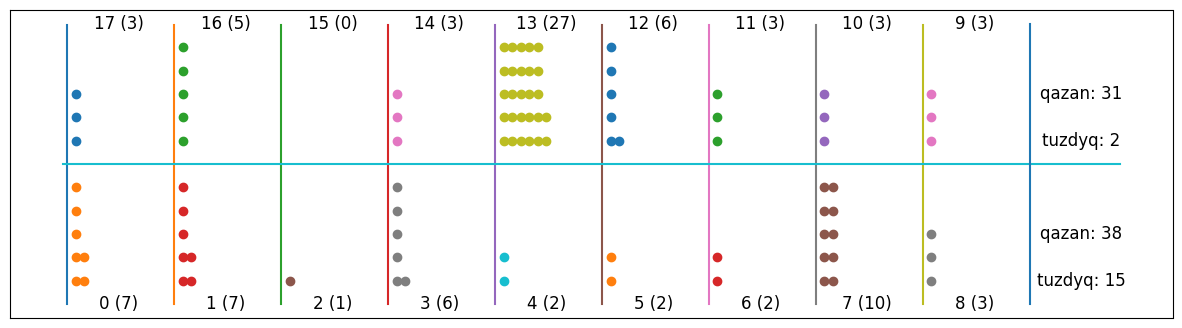

Please enter your action with mask [True, True, True, True, True, True, False, True, True] or press q for quit:


 8


MOVE #50
qostaushy made action 17
qostaushy won 8
qostaushy won tuzdyq 1
qostaushy won total 9


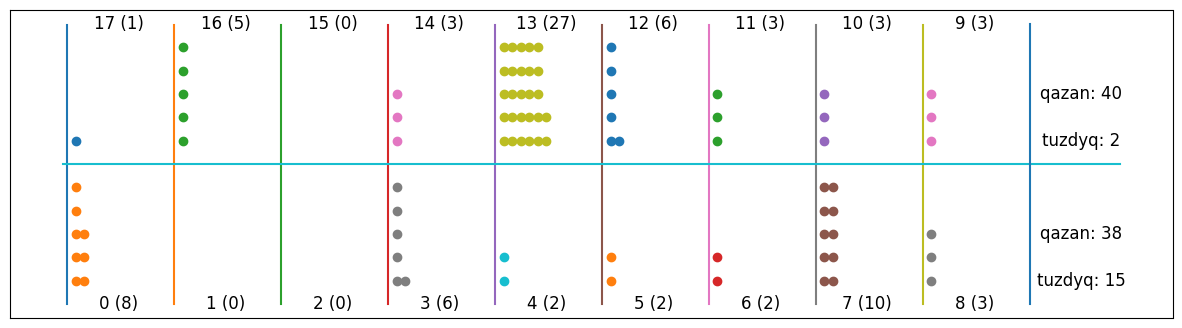

MOVE #51
bastaushy made action 7
bastaushy won 6
bastaushy won tuzdyq 1
bastaushy won total 7


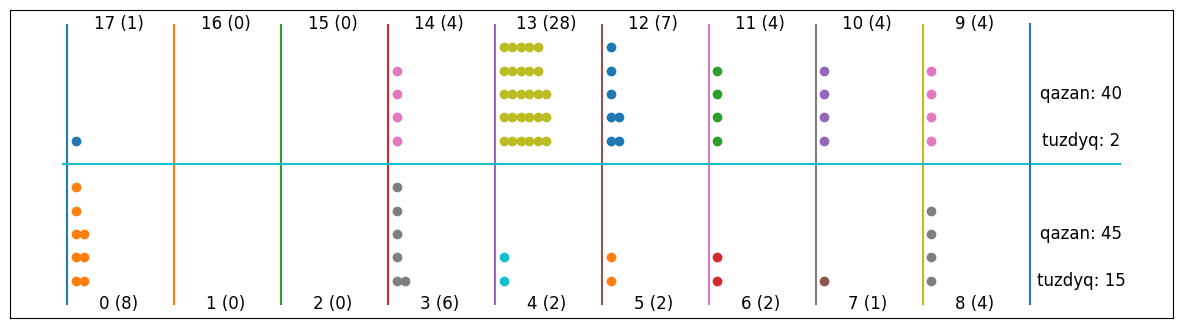

Please enter your action with mask [True, True, True, True, True, True, False, False, True] or press q for quit:


 0


MOVE #52
qostaushy made action 9
qostaushy won total 0


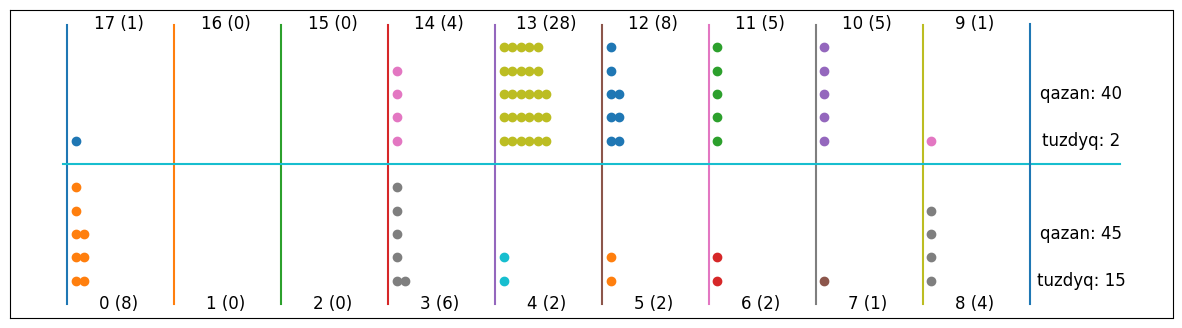

MOVE #53
bastaushy made action 8
bastaushy won 6
bastaushy won total 6


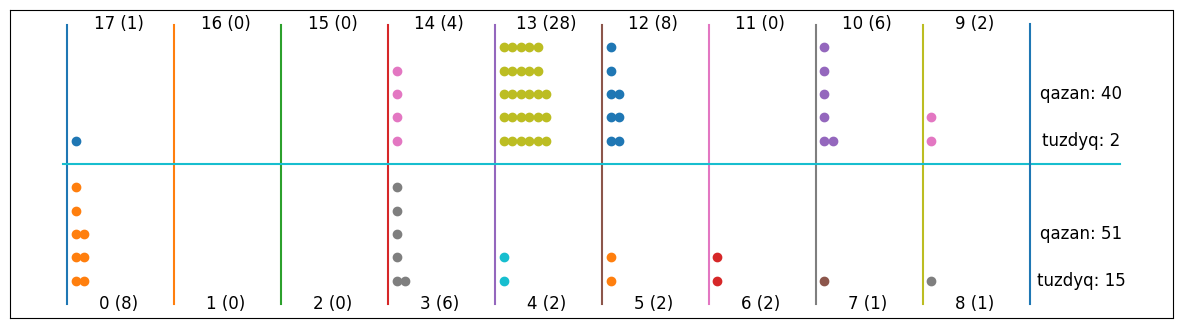

Please enter your action with mask [True, True, False, True, True, True, False, False, True] or press q for quit:


 8


MOVE #54
qostaushy made action 17
qostaushy won total 0


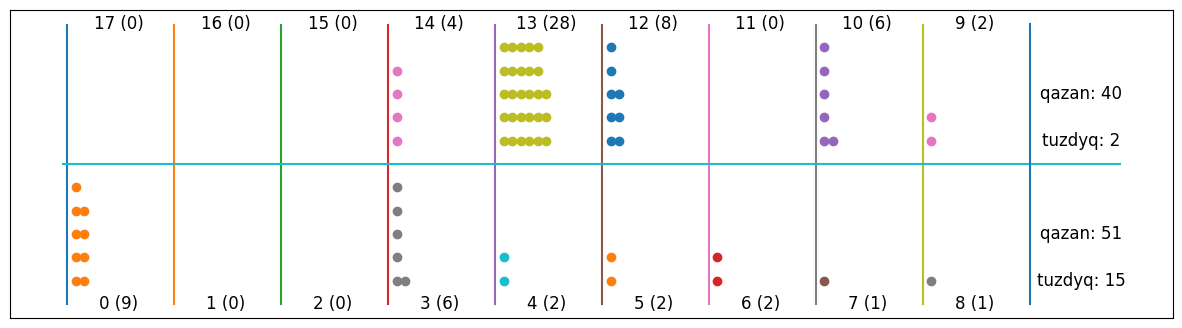

MOVE #55
bastaushy made action 0
bastaushy won total 0


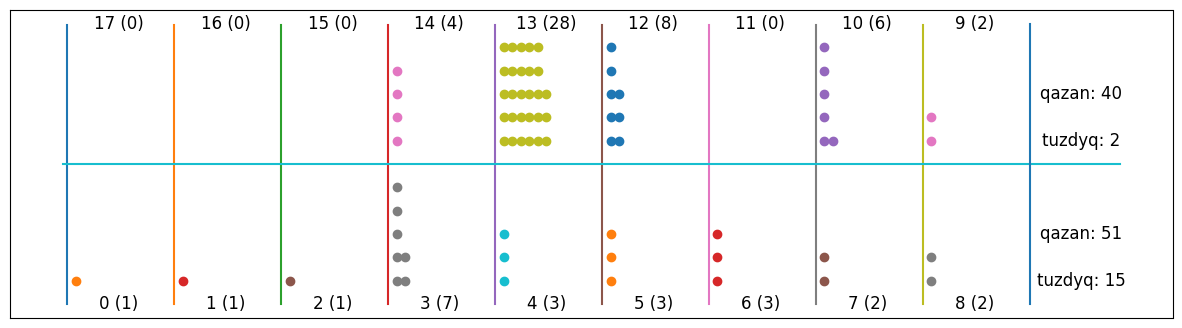

Please enter your action with mask [True, True, False, True, True, True, False, False, False] or press q for quit:


 4


MOVE #56
qostaushy made action 13
qostaushy won tuzdyq 3
qostaushy won total 3


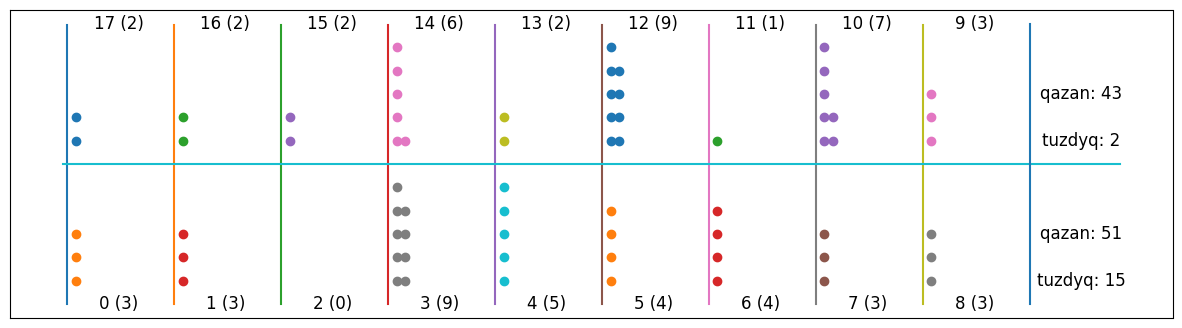

MOVE #57
bastaushy made action 3
bastaushy won 2
bastaushy won tuzdyq 2
bastaushy won total 4


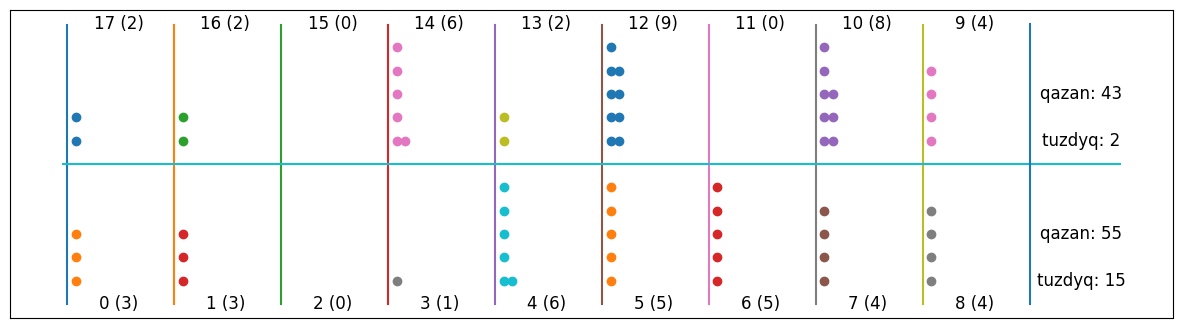

Please enter your action with mask [True, True, False, True, True, True, False, True, True] or press q for quit:


 5


MOVE #58
qostaushy made action 14
qostaushy won 4
qostaushy won total 4


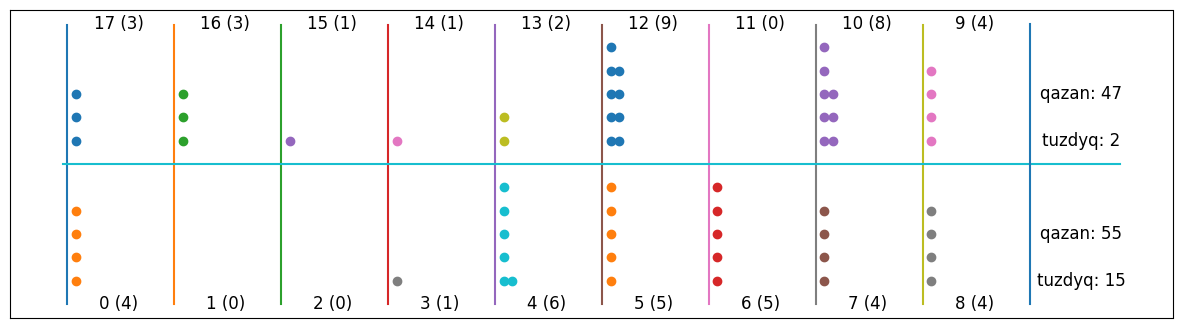

MOVE #59
bastaushy made action 8
bastaushy won tuzdyq 1
bastaushy won total 1


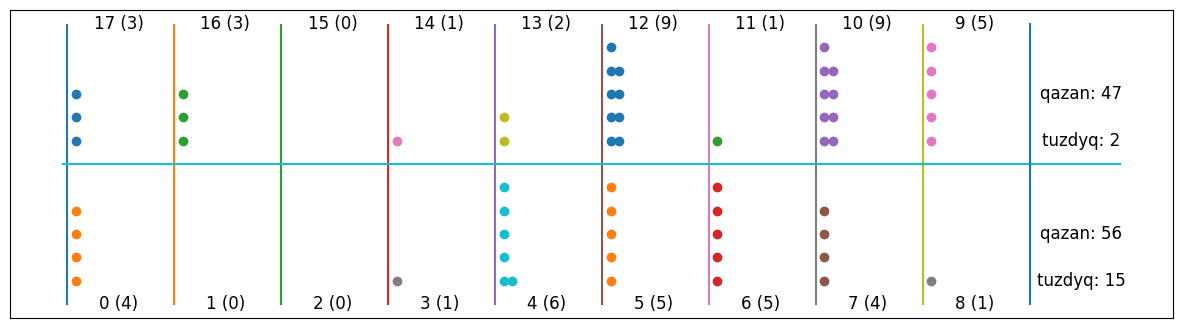

Please enter your action with mask [True, True, True, True, True, True, False, True, True] or press q for quit:


 2


MOVE #60
qostaushy made action 11
qostaushy won total 0


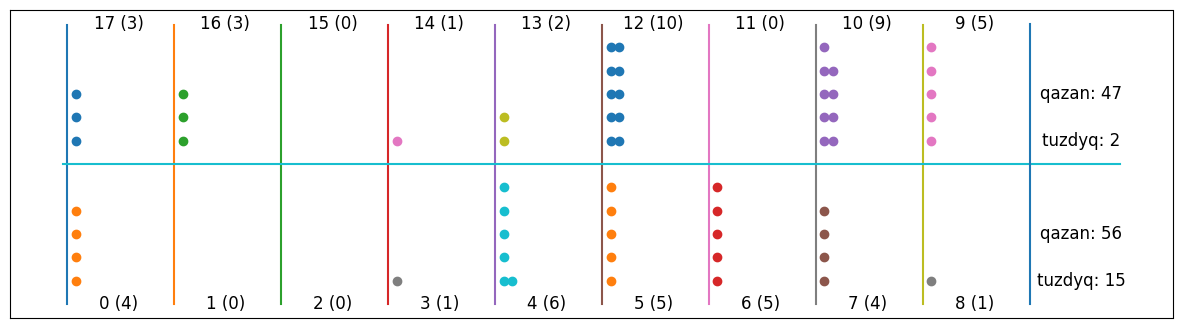

MOVE #61
bastaushy made action 4
bastaushy won 6
bastaushy won total 6


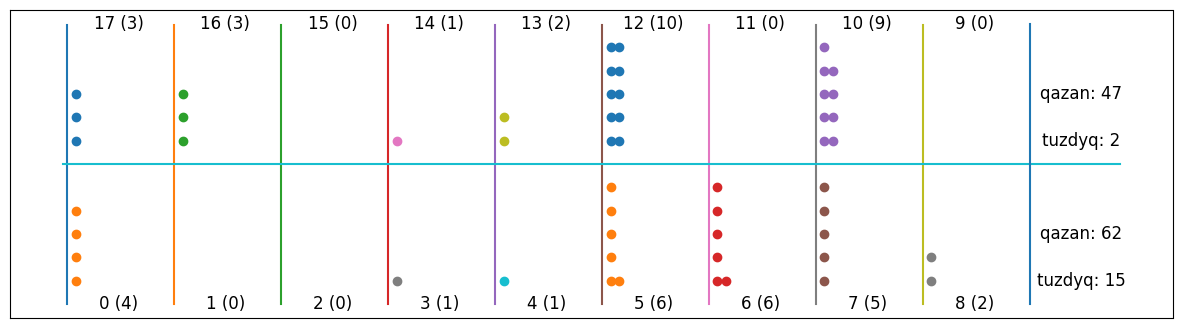

Please enter your action with mask [False, True, False, True, True, True, False, True, True] or press q for quit:


 3


MOVE #62
qostaushy made action 12
qostaushy won 2
qostaushy won tuzdyq 1
qostaushy won total 3


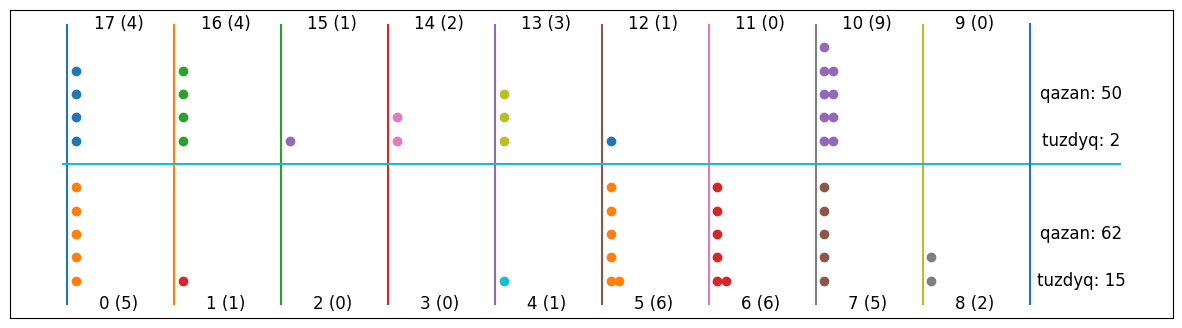

MOVE #63
bastaushy made action 7
bastaushy won tuzdyq 1
bastaushy won total 1


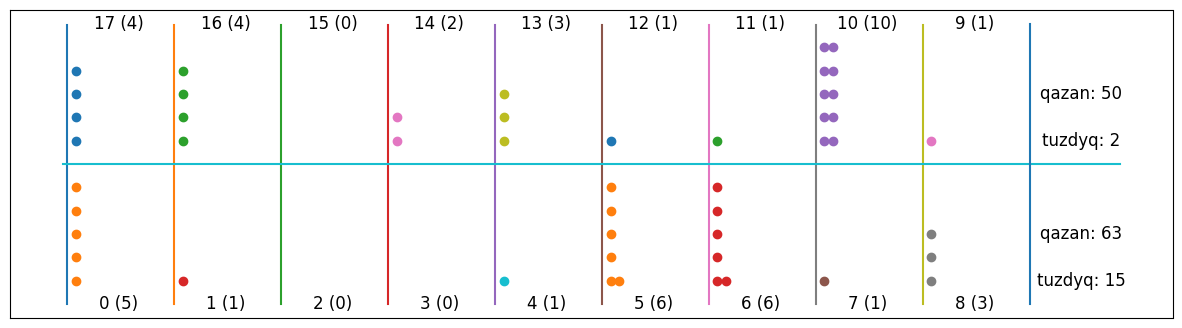

Please enter your action with mask [True, True, True, True, True, True, False, True, True] or press q for quit:


 7


MOVE #64
qostaushy made action 16
qostaushy won 2
qostaushy won total 2


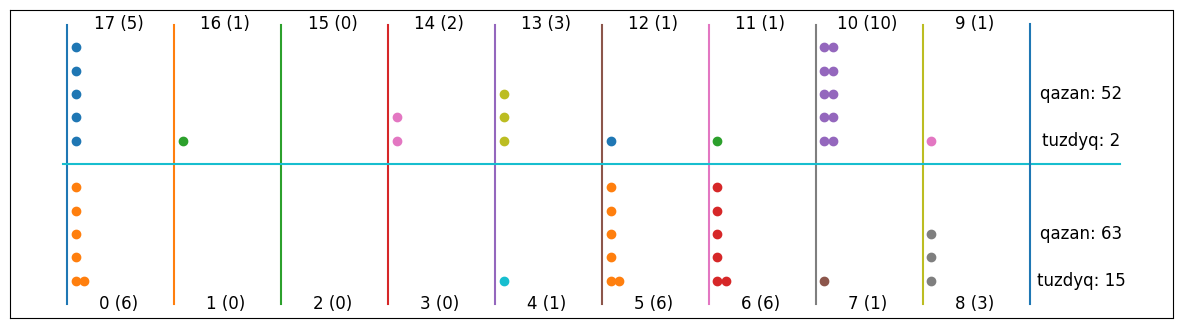

MOVE #65
bastaushy made action 8
bastaushy won total 0


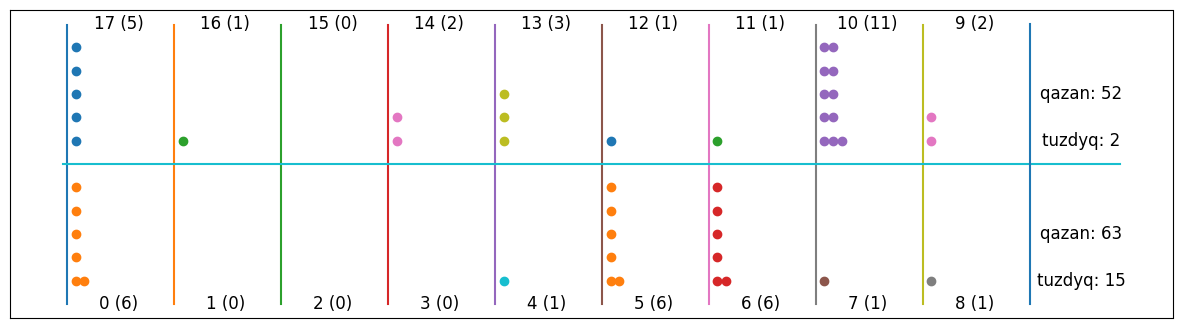

Please enter your action with mask [True, True, True, True, True, True, False, True, True] or press q for quit:


 0


MOVE #66
qostaushy made action 9
qostaushy won total 0


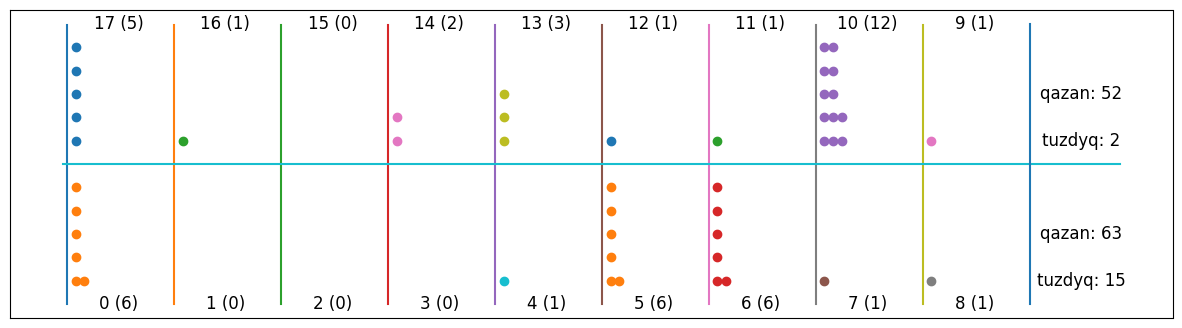

MOVE #67
bastaushy made action 6
bastaushy won 2
bastaushy won total 2


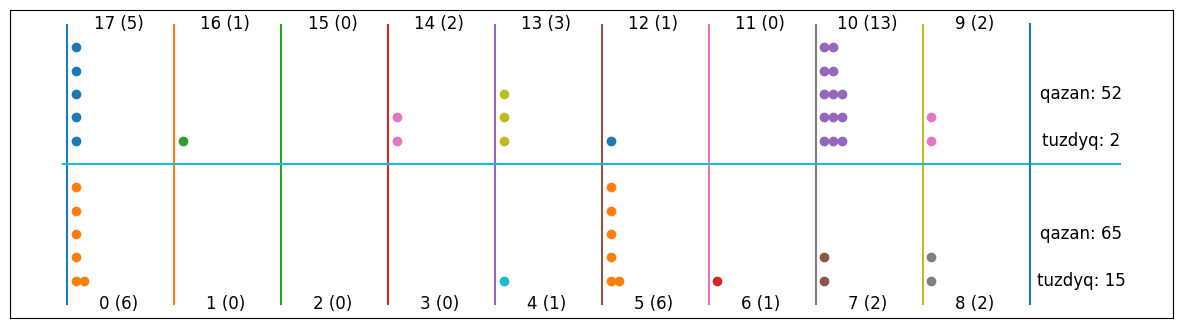

Please enter your action with mask [True, True, False, True, True, True, False, True, True] or press q for quit:


 1


MOVE #68
qostaushy made action 10
qostaushy won 2
qostaushy won tuzdyq 1
qostaushy won total 3


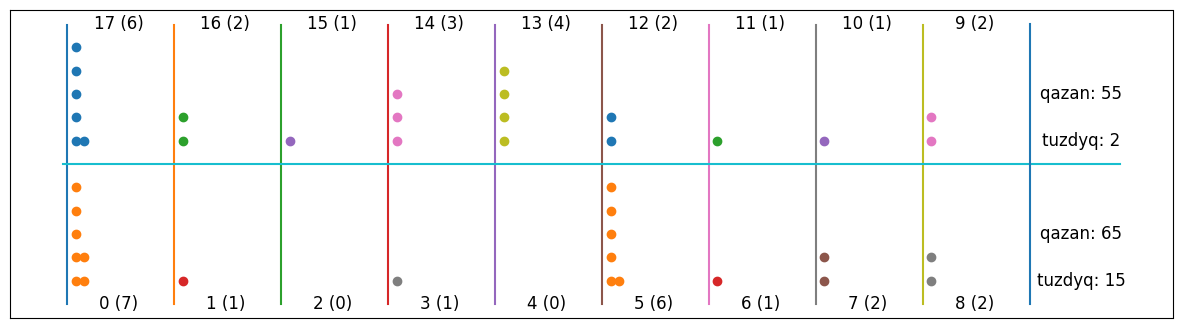

MOVE #69
bastaushy made action 0
bastaushy won tuzdyq 1
bastaushy won total 1


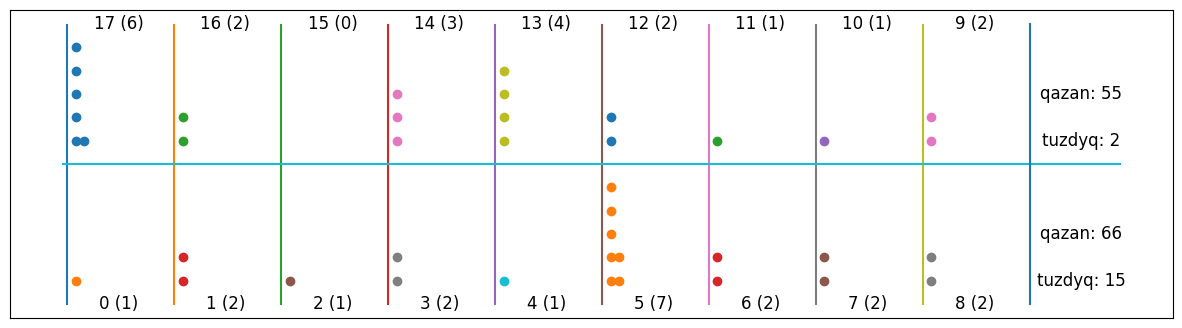

Please enter your action with mask [True, True, True, True, True, True, False, True, True] or press q for quit:


 0


MOVE #70
qostaushy made action 9
qostaushy won tuzdyq 1
qostaushy won total 1


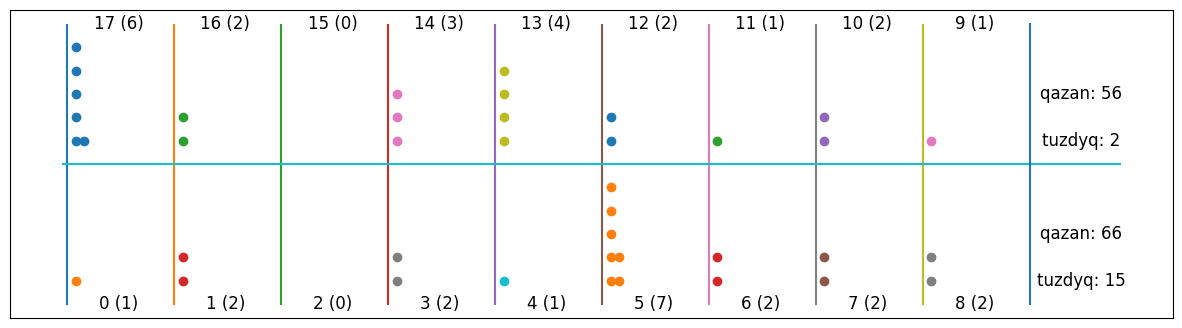

MOVE #71
bastaushy made action 5
bastaushy won 2
bastaushy won total 2


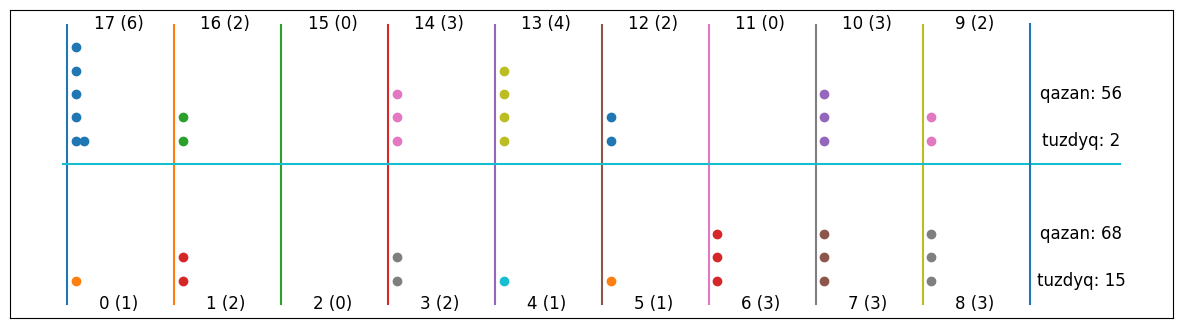

Please enter your action with mask [True, True, False, True, True, True, False, True, True] or press q for quit:


 0


MOVE #72
qostaushy made action 9
qostaushy won total 0


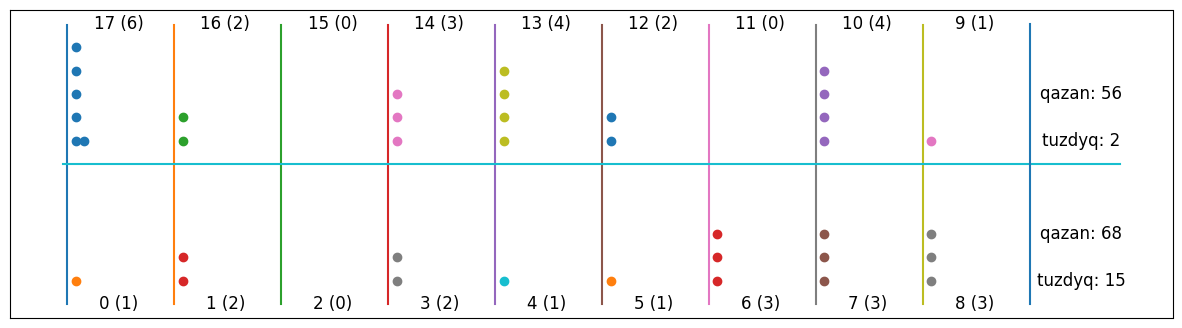

MOVE #73
bastaushy made action 8
bastaushy won total 0


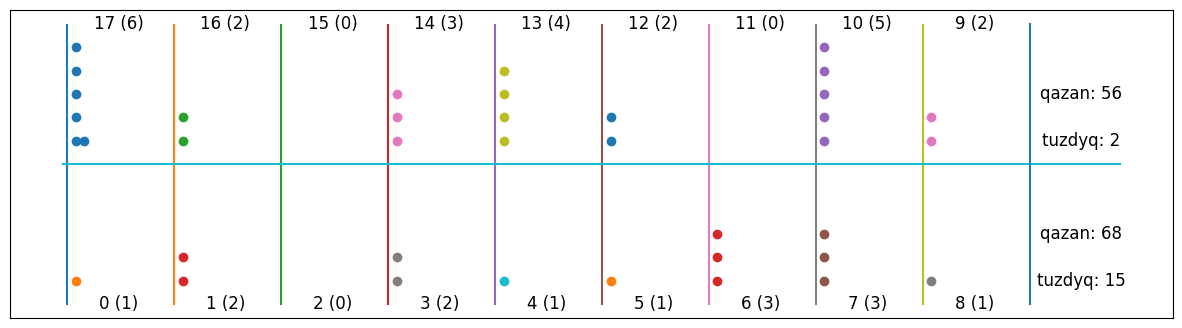

Please enter your action with mask [True, True, False, True, True, True, False, True, True] or press q for quit:


 0


MOVE #74
qostaushy made action 9
qostaushy won total 0


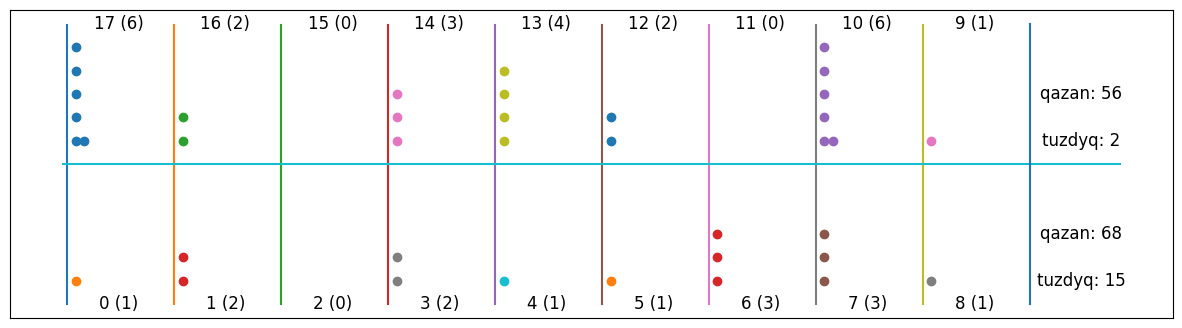

MOVE #75
bastaushy made action 7
bastaushy won 2
bastaushy won total 2


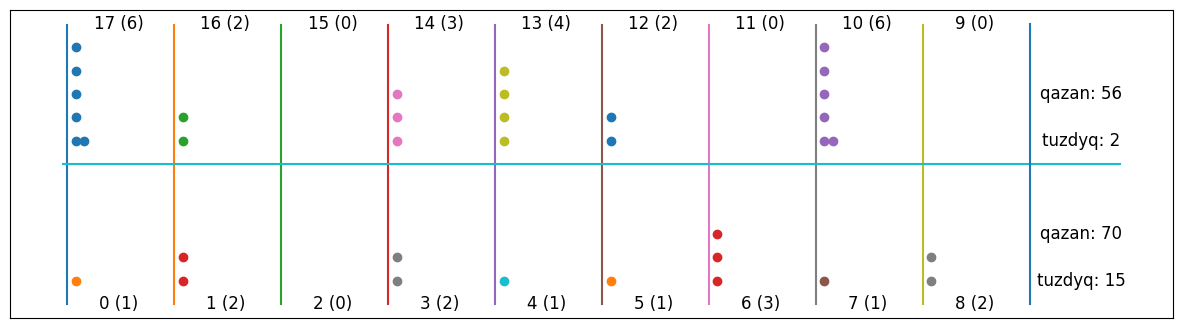

Please enter your action with mask [False, True, False, True, True, True, False, True, True] or press q for quit:


 3


MOVE #76
qostaushy made action 12
qostaushy won total 0


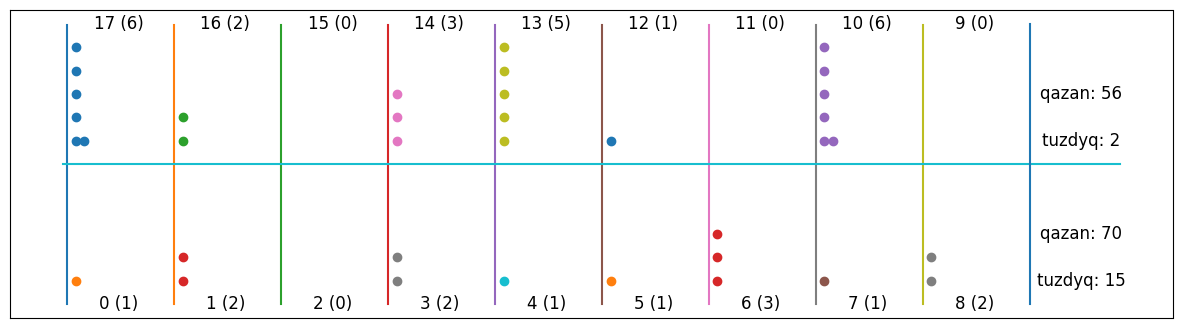

MOVE #77
bastaushy made action 7
bastaushy won total 0


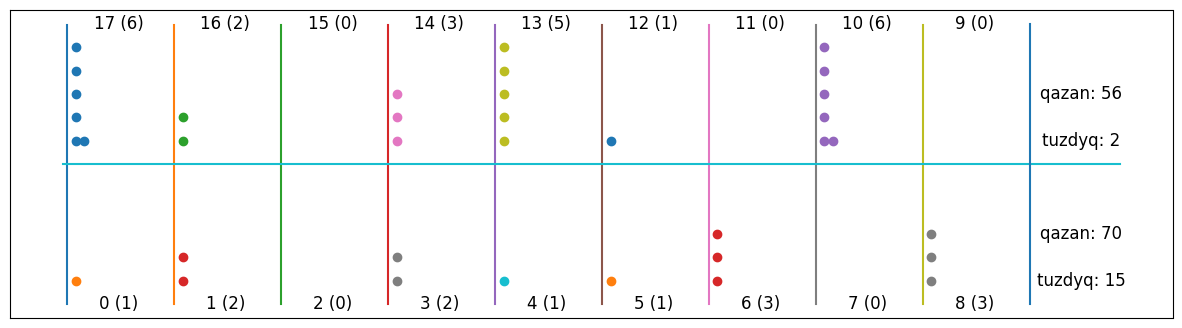

Please enter your action with mask [False, True, False, True, True, True, False, True, True] or press q for quit:


 3


MOVE #78
qostaushy made action 12
qostaushy won total 0


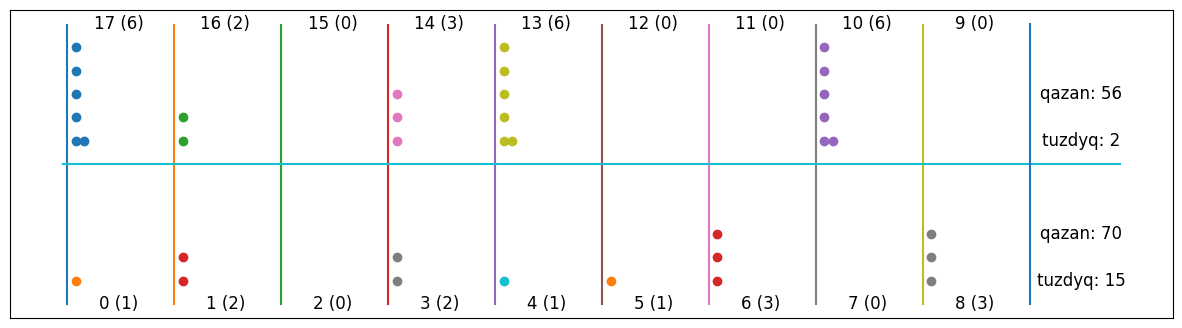

MOVE #79
bastaushy made action 8
bastaushy won total 0


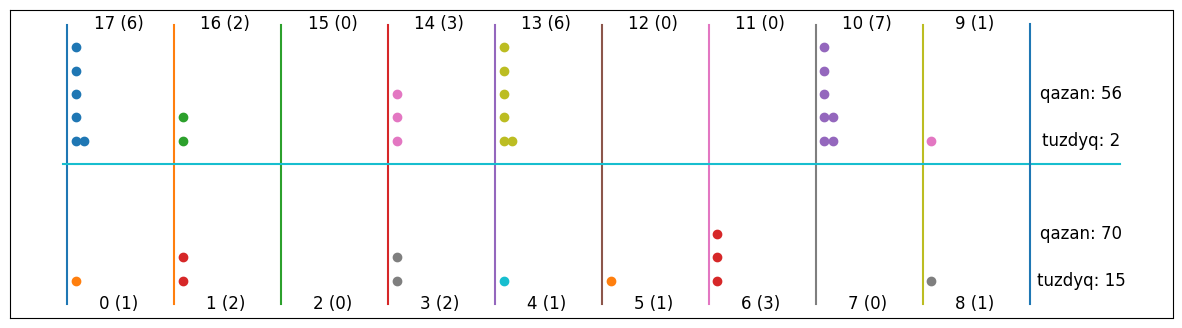

Please enter your action with mask [True, True, False, False, True, True, False, True, True] or press q for quit:


 0


MOVE #80
qostaushy made action 9
qostaushy won total 0


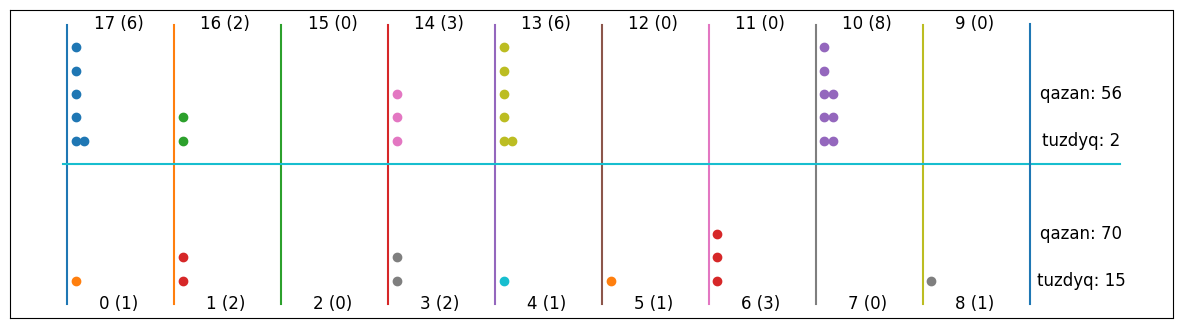

MOVE #81
bastaushy made action 6
bastaushy won total 0


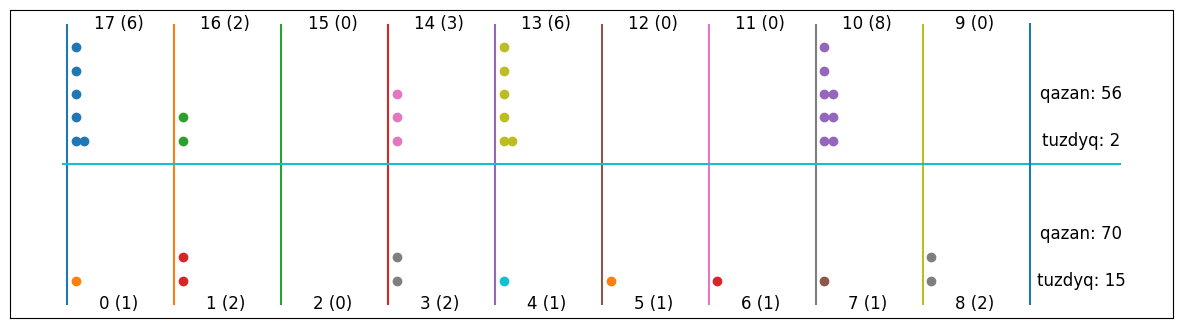

Please enter your action with mask [False, True, False, False, True, True, False, True, True] or press q for quit:


 4


MOVE #82
qostaushy made action 13
qostaushy won 2
qostaushy won total 2


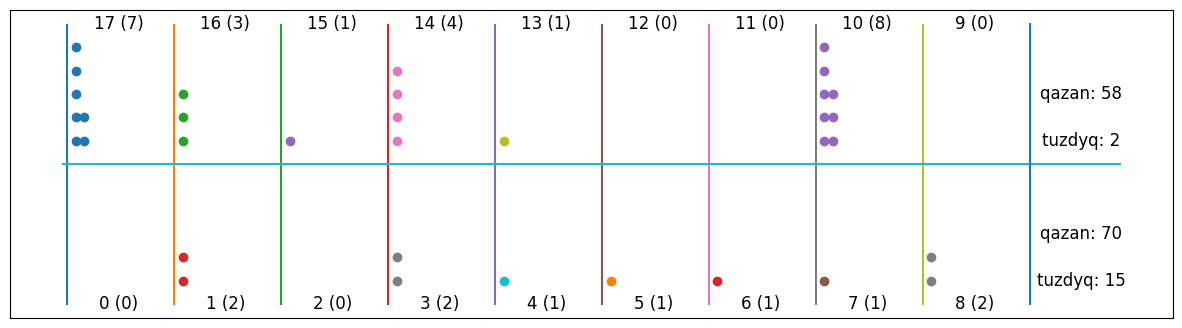

MOVE #83
bastaushy made action 7
bastaushy won tuzdyq 1
bastaushy won total 1


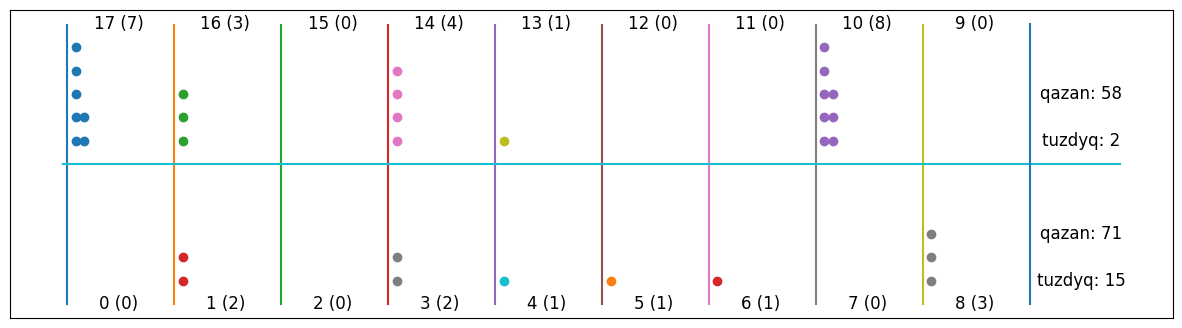

Please enter your action with mask [False, True, False, False, True, True, False, True, True] or press q for quit:


 8


MOVE #84
qostaushy made action 17
qostaushy won 2
qostaushy won tuzdyq 1
qostaushy won total 3


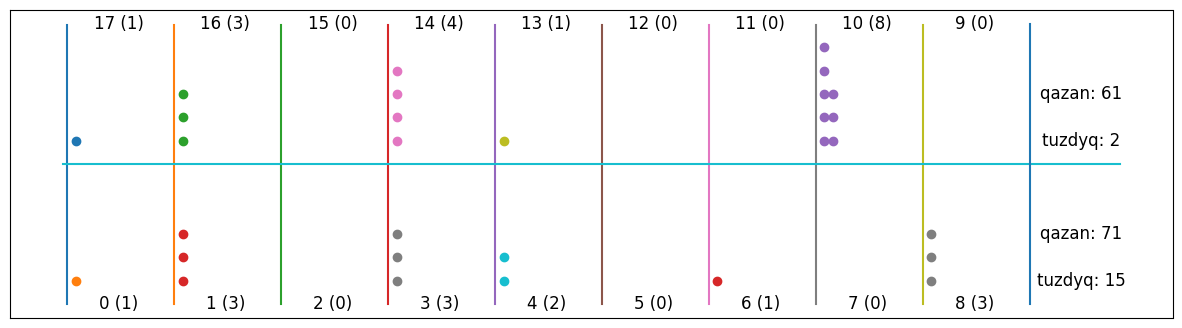

MOVE #85
bastaushy made action 8
bastaushy won total 0


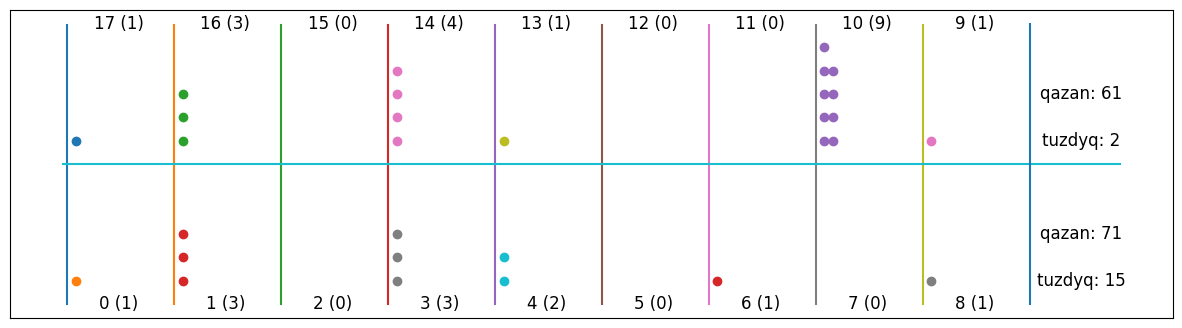

Please enter your action with mask [True, True, False, False, True, True, False, True, True] or press q for quit:


 7


MOVE #86
qostaushy made action 16
qostaushy won 2
qostaushy won total 2


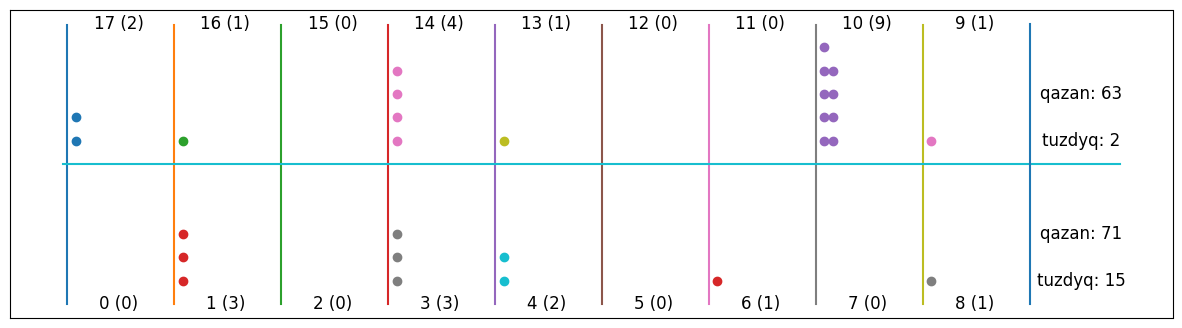

MOVE #87
bastaushy made action 3
bastaushy won total 0


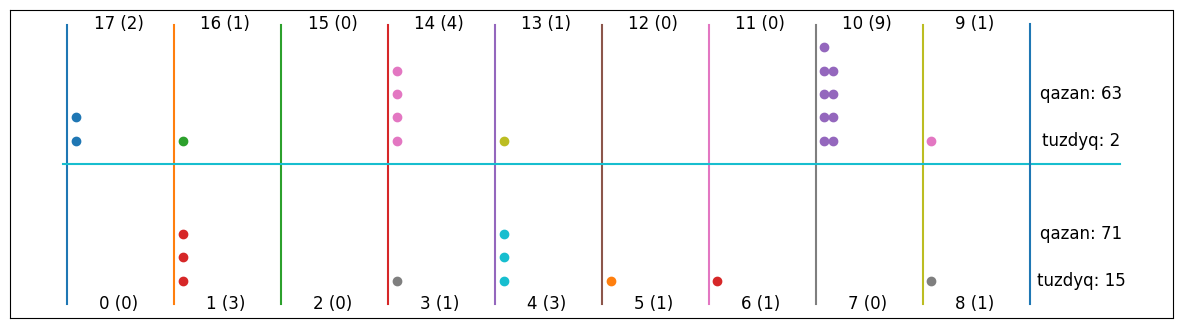

Please enter your action with mask [True, True, False, False, True, True, False, True, True] or press q for quit:


 0


MOVE #88
qostaushy made action 9
qostaushy won total 0


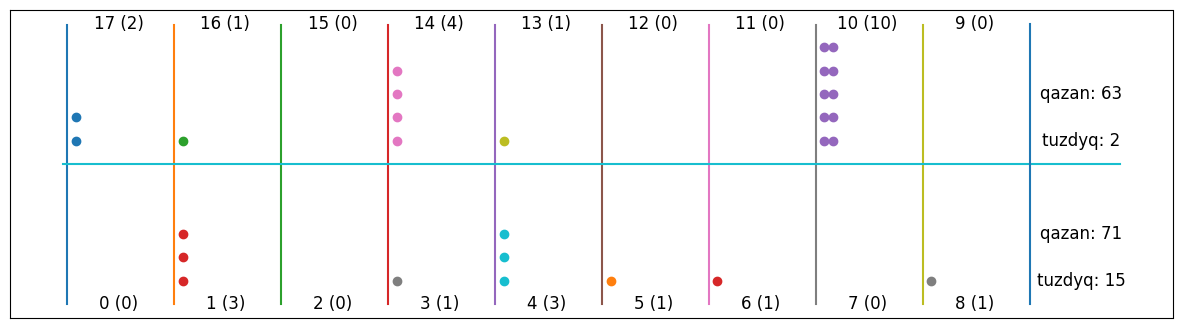

MOVE #89
bastaushy made action 4
bastaushy won total 0


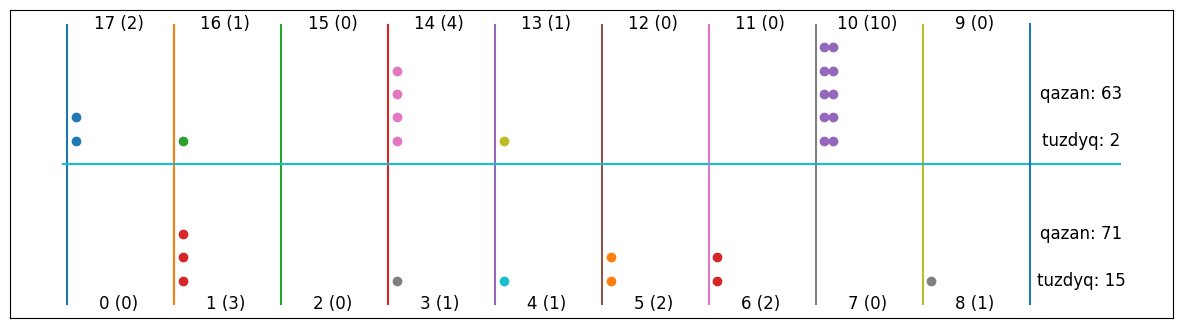

Please enter your action with mask [False, True, False, False, True, True, False, True, True] or press q for quit:


 1


MOVE #90
qostaushy made action 10
qostaushy won 4
qostaushy won total 4


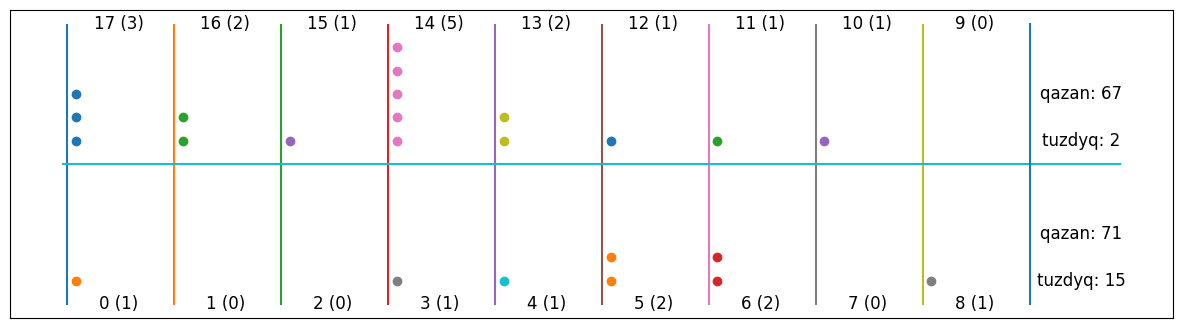

MOVE #91
bastaushy made action 5
bastaushy won tuzdyq 1
bastaushy won total 1


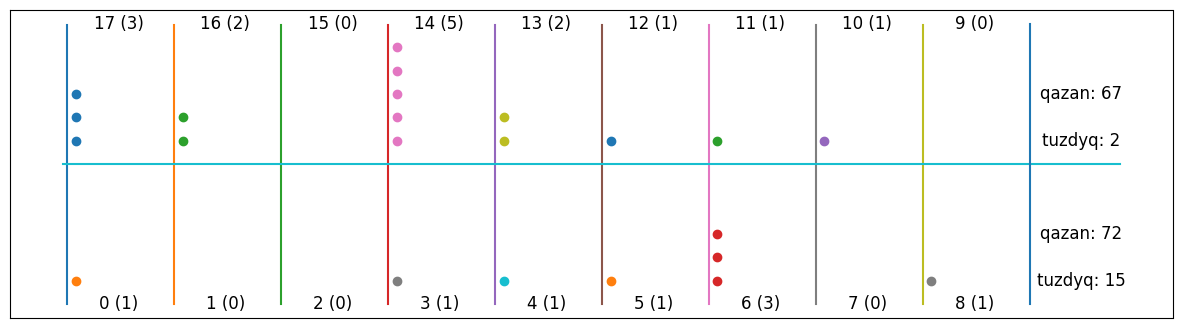

Please enter your action with mask [False, True, True, True, True, True, False, True, True] or press q for quit:


 5


MOVE #92
qostaushy made action 14
qostaushy won 2
qostaushy won total 2


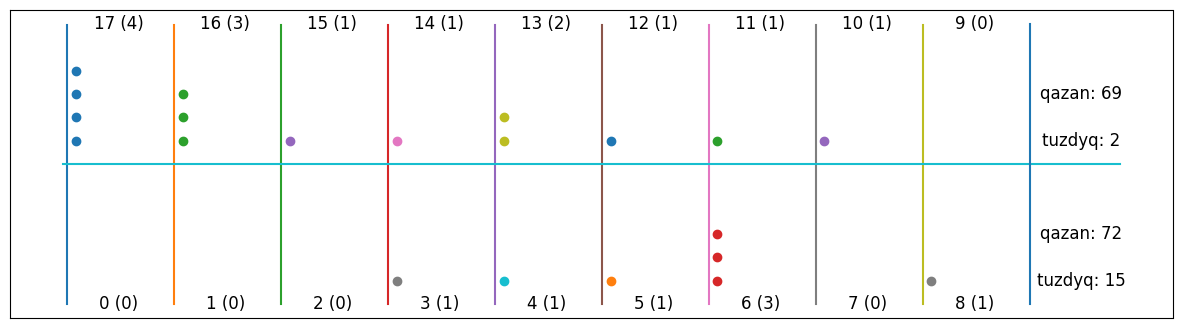

MOVE #93
bastaushy made action 6
bastaushy won tuzdyq 1
bastaushy won total 1


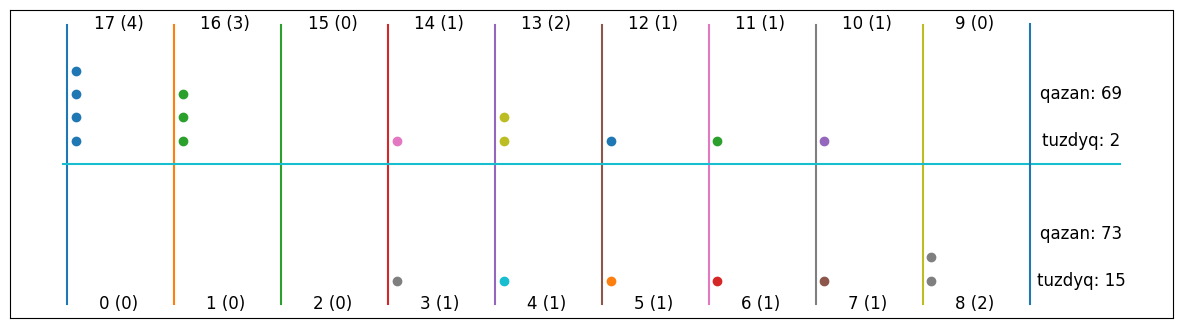

Please enter your action with mask [False, True, True, True, True, True, False, True, True] or press q for quit:


 7


MOVE #94
qostaushy made action 16
qostaushy won total 0


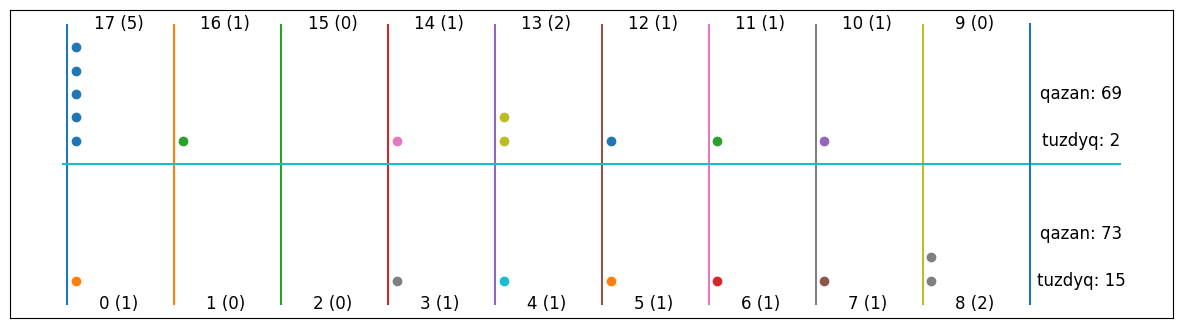

MOVE #95
bastaushy made action 4
bastaushy won total 0


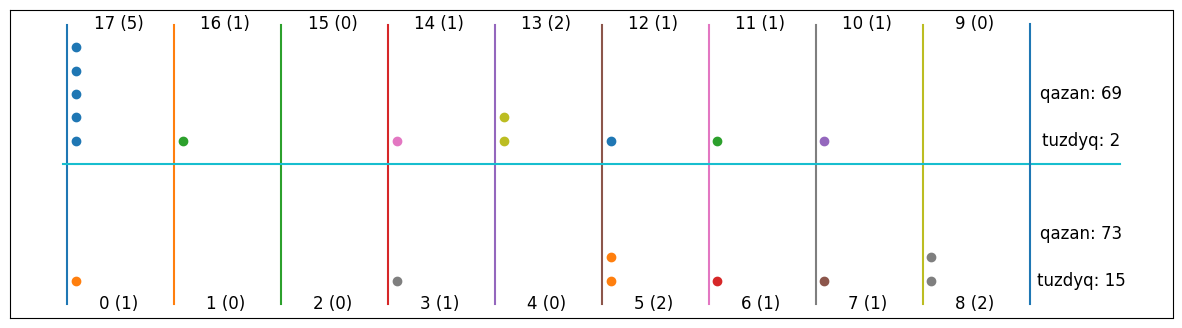

Please enter your action with mask [False, True, True, True, True, True, False, True, True] or press q for quit:


 8


MOVE #96
qostaushy made action 17
qostaushy won 2
qostaushy won tuzdyq 1
qostaushy won total 3


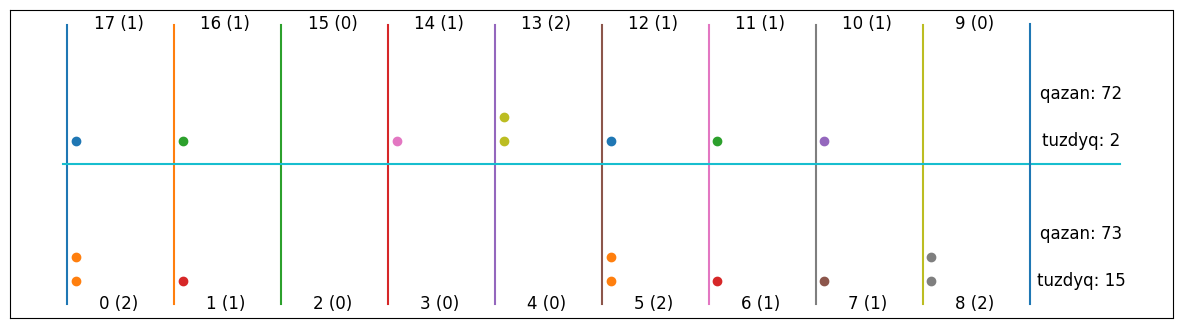

MOVE #97
bastaushy made action 5
bastaushy won total 0


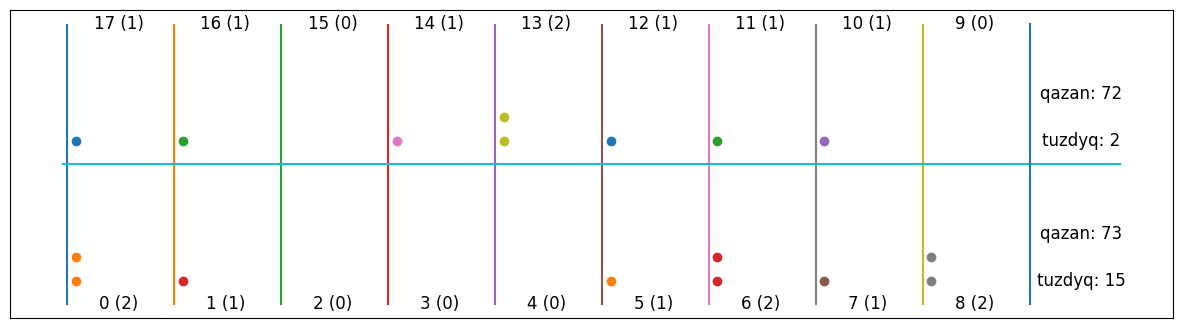

Please enter your action with mask [False, True, True, True, True, True, False, True, True] or press q for quit:


 1


MOVE #98
qostaushy made action 10
qostaushy won total 0


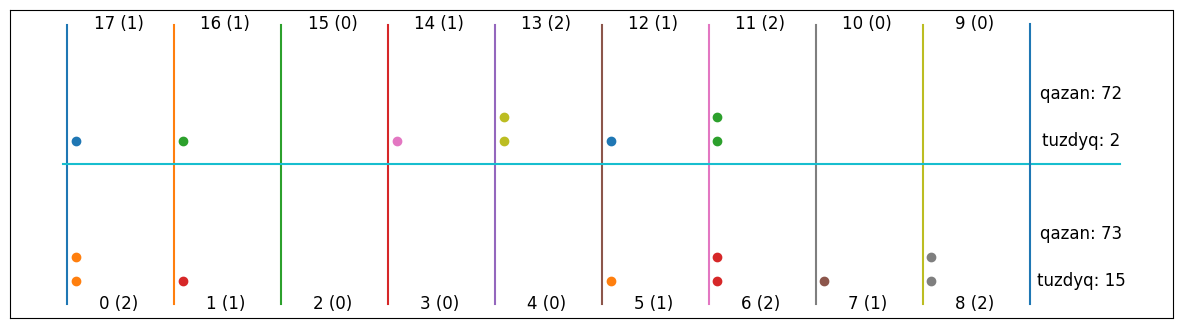

MOVE #99
bastaushy made action 5
bastaushy won total 0


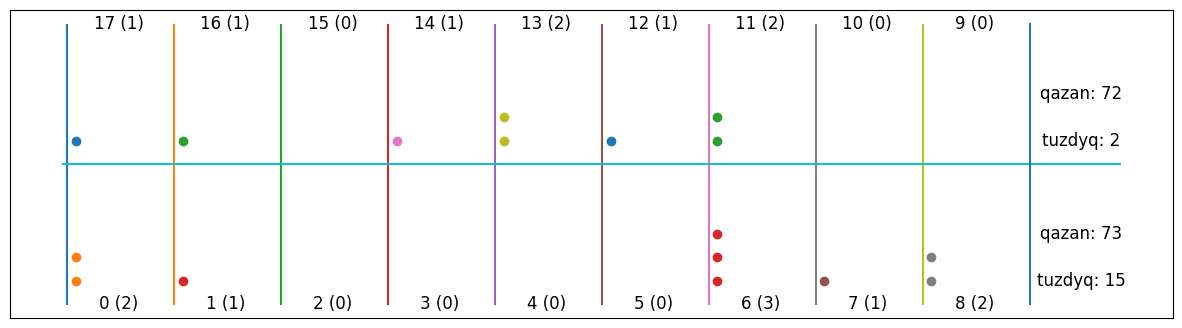

Please enter your action with mask [False, False, True, True, True, True, False, True, True] or press q for quit:


 2


MOVE #100
qostaushy made action 11
qostaushy won total 0


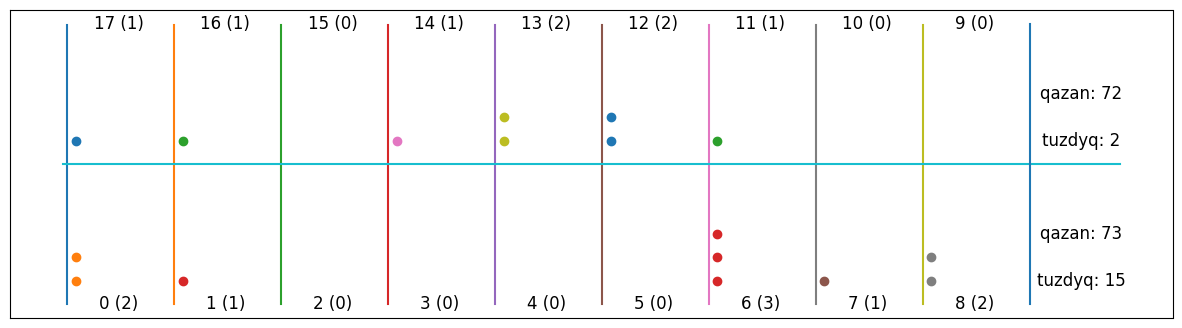

MOVE #101
bastaushy made action 6
bastaushy won total 0


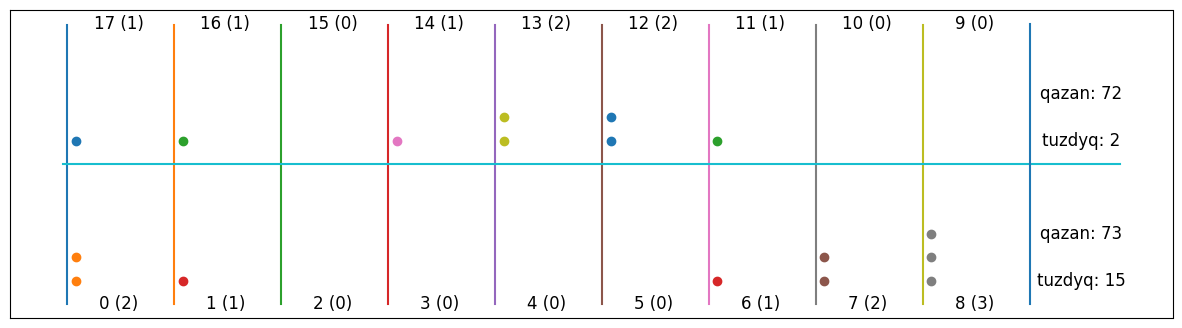

Please enter your action with mask [False, False, True, True, True, True, False, True, True] or press q for quit:


 2


MOVE #102
qostaushy made action 11
qostaushy won total 0


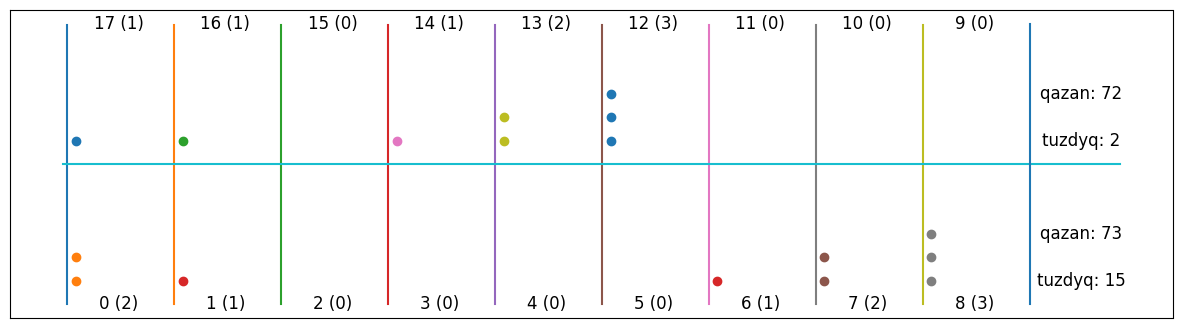

MOVE #103
bastaushy made action 1
bastaushy won total 0


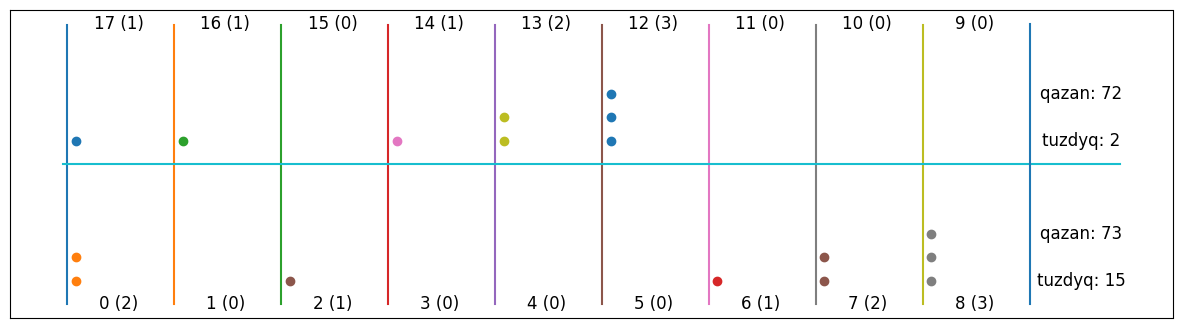

Please enter your action with mask [False, False, False, True, True, True, False, True, True] or press q for quit:


 3


MOVE #104
qostaushy made action 12
qostaushy won tuzdyq 1
qostaushy won total 1


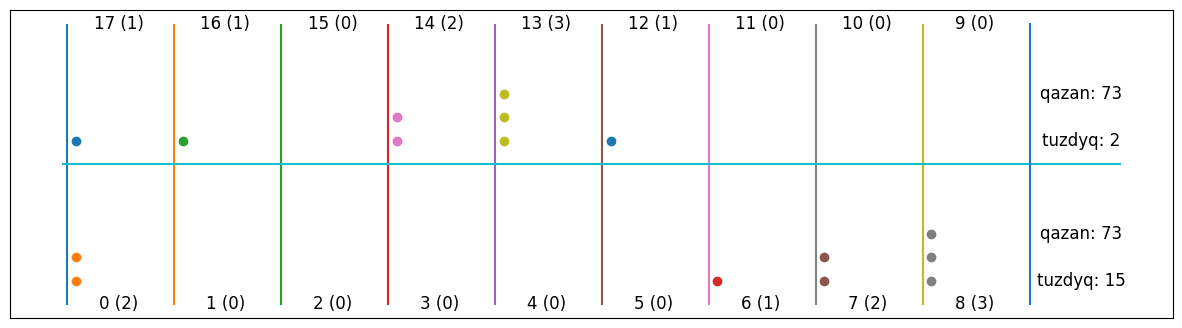

MOVE #105
bastaushy made action 6
bastaushy won total 0


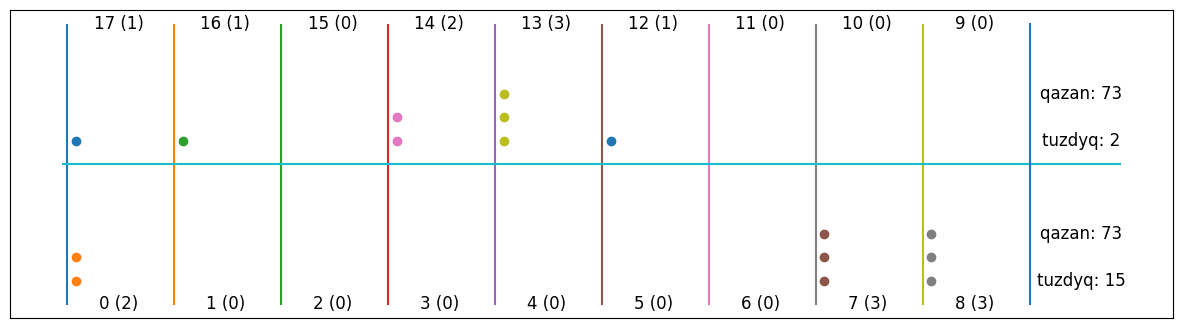

Please enter your action with mask [False, False, False, True, True, True, False, True, True] or press q for quit:


 3


MOVE #106
qostaushy made action 12
qostaushy won total 0


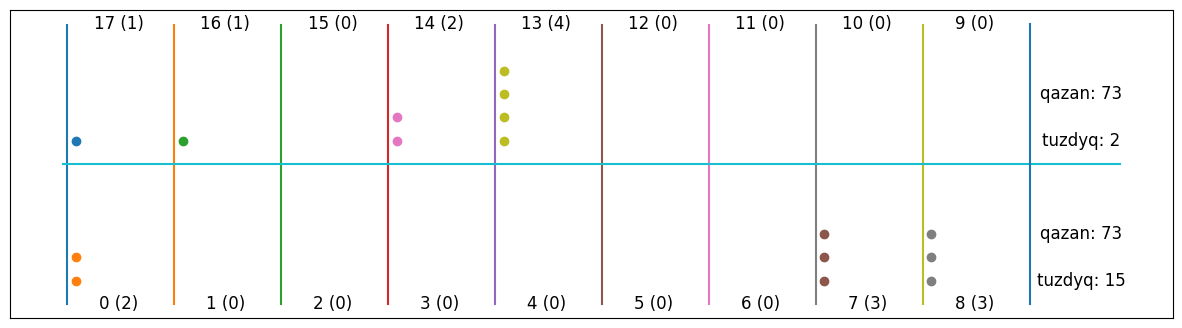

MOVE #107
bastaushy made action 8
bastaushy won total 0


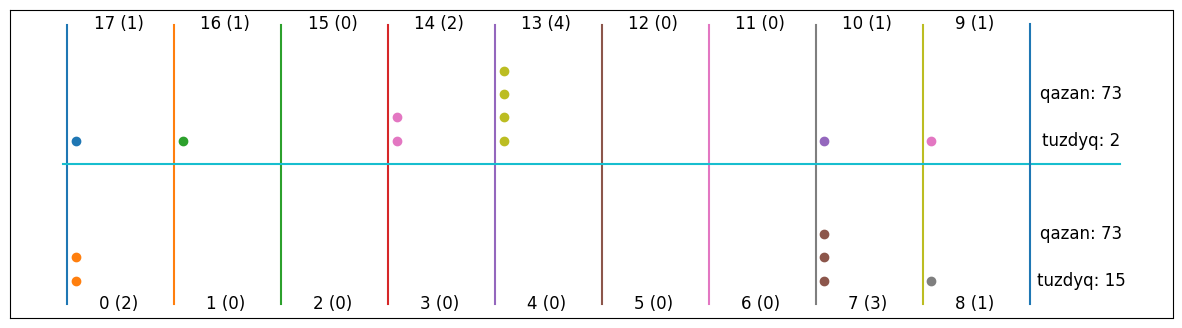

Please enter your action with mask [True, True, False, False, True, True, False, True, True] or press q for quit:


 0


MOVE #108
qostaushy made action 9
qostaushy won total 0


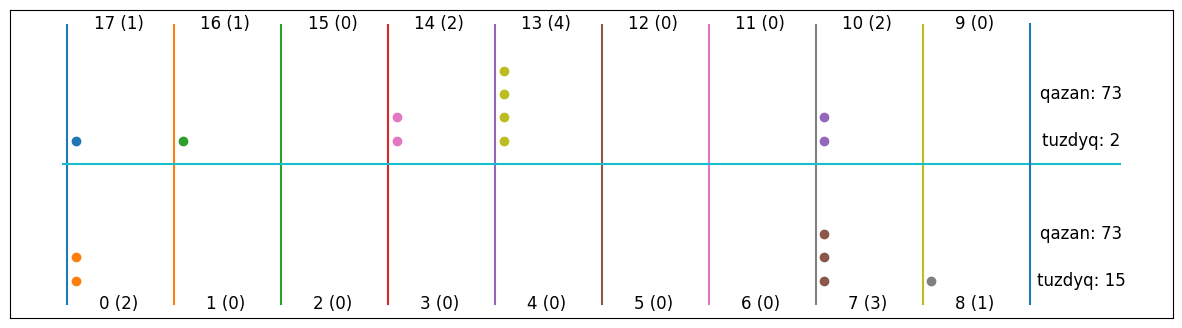

MOVE #109
bastaushy made action 7
bastaushy won total 0


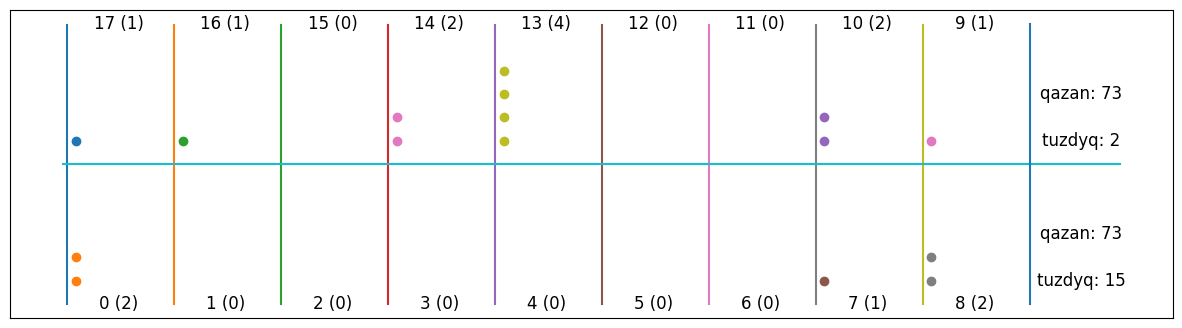

Please enter your action with mask [True, True, False, False, True, True, False, True, True] or press q for quit:


 0


MOVE #110
qostaushy made action 9
qostaushy won total 0


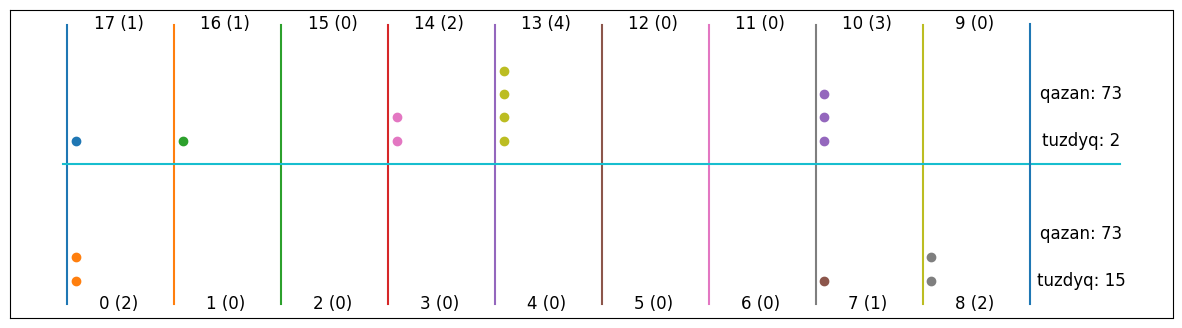

MOVE #111
bastaushy made action 8
bastaushy won total 0


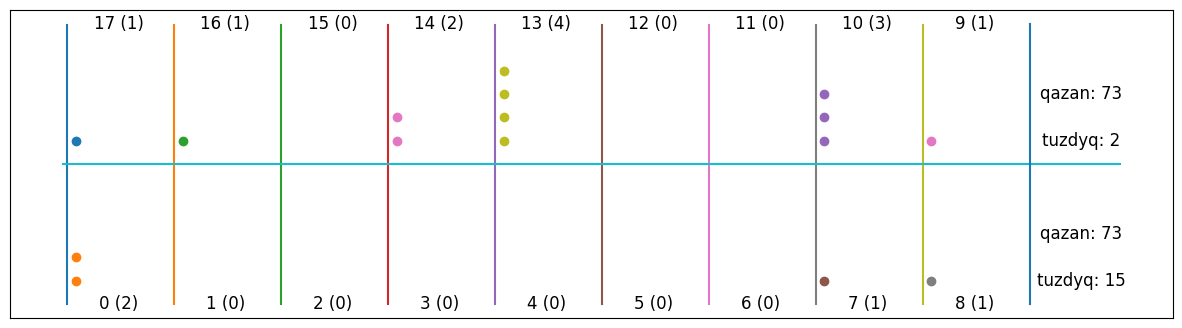

Please enter your action with mask [True, True, False, False, True, True, False, True, True] or press q for quit:


 0


MOVE #112
qostaushy made action 9
qostaushy won total 0


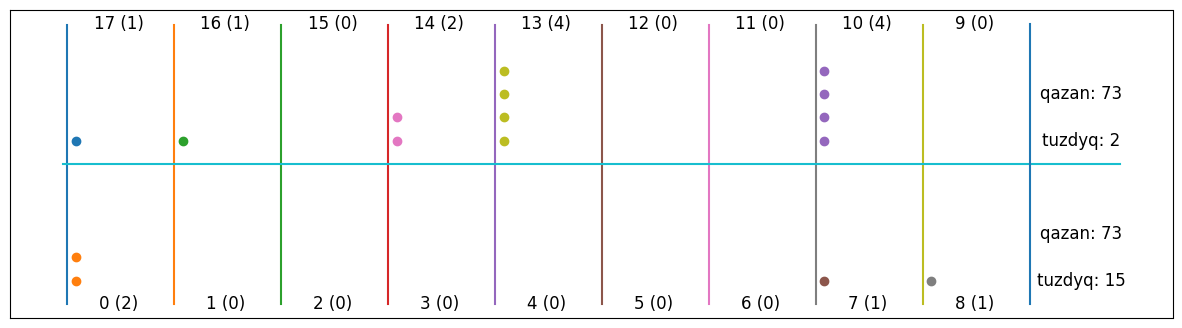

MOVE #113
bastaushy made action 7
bastaushy won total 0


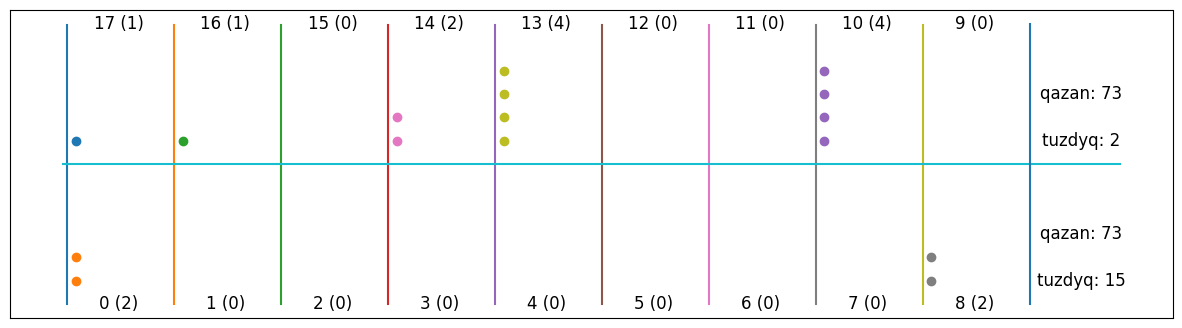

Please enter your action with mask [False, True, False, False, True, True, False, True, True] or press q for quit:


 4


MOVE #114
qostaushy made action 13
qostaushy won total 0


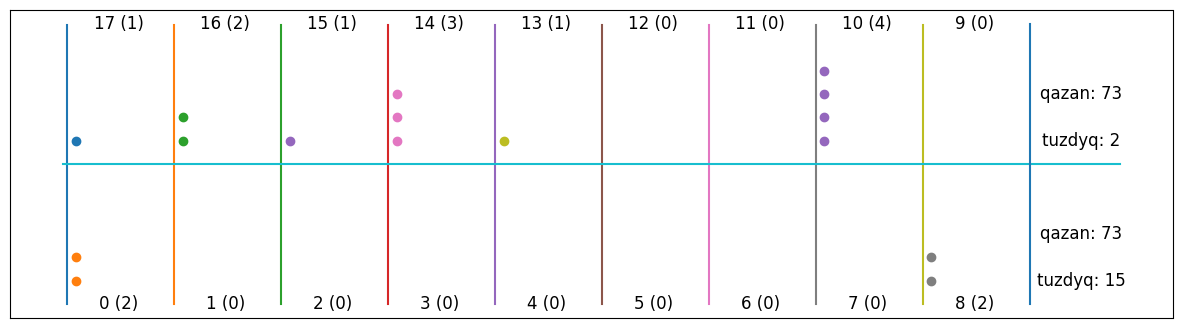

MOVE #115
bastaushy made action 8
bastaushy won tuzdyq 1
bastaushy won total 1


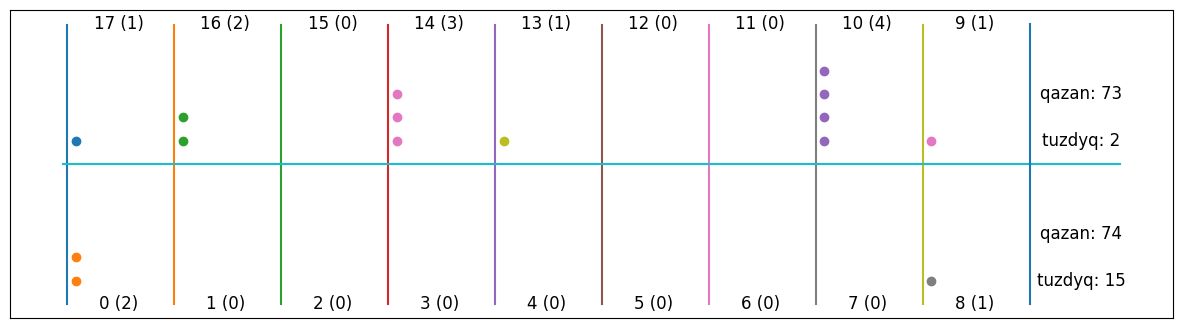

Please enter your action with mask [True, True, False, False, True, True, False, True, True] or press q for quit:


 4


MOVE #116
qostaushy made action 13
qostaushy won total 0


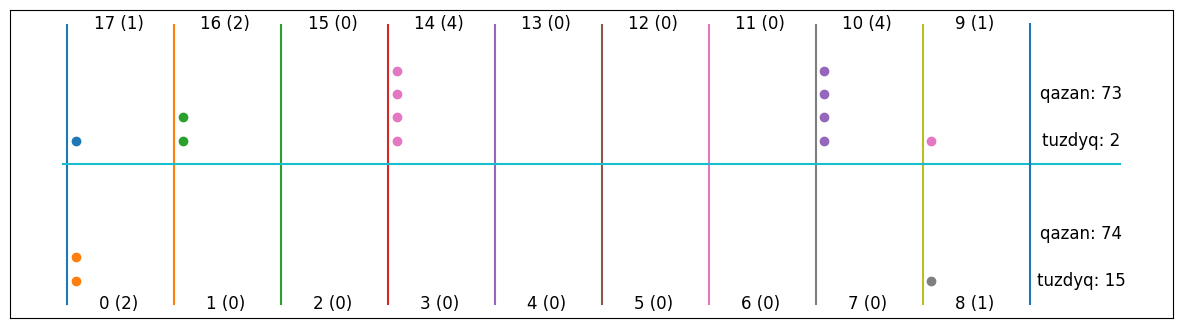

MOVE #117
bastaushy made action 0
bastaushy won total 0


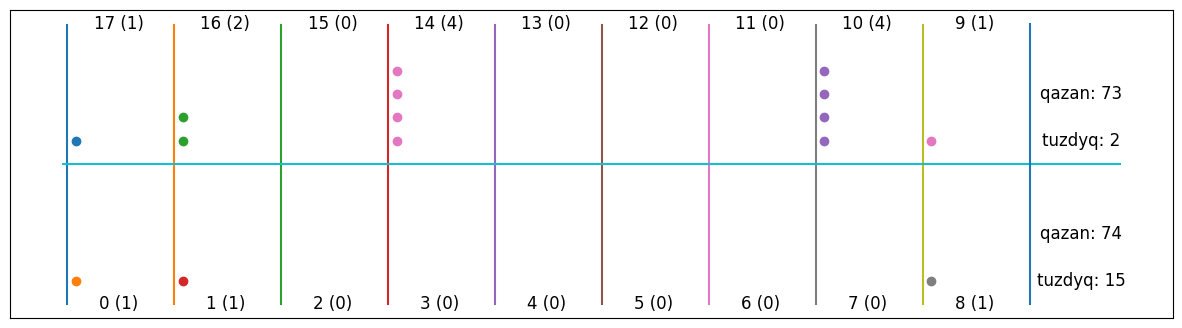

Please enter your action with mask [True, True, False, False, False, True, False, True, True] or press q for quit:


 0


MOVE #118
qostaushy made action 9
qostaushy won total 0


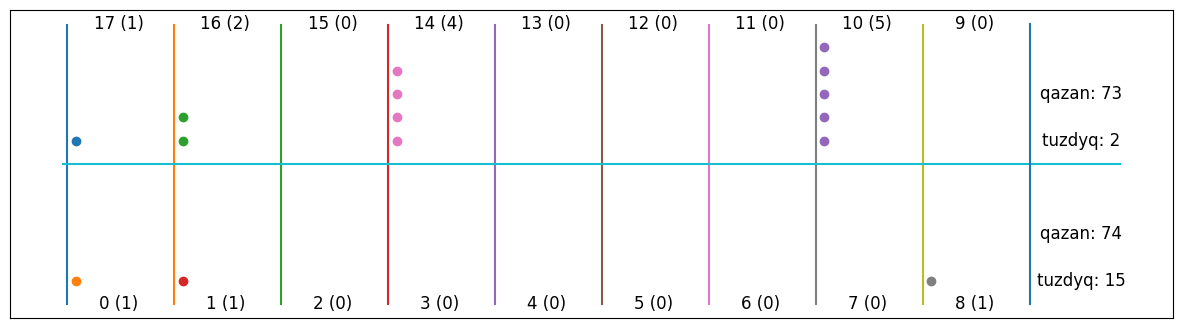

MOVE #119
bastaushy made action 1
bastaushy won total 0


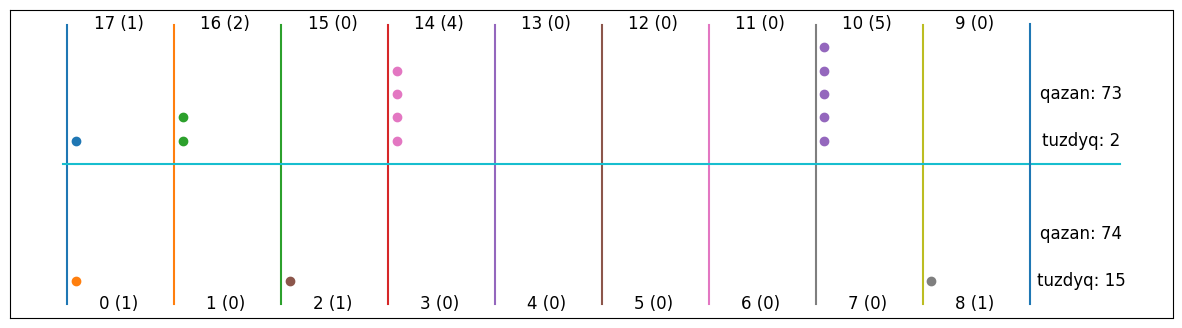

Please enter your action with mask [False, True, False, False, False, True, False, True, True] or press q for quit:


 5


MOVE #120
qostaushy made action 14
qostaushy won tuzdyq 1
qostaushy won total 1


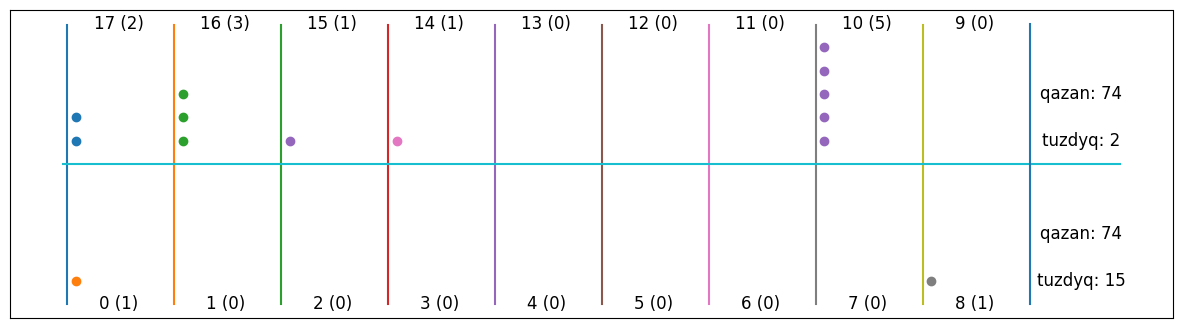

MOVE #121
bastaushy made action 0
bastaushy won tuzdyq 1
bastaushy won total 1


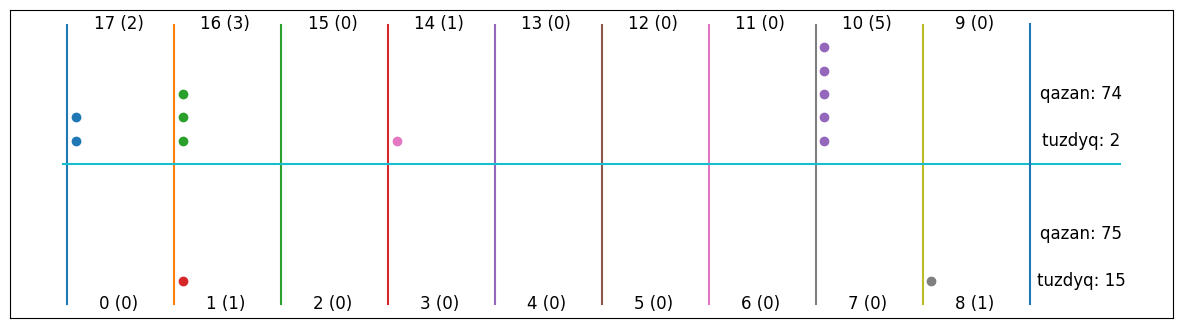

Please enter your action with mask [False, True, False, False, False, True, False, True, True] or press q for quit:


 7


MOVE #122
qostaushy made action 16
qostaushy won total 0


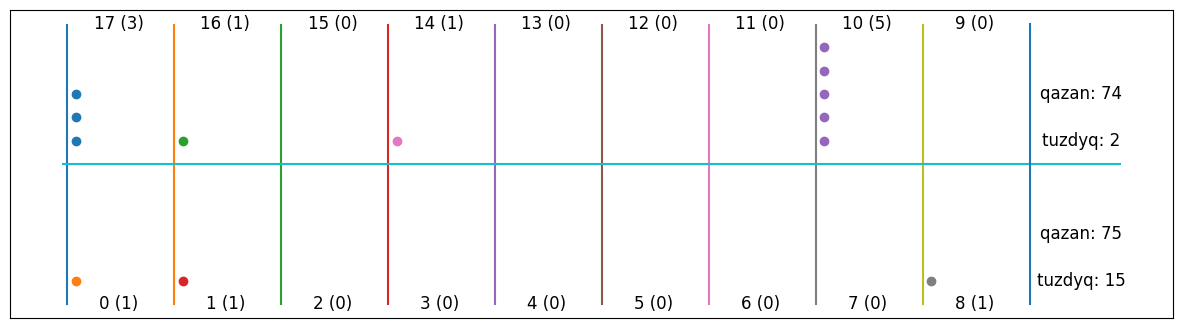

MOVE #123
bastaushy made action 1
bastaushy won total 0


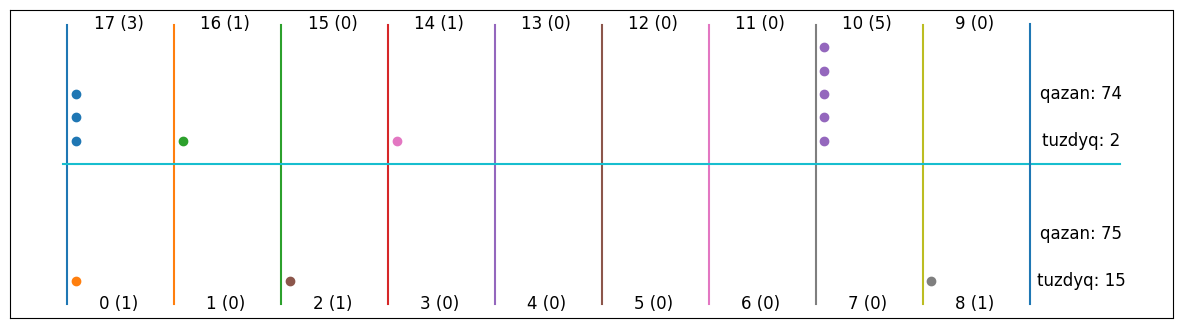

Please enter your action with mask [False, True, False, False, False, True, False, True, True] or press q for quit:


 7


MOVE #124
qostaushy made action 16
qostaushy won tuzdyq 1
qostaushy won total 1


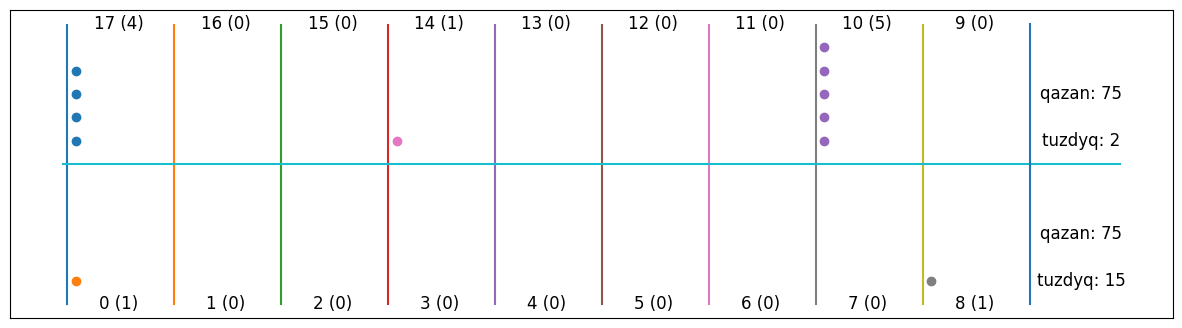

MOVE #125
bastaushy made action 0
bastaushy won total 0


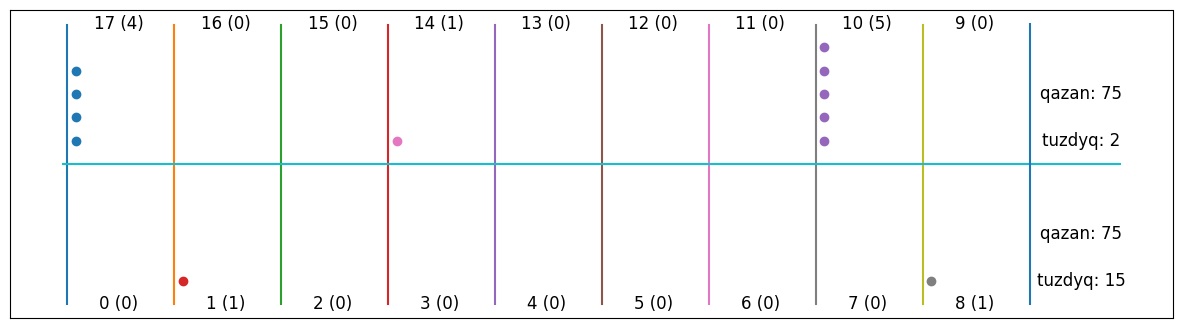

Please enter your action with mask [False, True, False, False, False, True, False, False, True] or press q for quit:


 1


MOVE #126
qostaushy made action 10
qostaushy won total 0


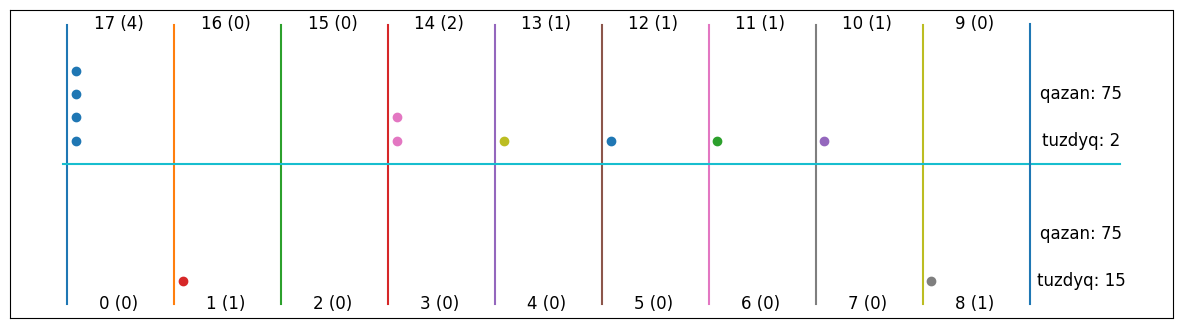

MOVE #127
bastaushy made action 1
bastaushy won total 0


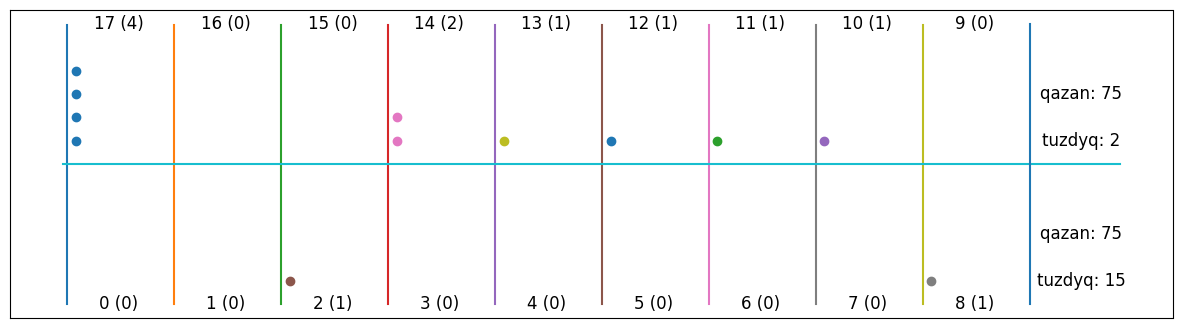

Please enter your action with mask [False, True, True, True, True, True, False, False, True] or press q for quit:


 1


MOVE #128
qostaushy made action 10
qostaushy won tuzdyq 1
qostaushy won total 1


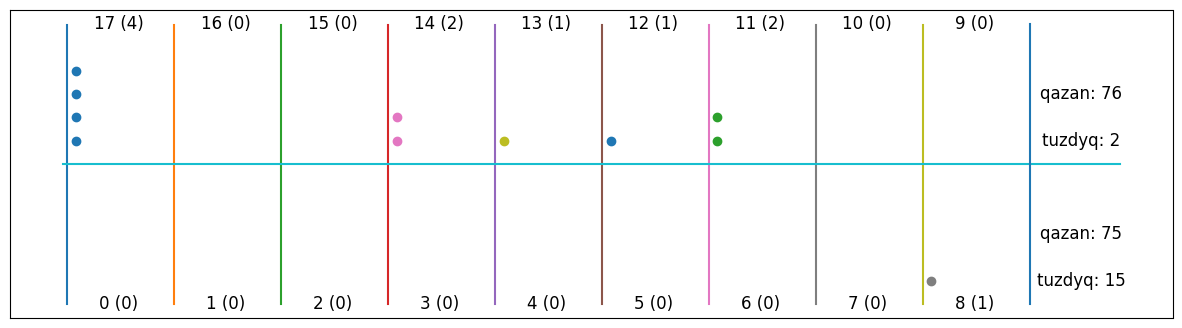

MOVE #129
bastaushy made action 8
bastaushy won total 0


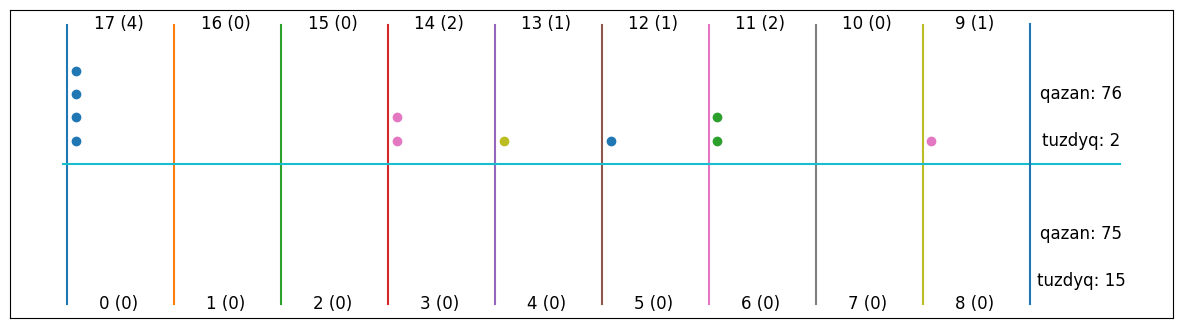

Please enter your action with mask [True, False, True, True, True, True, False, False, True] or press q for quit:


 0


MOVE #130
qostaushy made action 9
qostaushy won total 0
bastaushy reached atsyrau
qostaushy won the game!!!


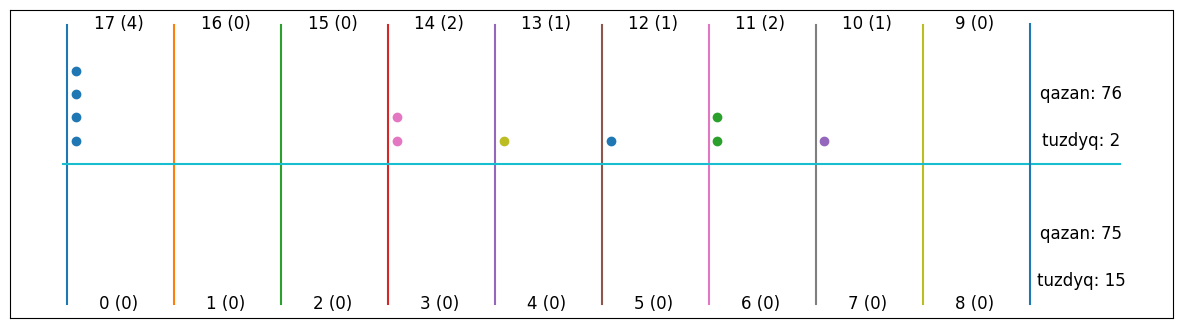

ValueError: when an agent is dead, the only valid action is None

In [18]:
# Play with LEVEL 3 TheNineQ mobile game
play = True 
env = _get_env(render_mode="human")
obs = env.reset()[0]
mask = obs['mask']

while play:
    flag = True
    
    batch = Batch(obs=Batch(agent_id=obs['agent_id'], obs=[obs['obs']], mask=[obs['mask']]), info='?')
    agent_trained.eval()
    
    act = agent_trained(batch=batch).act.item()
    obs, rewards, term, trunc, _ = env.step(act)
    mask = obs['mask']
    while flag:
        print(f"Please enter your action with mask {mask} or press q for quit:")
        human_act = input()
        if int(human_act) in [i for i in range(9) if mask[i]]:
            flag = False
        else:
            flag = True
    if human_act == 'q':
        play = False
        break

    obs, rewards, term, trunc, _ = env.step(int(human_act))
    
env.close()